# Notebook 2: VLM Annotation Results Analysis Notebook
This notebook analyzes the results for VLM annotation of IDF Spokesperson videos. This is where the bulk of the analysis is performed. Please view the main paper for more details.

Prepared by Mike Chow
[michael.chow@student.uva.nl
](michael.chow@student.uva.nl)

## Initiatialization
- Load libraries
- Load directory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
import re
import ast
import krippendorff
from sklearn.metrics import confusion_matrix
import seaborn as sns
import networkx as nx
import cv2
import textwrap


In [2]:
# Load directory and files
root_folder = '' # Please adjust as necessary
assert root_folder != '', "Please specify a root folder"

vlm_anno_path = os.path.join(root_folder, 'input_data', 'idf_data_shot_spox_vlm_pose_annotated.csv')
vlm_anno_log = os.path.join(root_folder, 'input_data','vlm_annotation_log.csv')
frames_folder = os.path.join(root_folder, 'input_data','idf_data_spoxvid_shot_keyframes')
pri_coding_path = os.path.join(root_folder, 'input_data','idf_coding_primary.csv')
sec_coding_path = os.path.join(root_folder, 'input_data','idf_coding_secondary.csv')
output_path = os.path.join(root_folder, 'output')
data_output = os.path.join(output_path, 'interm_data')
viz_output = os.path.join(output_path, 'viz')

# Experimental Task 1: Shot scale classification

## Set up files and clean

All annotation sources will be integrated here
- ```idf_data_shot_spox_vlm_pose_annotated.csv``` - Contains all VLM annotations, as well as annotations from the pose estimation model (See other notebook for the process)
- ```idf_coding_primary.csv``` - Primary coding performed by myself (Mike Chow)
- ```idf_coding_secondary.csv``` - Secondary coding

In [3]:
df_vlm = pd.read_csv(vlm_anno_path)
vlm_log = pd.read_csv(vlm_anno_log)
df_pri = pd.read_csv(pri_coding_path)
df_sec = pd.read_csv(sec_coding_path)

In [4]:
# Handle and clean df_pri
df_pri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1442 non-null   object
 1   spox_gender_m      1442 non-null   object
 2   location_m         1442 non-null   object
 3   combat_presence_m  1442 non-null   object
 4   shot_scale_m       1442 non-null   object
 5   selfie_m           1442 non-null   object
dtypes: object(6)
memory usage: 67.7+ KB


In [4]:
df_pri = df_pri.drop(columns=['selfie_m'], axis=1)
df_pri

id spox_gender_m location_m  \
0      7287537715829148930.mp4_scene_1             M     Indoor   
1      7287823285566426369.mp4_scene_1             M     Indoor   
2      7287823285566426369.mp4_scene_2       no_spox    Outdoor   
3      7287823285566426369.mp4_scene_3       no_spox    Outdoor   
4      7287823285566426369.mp4_scene_4       no_spox    Outdoor   
...                                ...           ...        ...   
1437   7422934013553216775.mp4_scene_6             F    Outdoor   
1438   7422934013553216775.mp4_scene_7             F    Outdoor   
1439   7422934013553216775.mp4_scene_8             F    Outdoor   
1440   7422934013553216775.mp4_scene_9             F    Outdoor   
1441  7422934013553216775.mp4_scene_10             F    Outdoor   

     combat_presence_m      shot_scale_m  
0           Non-combat       Medium shot  
1           Non-combat       Medium shot  
2               Combat             Empty  
3               Combat             Empty  
4               Combat             Empty  
...                ...               ...  
1437        Non-combat  Medium full shot  
1438        Non-combat  Medium full shot  
1439        Non-combat  Medium full shot  
1440        Non-combat       Medium shot  
1441        Non-combat  Medium full shot  

[1442 rows x 5 columns]

In [5]:
df_sec

id spox_gender_c location_c  \
0      7287537715829148930.mp4_scene_1             M     Indoor   
1      7287823285566426369.mp4_scene_1             M    Outdoor   
2      7287823285566426369.mp4_scene_2       no_spox    Outdoor   
3      7287823285566426369.mp4_scene_3       no_spox    Outdoor   
4      7287823285566426369.mp4_scene_4       no_spox    Outdoor   
...                                ...           ...        ...   
1437   7422934013553216775.mp4_scene_6             F    Outdoor   
1438   7422934013553216775.mp4_scene_7             F    Outdoor   
1439   7422934013553216775.mp4_scene_8             F    Outdoor   
1440   7422934013553216775.mp4_scene_9             F    Outdoor   
1441  7422934013553216775.mp4_scene_10             F    Outdoor   

     combat_presence_c      shot_scale_c  
0           Non-combat       Medium shot  
1           Non-combat       Medium shot  
2               Combat             Empty  
3               Combat             Empty  
4               Combat             Empty  
...                ...               ...  
1437        Non-combat  Medium full shot  
1438        Non-combat  Medium full shot  
1439        Non-combat  Medium full shot  
1440        Non-combat       Medium shot  
1441        Non-combat  Medium full shot  

[1442 rows x 5 columns]

In [6]:
df_human = pd.merge(df_pri, df_sec, on='id',how='left')

In [7]:
df_human

id spox_gender_m location_m  \
0      7287537715829148930.mp4_scene_1             M     Indoor   
1      7287823285566426369.mp4_scene_1             M     Indoor   
2      7287823285566426369.mp4_scene_2       no_spox    Outdoor   
3      7287823285566426369.mp4_scene_3       no_spox    Outdoor   
4      7287823285566426369.mp4_scene_4       no_spox    Outdoor   
...                                ...           ...        ...   
1437   7422934013553216775.mp4_scene_6             F    Outdoor   
1438   7422934013553216775.mp4_scene_7             F    Outdoor   
1439   7422934013553216775.mp4_scene_8             F    Outdoor   
1440   7422934013553216775.mp4_scene_9             F    Outdoor   
1441  7422934013553216775.mp4_scene_10             F    Outdoor   

     combat_presence_m      shot_scale_m spox_gender_c location_c  \
0           Non-combat       Medium shot             M     Indoor   
1           Non-combat       Medium shot             M    Outdoor   
2               Combat             Empty       no_spox    Outdoor   
3               Combat             Empty       no_spox    Outdoor   
4               Combat             Empty       no_spox    Outdoor   
...                ...               ...           ...        ...   
1437        Non-combat  Medium full shot             F    Outdoor   
1438        Non-combat  Medium full shot             F    Outdoor   
1439        Non-combat  Medium full shot             F    Outdoor   
1440        Non-combat       Medium shot             F    Outdoor   
1441        Non-combat  Medium full shot             F    Outdoor   

     combat_presence_c      shot_scale_c  
0           Non-combat       Medium shot  
1           Non-combat       Medium shot  
2               Combat             Empty  
3               Combat             Empty  
4               Combat             Empty  
...                ...               ...  
1437        Non-combat  Medium full shot  
1438        Non-combat  Medium full shot  
1439        Non-combat  Medium full shot  
1440        Non-combat       Medium shot  
1441        Non-combat  Medium full shot  

[1442 rows x 9 columns]

In [9]:
# Sanity check based on spox_gender

df_mismatch = df_human[df_human['spox_gender_m'] != df_human['spox_gender_c']].copy()
df_mismatch
# This means that everything is the same

Empty DataFrame
Columns: [id, spox_gender_m, location_m, combat_presence_m, shot_scale_m, spox_gender_c, location_c, combat_presence_c, shot_scale_c]
Index: []

## Merge with main data

In [8]:
# Assuming data has been cleaned
df_vlm = pd.merge(df_vlm, df_human, on='id',how='left')

In [12]:
df_vlm

id                  url  \
0      7357772207445134608.mp4_scene_1  7357772207445134608   
1      7357772207445134608.mp4_scene_2  7357772207445134608   
2      7357772207445134608.mp4_scene_3  7357772207445134608   
3      7357772207445134608.mp4_scene_4  7357772207445134608   
4      7357772207445134608.mp4_scene_5  7357772207445134608   
...                                ...                  ...   
1437  7287823285566426369.mp4_scene_12  7287823285566426369   
1438  7287823285566426369.mp4_scene_13  7287823285566426369   
1439  7287823285566426369.mp4_scene_14  7287823285566426369   
1440  7287823285566426369.mp4_scene_15  7287823285566426369   
1441   7287537715829148930.mp4_scene_1  7287537715829148930   

                          from_dataset  start_frame              start_time  \
0     3d0ad485936bf3a6518f8633d15848b8            0         0 days 00:00:00   
1     3d0ad485936bf3a6518f8633d15848b8           61  0 days 00:00:02.033000   
2     3d0ad485936bf3a6518f8633d15848b8           83  0 days 00:00:02.767000   
3     3d0ad485936bf3a6518f8633d15848b8          121  0 days 00:00:04.033000   
4     3d0ad485936bf3a6518f8633d15848b8          221  0 days 00:00:07.367000   
...                                ...          ...                     ...   
1437  3d0ad485936bf3a6518f8633d15848b8          708  0 days 00:00:23.624000   
1438  3d0ad485936bf3a6518f8633d15848b8          760  0 days 00:00:25.359000   
1439  3d0ad485936bf3a6518f8633d15848b8          793  0 days 00:00:26.460000   
1440  3d0ad485936bf3a6518f8633d15848b8          854  0 days 00:00:28.495000   
1441  3d0ad485936bf3a6518f8633d15848b8            0         0 days 00:00:00   

      start_fps  end_frame                end_time  end_fps  scene_num  ...  \
0         30.00         61  0 days 00:00:02.033000    30.00          1  ...   
1         30.00         83  0 days 00:00:02.767000    30.00          2  ...   
2         30.00        121  0 days 00:00:04.033000    30.00          3  ...   
3         30.00        221  0 days 00:00:07.367000    30.00          4  ...   
4         30.00        229  0 days 00:00:07.633000    30.00          5  ...   
...         ...        ...                     ...      ...        ...  ...   
1437      29.97        760  0 days 00:00:25.359000    29.97         12  ...   
1438      29.97        793  0 days 00:00:26.460000    29.97         13  ...   
1439      29.97        854  0 days 00:00:28.495000    29.97         14  ...   
1440      29.97       1212  0 days 00:00:40.440000    29.97         15  ...   
1441      25.00        611  0 days 00:00:24.440000    25.00          1  ...   

      combat_presence_vlm_02  combat_presence_vlm_03 spox_gender_m location_m  \
0                 Non-combat              Non-combat             F     Indoor   
1                 Non-combat              Non-combat       no_spox    Outdoor   
2                   Graphics                Graphics       no_spox   Graphics   
3                 Non-combat              Non-combat             F     Indoor   
4                   Graphics                Graphics       no_spox   Graphics   
...                      ...                     ...           ...        ...   
1437                  Combat                  Combat       no_spox    Outdoor   
1438              Non-combat              Non-combat       no_spox     Indoor   
1439              Non-combat              Non-combat       no_spox    Outdoor   
1440              Non-combat              Non-combat             M     Indoor   
1441              Non-combat              Non-combat             M     Indoor   

      combat_presence_m shot_scale_m spox_gender_c  location_c  \
0            Non-combat  Medium shot             F      Indoor   
1                Combat        Empty       no_spox     Outdoor   
2              Graphics        Empty       no_spox    Graphics   
3            Non-combat  Medium shot             F      Indoor   
4              Graphics        Empty       no_spox    Graphics   
...         

In [9]:
df_mismatch = df_vlm[df_vlm['spox_gender_m'] != df_vlm['spox_gender']].copy()
df_mismatch[['id' ,'spox_gender_m','spox_gender']]

id spox_gender_m spox_gender
36     7288363457341164801.mp4_scene_3             F     no_spox
39     7288363457341164801.mp4_scene_6             F     no_spox
40     7288363457341164801.mp4_scene_7             F     no_spox
75     7422617346390494471.mp4_scene_2             M     no_spox
83    7422617346390494471.mp4_scene_10             M     no_spox
...                                ...           ...         ...
1401   7289287958908144897.mp4_scene_7             M     no_spox
1402   7289287958908144897.mp4_scene_8             M     no_spox
1403   7289287958908144897.mp4_scene_9             M     no_spox
1404  7289287958908144897.mp4_scene_10             M     no_spox
1406  7289287958908144897.mp4_scene_12             M     no_spox

[127 rows x 3 columns]

In [10]:
# 'spox_gender' was gender labels automatically labelled with a gender detector for filtering
# This can now be replaced with the manually annotated spokesperson genders
df_vlm['spox_gender'] = df_vlm['spox_gender_m']


In [11]:
df_vlm.columns.to_list()

['id',
 'url',
 'from_dataset',
 'start_frame',
 'start_time',
 'start_fps',
 'end_frame',
 'end_time',
 'end_fps',
 'scene_num',
 'num_scenes_detected',
 'total_video_frames',
 'total_video_duration',
 'face_locations_list',
 'face_count',
 'face_list',
 'gender_list',
 'm_count',
 'f_count',
 'spox_gender',
 'shot_scale_vlm_1a_01',
 'shot_scale_vlm_1a_02',
 'shot_scale_vlm_1a_03',
 'shot_scale_vlm_1a_04_tuple',
 'shot_scale_vlm_1a_05_filler',
 'shot_scale_vlm_1a_06',
 'shot_scale_vlm_1a_07',
 'shot_scale_vlm_1a_08',
 'shot_scale_vlm_1a_09_tuple',
 'shot_scale_vlm_1a_10_filler',
 'shot_scale_vlm_1b_01',
 'shot_scale_vlm_1b_02',
 'shot_scale_vlm_1b_03',
 'shot_scale_vlm_1b_04_tuple',
 'shot_scale_vlm_1b_05_filler',
 'shot_scale_vlm_1b_06',
 'shot_scale_vlm_1b_07',
 'shot_scale_vlm_1b_08',
 'shot_scale_vlm_1b_09_tuple',
 'shot_scale_vlm_1b_10_filler',
 'shot_scale_vlm_1c_01',
 'shot_scale_vlm_1c_02',
 'shot_scale_vlm_1c_03',
 'shot_scale_vlm_1c_04_tuple',
 'shot_scale_vlm_1c_05_filler',

In [12]:
# Carefully selecting and ordering columns
df_main = df_vlm[['id',
                 'url',
                 # 'from_dataset',
                 'start_frame',
                 'start_time',
                 # 'start_fps',
                 'end_frame',
                 'end_time',
                 'end_fps',
                 'scene_num',
                 'num_scenes_detected',
                 'total_video_frames',
                 'total_video_duration',
                 'face_locations_list',
                 'face_count',
                 'face_list',
                 'gender_list',
                 'm_count',
                 'f_count',
                 'spox_gender',

                 'shot_scale_vlm_1a_01',
                 'shot_scale_vlm_1a_02',
                 'shot_scale_vlm_1a_03',
                 'shot_scale_vlm_1a_04_tuple',
                 'shot_scale_vlm_1a_05_filler',
                 'shot_scale_vlm_1a_06',
                 'shot_scale_vlm_1a_07',
                 'shot_scale_vlm_1a_08',
                 'shot_scale_vlm_1a_09_tuple',
                 'shot_scale_vlm_1a_10_filler',

                 'shot_scale_vlm_1b_01',
                 'shot_scale_vlm_1b_02',
                 'shot_scale_vlm_1b_03',
                 'shot_scale_vlm_1b_04_tuple',
                 'shot_scale_vlm_1b_05_filler',
                 'shot_scale_vlm_1b_06',
                 'shot_scale_vlm_1b_07',
                 'shot_scale_vlm_1b_08',
                 'shot_scale_vlm_1b_09_tuple',
                 'shot_scale_vlm_1b_10_filler',

                 'shot_scale_vlm_1c_01',
                 'shot_scale_vlm_1c_02',
                 'shot_scale_vlm_1c_03',
                 'shot_scale_vlm_1c_04_tuple',
                 'shot_scale_vlm_1c_05_filler',
                 'shot_scale_vlm_1c_06',
                 'shot_scale_vlm_1c_07',
                 'shot_scale_vlm_1c_08',
                 'shot_scale_vlm_1c_09_tuple',
                 'shot_scale_vlm_1c_10_filler',

                 'shot_scale_classifier_1',
                 'shot_scale_classifier_2',
                 'shot_scale_classifier_3',
                 'setting_vlm_2a_01',
                 'setting_vlm_2b_01',
                 'setting_vlm_2c_01',
                 'location_vlm_01',
                 'location_vlm_02',
                 'location_vlm_03',
                 'combat_presence_vlm_01',
                 'combat_presence_vlm_02',
                 'combat_presence_vlm_03',
                 # 'spox_gender_m',
                 'location_m',
                 'combat_presence_m',
                 'shot_scale_m',
                 # 'spox_gender_c',
                 'location_c',
                 'combat_presence_c',
                 'shot_scale_c']]

In [13]:
# Output interim dataframe
df_main.to_csv(os.path.join(data_output, '01_idf_data_full_annotations.csv'), index=False)

In [22]:
df_main

id                  url  start_frame  \
0      7357772207445134608.mp4_scene_1  7357772207445134608            0   
1      7357772207445134608.mp4_scene_2  7357772207445134608           61   
2      7357772207445134608.mp4_scene_3  7357772207445134608           83   
3      7357772207445134608.mp4_scene_4  7357772207445134608          121   
4      7357772207445134608.mp4_scene_5  7357772207445134608          221   
...                                ...                  ...          ...   
1437  7287823285566426369.mp4_scene_12  7287823285566426369          708   
1438  7287823285566426369.mp4_scene_13  7287823285566426369          760   
1439  7287823285566426369.mp4_scene_14  7287823285566426369          793   
1440  7287823285566426369.mp4_scene_15  7287823285566426369          854   
1441   7287537715829148930.mp4_scene_1  7287537715829148930            0   

                  start_time  end_frame                end_time  end_fps  \
0            0 days 00:00:00         61  0 days 00:00:02.033000    30.00   
1     0 days 00:00:02.033000         83  0 days 00:00:02.767000    30.00   
2     0 days 00:00:02.767000        121  0 days 00:00:04.033000    30.00   
3     0 days 00:00:04.033000        221  0 days 00:00:07.367000    30.00   
4     0 days 00:00:07.367000        229  0 days 00:00:07.633000    30.00   
...                      ...        ...                     ...      ...   
1437  0 days 00:00:23.624000        760  0 days 00:00:25.359000    29.97   
1438  0 days 00:00:25.359000        793  0 days 00:00:26.460000    29.97   
1439  0 days 00:00:26.460000        854  0 days 00:00:28.495000    29.97   
1440  0 days 00:00:28.495000       1212  0 days 00:00:40.440000    29.97   
1441         0 days 00:00:00        611  0 days 00:00:24.440000    25.00   

      scene_num  num_scenes_detected  total_video_frames  ... location_vlm_03  \
0             1                   34                2126  ...          Indoor   
1             2                   34                2126  ...         Outdoor   
2             3                   34                2126  ...        Graphics   
3             4                   34                2126  ...          Indoor   
4             5                   34                2126  ...        Graphics   
...         ...                  ...                 ...  ...             ...   
1437         12                   15                1212  ...         Outdoor   
1438         13                   15                1212  ...          Indoor   
1439         14                   15                1212  ...          Indoor   
1440         15                   15                1212  ...          Indoor   
1441          1                    1                 611  ...          Indoor   

     combat_presence_vlm_01  combat_presence_vlm_02 combat_presence_vlm_03  \
0                Non-combat              Non-combat             Non-combat   
1                Non-combat              Non-combat             Non-combat   
2                  Graphics                Graphics               Graphics   
3                Non-combat              Non-combat             Non-combat   
4                  Graphics                Graphics               Graphics   
...                     ...                     ...                    ...   
1437                 Combat                  Combat                 Combat   
1438             Non-combat              Non-combat             Non-combat   
1439             Non-combat              Non-combat             Non-combat   
1440             Non-combat              Non-combat             Non-combat   
1441             Non-combat              Non-combat             Non-combat   

     location_m  combat_presence_m  shot_scale_m location_c combat_presence_c  \
0        Indoor         Non-combat   Medium shot     Indoor        Non-combat   
1       Outdoor             Combat         Empty    Outdoor        Non-combat   
2      Graphics           Graphics         Empty   Graphi

## Noise: Analysis and cleaning

In this section of the notebook, all VLM generated annotations will be analyzed for noise and be cleaned.

Each VLM entered column will have a corresponding column that carries a boolean which informs if the entry is acceptable or not.

Steps:
- Define what's considered noise
- Match and derive the boolean
- Filter and clean

### Definitions of valid entries (ie not noise) **for prompt variation A and C**


*Standard runs (01-03 and 06-08)*

- Adheres to the constrained list of labels
- Erroneous capitalization (eg 'Close Up') will not be considered as noise and will be automatically coerced
```
['Close up', 'Medium close up', 'Medium shot', 'Medium full shot', 'Full shot', 'Wide shot', 'Empty', 'Uncertain']
```

*Motivation runs that generates tuples (04 and 09)*

- Minor errors in generating a tuple that can be read literally (such as missing quotation marks ```" "```) will be forgiven and cleaned
- Classification adheres to the constrained list of labels
```
['Close up', 'Medium close up', 'Medium shot', 'Medium full shot', 'Full shot', 'Wide shot', 'Empty', 'Uncertain']
```
- Motivation needs to be at least 15 characters (Condition implemented based on a survey of results)


*Filler runs to fill  ```'Uncertain'``` entries (05 and 10)*

- Classification adheres to the constrained list of labels
```
['Close up', 'Medium close up', 'Medium shot', 'Medium full shot', 'Full shot', 'Wide shot', 'Empty']
```
- Motivation needs to be at least 15 characters (Condition implemented based on a survey of results)

In [14]:
df_main = pd.read_csv(os.path.join(data_output, '01_idf_data_full_annotations.csv'))

In [15]:
# Ordinal rank for shot scale; Used for intercoder agreement later
shot_scale_refactor = {'Close up': 1,
                       'Medium close up': 2,
                       'Medium shot': 3,
                       'Medium full shot': 4,
                       'Full shot': 5,
                       'Wide shot': 6,
                       'Empty': 7,
                       'Uncertain': -1 # Should ultimately not be used; But needed to store keys
                       }

# Nominal refactor for location
location_refactor = {'Graphics' : 1,
                    'Indoor': 2,
                    'Outdoor': 3,
                    'Uncertain': np.nan}

# Nominal refactor for combat presence
combat_presence_refactor = {'Graphics' : 1,
                    'Combat': 2,
                    'Non-combat': 3,
                    'Uncertain': np.nan}

gender_refactor = {'M': 1,
                   'F': 2,
                   'mixed': 3,
                   'no_spox': 4}


### Split tuples and identify presence of noise

This section maybe misleading as there are numerous noise sources to filter out. However, not everything can be shown. For the full list, please review either error logs

In [16]:
def parse_tuple_like_string(tuple_str):
    """
    Helper function that helps to deal with generated tuples from the VLM
    Parses a string in the format ('classification', 'motivation')
    handling potential unescaped quotes within the strings.
    This is necessary as the exterior quotes need to be maintained
    Args:
        tuple_str: The input string to parse.

    Returns:
        A tuple (classification, motivation) if parsing is successful,
        otherwise returns None.
    """
    # Fix curly quotes
    cleaned_str = tuple_str.replace('‘', "'").replace('’', "'").replace('“', '"').replace('”', '"')

    # Normalize double quotes to single quotes
    cleaned_str = cleaned_str.replace('"', "'")

    noise = False
    format_error = False
    noise_type = None
    # Corrects strings with missing closing brackets
    if not cleaned_str.endswith(')'):
        # print(cleaned_str)
        cleaned_str = cleaned_str + ')'
        noise_type = "Tuple format error"
        format_error = True

    # old regex; Stricter as it doesn't correct for missing single quotation marks ' at the end; This is to track errors
    old_regex = r"^\s*\(\s*'(.*?)'\s*,\s*'(.*?)'\s*\)\s*$"

    old_match = re.match(old_regex, cleaned_str)
    if not old_match:
        noise = True
        noise_type = "Tuple format error"
        format_error = True

    # Regex to match the structure: ('string1', 'string2'), ignoring all single quotation marks in the strings (properly cleans them out)
    # This is not considered as noise as it is technically a valid tuple format, but ast.literal_eval would get tripped up over unescaped single quotes in the strings and on double quotation marks
    regex_pattern = r"^\s*\(\s*'(.*?)'\s*,\s*'(.*?)'?\s*\)\s*$"

    match = re.match(regex_pattern, cleaned_str)

    if match:
        try:
            # Extract the captured groups (the content within the single quotes)
            classification_content = match.group(1)
            motivation_content = match.group(2)

            # At this point, the extracted contents should be raw strings
            # without the surrounding single quotes from the original string.
            # We can directly use these to construct the tuple.
            vlm_tuple = (classification_content, motivation_content)

            return vlm_tuple, format_error, noise, noise_type

        except Exception as e:
            # Catch any unexpected errors during extraction/tuple creation
            print(f"Error during content extraction or tuple creation: {e}\n")
            format_error = True
            return None, format_error, noise, noise_type

    else: # Deals with more serious format mistakes, specifically verbose text AFTER the tuple; Will count as noise

        # Examples:

        # 7357772207445134608.mp4_scene_2 at shot_scale_vlm_1c_09_tuple: '(Uncertain, Motivation: The image appears to be a wide shot with a red sky and some structures visible, but it's difficult to determine if there is a clear subject due to the lack of context.)'

        # 7349653141559741704.mp4_scene_9 at shot_scale_vlm_1c_04_tuple: '('Medium full shot', 'The subjects are framed from the knees up and fully visible, with their upper bodies taking a significant portion of the frame but not dominating it as much as a close-up would.')

        # This classification is based on the fact that both individuals in the image are fully visible from the knees up, which aligns with the definition of a medium full shot. The subjects' upper bodies take up a considerable amount of space within the frame without being so dominant as to classify them as a close-up or full shot.'


        # If the regex doesn't match the expected format; SERIOUS ERROR
        # print(f"String does not match tuple-like pattern: '{tuple_str}'")
        format_error = True
        noise = True

        # Format: (Uncertain, 'Motivation') -
        # Regex looks for "Uncertain" followed by optional punctuation
        # and "Motivation", then captures the rest as the motivation.
        uncertain_error_match = re.match(r"^\s*\(\s*Uncertain\s*[,:]?\s*'?(Motivation)'?[:)]?\s*[-–]?\s*(.+)", cleaned_str)
        if uncertain_error_match:
            classification_content = "Uncertain"
            motivation_content = uncertain_error_match.group(2).strip() # Capture group 2 is the motivation text
            if motivation_content[-1] == ")": # Some have trailing )
                motivation_content = motivation_content[:-1]
            vlm_tuple = (classification_content, motivation_content)
            # print(f"Parsed specific uncertain error: {vlm_tuple}") # Optional: for debugging
            noise_type = "Tuple format error"
            return vlm_tuple, format_error, noise, noise_type

        noise_type = "Tuple format error"
        # Format: '('classification', 'motivation') \n verbose elaboration'
        additional_text_pattern = r"\(\s*'([^']+)'\s*,\s*'([^']+)'\s*\)\s*(.*)"

         # Added (.*) to capture trailing text
        additional_text_match = re.match(additional_text_pattern, cleaned_str, re.DOTALL)
        if additional_text_match:
            classification_content = additional_text_match.group(1)
            motivation_content = additional_text_match.group(2)
            # trailing_text = additional_text_match.group(3) discard
            vlm_tuple = (classification_content, motivation_content)
            # print(f"Parsed additional text error: {vlm_tuple}") # Optional: for debugging

            return vlm_tuple, format_error, noise, noise_type

        # Regex to capture unquoted label + quoted motivation
        match = re.match(r"^\(([^,]+),\s*'([^']+)'\)", cleaned_str)
        if match:
            classification_content = match.group(1)
            motivation_content = match.group(2)
            vlm_tuple = (classification_content, motivation_content)
            return vlm_tuple, format_error, noise, noise_type

        noise_type = "Unknown error"
        return None, format_error, noise, noise_type


In [17]:
short_hand_labels = ['Empty', 'WS', 'FS', 'MFS', 'MS', 'MCU', 'CU', 'Uncertain']

# One shot function to determine noise for all three prompts

df_analysis_noise = df_main.copy() # Set up a separate dataframe for analysis

# Create list of vlm columns needed to be cleaned
vlm_column_list = [column for column in df_analysis_noise.columns if 'shot_scale_vlm' in column]

# Instantiate noise log
noise_log = pd.DataFrame(columns=['id', 'column', 'annotation'])

# Instantiate tuple error log
tuple_error_log = pd.DataFrame(columns=['id', 'column', 'annotation'])

# Loop through scene by scene
for i, scene in df_analysis_noise.iterrows():

    # Parse through necessary columns
    for column in vlm_column_list:

        # If column is tuple (04 and 09)
        if column[-5:] == 'tuple':
            if isinstance(scene[column], tuple): # If it is a tuple, means it has been processed; Skip
                continue
            if isinstance(scene[column], str): # Double check it is a string
                raw_string = scene[column]
                noise = False # Initialize

                vlm_tuple, format_error, noise, noise_type = parse_tuple_like_string(raw_string)

                # Track format errors cleaned
                if format_error:
                    tuple_error_log = pd.concat([tuple_error_log, pd.DataFrame({'id': [scene['id']], 'column': [column], 'annotation': [scene[column]]})], ignore_index=True)

                if vlm_tuple is not None: # Check if parsing was successful
                    try:
                          # Update the tuple in place
                          df_analysis_noise.at[i, column] = vlm_tuple

                          # Retrieve annotations
                          result = vlm_tuple[0]
                          motivation = vlm_tuple[1]

                          # Check validity and recognition of noise

                          # If the result is not in list of labels (incl Uncertain)

                          if '1b' in column: # 1b means it was asked to shorthand
                              # Normalize for non-shorthanded labels
                              if result.lower().capitalize() == "Empty" or result.lower().capitalize() == "Uncertain":
                                  result = result.lower().capitalize()
                              if result not in short_hand_labels:
                                  noise_type = "Invalid label"
                                  noise = True
                          else: # 1a or 1c
                              # Coerce result
                              result = result.lower().capitalize()
                              if result not in shot_scale_refactor.keys():
                                  noise_type = "Invalid label"
                                  noise = True
                          if len(motivation) < 15:
                              noise_type = "Motivation too short"
                              noise = True

                          # Assign results to new columns
                          df_analysis_noise.at[i, f'{column[:-6]}'] = result
                          df_analysis_noise.at[i, f'{column[:-6]}_motivation'] = motivation

                          # Assign noise result (Errors will result in NaN)
                          df_analysis_noise.at[i, f'{column[:20]}_noise'] = noise

                          # Log noisy result into new dataframe
                          if noise == True:
                              noise_log = pd.concat([noise_log, pd.DataFrame({'id': [scene['id']], 'column': [column], 'annotation': [scene[column]],
                              'noise_type': [noise_type]
                              })], ignore_index=True)
                    except Exception as e:
                         print(f"Error processing parsed tuple for {scene['id']} at {column}: {e}")

                else: # Parsing failed, log as noise?
                      print(f"Parsing failed for tuple-like string for {scene['id']} at {column}: '{raw_string}'")

                      noise_type = "Tuple parsing failed"
                      noise = True

                      # Log failure
                      noise_log = pd.concat([noise_log, pd.DataFrame({'id': [scene['id']], 'column': [column], 'annotation': [scene[column]],
                      'noise_type': [noise_type]
                      })], ignore_index=True)

            else: # ie its not a string?
                print(f"Error: Entry for {scene['id']} at {column} is not a string. Type: {type(scene[column])}")

        else: # For all other columns

            if '1b' in column:
                valid_list = short_hand_labels
            else: # 1a or 1c
                valid_list = shot_scale_refactor.keys()
            # If column is filler (05 and 10)
            if column[-6:] == 'filler': # Modify the if its filler wo uncertain
                # Obtain drop 'Uncertain' from list of labels
                valid_list = [label for label in list(valid_list) if label != 'Uncertain']

            if '1a' in column or '1c' in column: # Coerce annotation if in 1a or 1c
                annotation = scene[column].lower().capitalize()
            else:
                annotation = scene[column]

            noise = False
            # Check if annotation is in valid_list
            if annotation not in valid_list:
                noise = True
                noise_type = "Invalid label"
                # print(f"Entry for {scene['id']} at {column} recorded as noise: {annotation}")

                # Log
                noise_log = pd.concat([noise_log, pd.DataFrame({'id': [scene['id']], 'column': [column], 'annotation': [scene[column]],
                'noise_type': [noise_type]
                })], ignore_index=True)
            # Assign noise result (Errors will result in NaN)
            df_analysis_noise.at[i, f'{column[:20]}_noise'] = noise


In [19]:
noise_log

id                       column  \
0      7357772207445134608.mp4_scene_1  shot_scale_vlm_1c_10_filler   
1      7357772207445134608.mp4_scene_2   shot_scale_vlm_1c_09_tuple   
2      7357772207445134608.mp4_scene_2  shot_scale_vlm_1c_10_filler   
3      7357772207445134608.mp4_scene_3         shot_scale_vlm_1c_06   
4      7357772207445134608.mp4_scene_3         shot_scale_vlm_1c_07   
...                                ...                          ...   
2504  7287823285566426369.mp4_scene_14         shot_scale_vlm_1c_08   
2505  7287823285566426369.mp4_scene_14   shot_scale_vlm_1c_09_tuple   
2506  7287823285566426369.mp4_scene_14  shot_scale_vlm_1c_10_filler   
2507  7287823285566426369.mp4_scene_15  shot_scale_vlm_1c_10_filler   
2508   7287537715829148930.mp4_scene_1  shot_scale_vlm_1c_10_filler   

                                             annotation          noise_type  
0     The shot scale of this still image is a "Close...       Invalid label  
1     (Uncertain, Motivation: The image appears to b...  Tuple format error  
2     The shot scale of this still image is 'Wide sh...       Invalid label  
3                                            Uncertain.       Invalid label  
4                                            Uncertain.       Invalid label  
...                                                 ...                 ...  
2504                                         Uncertain.       Invalid label  
2505  (Uncertain, 'Motivation') - The image appears ...  Tuple format error  
2506  The shot scale of this still image is 'Medium ...       Invalid label  
2507  The shot scale of this still image is a Close up.       Invalid label  
2508  The shot scale of this still image is a Close up.       Invalid label  

[2509 rows x 4 columns]

In [20]:
noise_log['column'].value_counts()

column
shot_scale_vlm_1c_10_filler    1321
shot_scale_vlm_1c_09_tuple      233
shot_scale_vlm_1b_10_filler     167
shot_scale_vlm_1b_08            127
shot_scale_vlm_1b_07            125
shot_scale_vlm_1b_06            120
shot_scale_vlm_1b_09_tuple      114
shot_scale_vlm_1c_07             83
shot_scale_vlm_1c_08             77
shot_scale_vlm_1c_06             75
shot_scale_vlm_1a_09_tuple       40
shot_scale_vlm_1a_10_filler      17
shot_scale_vlm_1c_04_tuple        4
shot_scale_vlm_1a_04_tuple        2
shot_scale_vlm_1a_07              2
shot_scale_vlm_1a_08              1
shot_scale_vlm_1b_04_tuple        1
Name: count, dtype: int64

In [21]:
# Filter noise log
noise_log_no_tuple = noise_log[~noise_log['column'].str.contains("tuple")]
noise_log_no_tuple

id                       column  \
0      7357772207445134608.mp4_scene_1  shot_scale_vlm_1c_10_filler   
2      7357772207445134608.mp4_scene_2  shot_scale_vlm_1c_10_filler   
3      7357772207445134608.mp4_scene_3         shot_scale_vlm_1c_06   
4      7357772207445134608.mp4_scene_3         shot_scale_vlm_1c_07   
5      7357772207445134608.mp4_scene_3         shot_scale_vlm_1c_08   
...                                ...                          ...   
2503  7287823285566426369.mp4_scene_14         shot_scale_vlm_1c_07   
2504  7287823285566426369.mp4_scene_14         shot_scale_vlm_1c_08   
2506  7287823285566426369.mp4_scene_14  shot_scale_vlm_1c_10_filler   
2507  7287823285566426369.mp4_scene_15  shot_scale_vlm_1c_10_filler   
2508   7287537715829148930.mp4_scene_1  shot_scale_vlm_1c_10_filler   

                                             annotation     noise_type  
0     The shot scale of this still image is a "Close...  Invalid label  
2     The shot scale of this still image is 'Wide sh...  Invalid label  
3                                            Uncertain.  Invalid label  
4                                            Uncertain.  Invalid label  
5                                            Uncertain.  Invalid label  
...                                                 ...            ...  
2503                                         Uncertain.  Invalid label  
2504                                         Uncertain.  Invalid label  
2506  The shot scale of this still image is 'Medium ...  Invalid label  
2507  The shot scale of this still image is a Close up.  Invalid label  
2508  The shot scale of this still image is a Close up.  Invalid label  

[2115 rows x 4 columns]

### Analyze noise
With the noise labeled, we can now analyze and compare their presence relative to models and prompts.

For the sake of simplicity, we will analyze the tuple errors separate from general label mismatch.

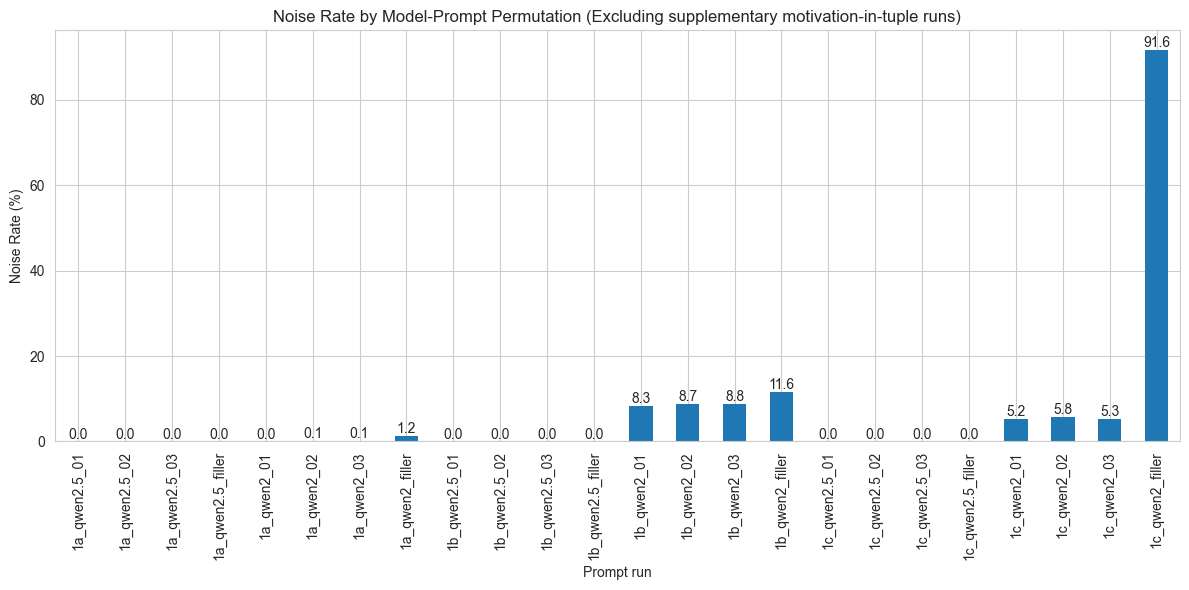

In [92]:
# Visualize label mismatches

# Get the value counts for the 'column'
column_counts = noise_log_no_tuple['column'].value_counts()

# Rename columns for clarity
rename_map = {'shot_scale_vlm_1a_01': '1a_qwen2.5_01',
              'shot_scale_vlm_1a_02': '1a_qwen2.5_02',
              'shot_scale_vlm_1a_03': '1a_qwen2.5_03',
              'shot_scale_vlm_1a_05_filler': '1a_qwen2.5_filler',

              'shot_scale_vlm_1a_06': '1a_qwen2_01',
              'shot_scale_vlm_1a_07': '1a_qwen2_02',
              'shot_scale_vlm_1a_08': '1a_qwen2_03',
              'shot_scale_vlm_1a_10_filler': '1a_qwen2_filler',

              'shot_scale_vlm_1b_01': '1b_qwen2.5_01',
              'shot_scale_vlm_1b_02': '1b_qwen2.5_02',
              'shot_scale_vlm_1b_03': '1b_qwen2.5_03',
              'shot_scale_vlm_1b_05_filler': '1b_qwen2.5_filler',

              'shot_scale_vlm_1b_06': '1b_qwen2_01',
              'shot_scale_vlm_1b_07': '1b_qwen2_02',
              'shot_scale_vlm_1b_08': '1b_qwen2_03',
              'shot_scale_vlm_1b_10_filler': '1b_qwen2_filler',

              'shot_scale_vlm_1c_01': '1c_qwen2.5_01',
              'shot_scale_vlm_1c_02': '1c_qwen2.5_02',
              'shot_scale_vlm_1c_03': '1c_qwen2.5_03',
              'shot_scale_vlm_1c_05_filler': '1c_qwen2.5_filler',

              'shot_scale_vlm_1c_06': '1c_qwen2_01',
              'shot_scale_vlm_1c_07': '1c_qwen2_02',
              'shot_scale_vlm_1c_08': '1c_qwen2_03',
              'shot_scale_vlm_1c_10_filler': '1c_qwen2_filler',
              }

# If a certain column has zero errors, add to column counts
for key in rename_map.keys():
    if key not in column_counts.index:
        column_counts[key] = 0

# Define the order of the columns if needed.
order = list(rename_map.keys()) # Initialize as None. Assign a list if you want a specific order.

# Apply renaming
if rename_map:
    column_counts.index = column_counts.index.map(rename_map)

# Apply ordering by reindexing
if order:
    # Map the original order keys to the renamed keys
    renamed_order = [rename_map.get(key, key) for key in order if key in rename_map.keys()]
    column_counts = column_counts.reindex(renamed_order)

# Change to % of total len of scenes
total = len(df_main)

# Convert counts to percentages
percentage_counts = (column_counts / total) * 100

# Create the bar graph
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
# ax = column_counts.plot(kind='bar') # Absolute count
ax = percentage_counts.plot(kind='bar',edgecolor="none") # Percentage

# Add annotations to each bar
for p in ax.patches: # Either annotate absolute or %
    # {int(p.get_height())}
    # {p.get_height():.1f}%
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('Noise Rate by Model-Prompt Permutation (Excluding supplementary motivation-in-tuple runs)')
plt.xlabel('Prompt run')
plt.ylabel('Noise Rate (%)')
# plt.grid(False)
plt.xticks(rotation=90) # Rotate labels for better readability
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_noise_rate.svg'), dpi=300)
plt.show()

**Key insights**
1. Qwen2.5-VL as the newer model does not produce outputs outside of the label constraints. Only Qwen2 deviates from the label list.
2. For the main prompt runs (01-03), prompt 1b which shorthanded the labels, appeared to create relatively greater noise. This is perhaps due to the inherent greater fragility of Qwen2, being sensitive to definitions and the prompt structure.
3. However, the filler supplementary run which excludes the "uncertain" option inexplicably triggers greater noise for all prompt variations. This was dramatically the case for prompt 1C where most annotations started with "The shot scale of this still image is...", even though the main prompt runs did not exhibit this behaviour.


In [69]:
noise_log[noise_log['column'] == 'shot_scale_vlm_1c_10_filler']

id                       column  \
0      7357772207445134608.mp4_scene_1  shot_scale_vlm_1c_10_filler   
2      7357772207445134608.mp4_scene_2  shot_scale_vlm_1c_10_filler   
6      7357772207445134608.mp4_scene_3  shot_scale_vlm_1c_10_filler   
7      7357772207445134608.mp4_scene_4  shot_scale_vlm_1c_10_filler   
8      7357772207445134608.mp4_scene_6  shot_scale_vlm_1c_10_filler   
...                                ...                          ...   
2498  7287823285566426369.mp4_scene_12  shot_scale_vlm_1c_10_filler   
2499  7287823285566426369.mp4_scene_13  shot_scale_vlm_1c_10_filler   
2506  7287823285566426369.mp4_scene_14  shot_scale_vlm_1c_10_filler   
2507  7287823285566426369.mp4_scene_15  shot_scale_vlm_1c_10_filler   
2508   7287537715829148930.mp4_scene_1  shot_scale_vlm_1c_10_filler   

                                             annotation     noise_type  
0     The shot scale of this still image is a "Close...  Invalid label  
2     The shot scale of this still image is 'Wide sh...  Invalid label  
6        The shot scale of this still image is "Empty".  Invalid label  
7     The shot scale of this still image is "Close up".  Invalid label  
8     The shot scale of this still image is "Close up".  Invalid label  
...                                                 ...            ...  
2498  The shot scale of this still image is a Medium...  Invalid label  
2499  The shot scale of this still image is "Medium ...  Invalid label  
2506  The shot scale of this still image is 'Medium ...  Invalid label  
2507  The shot scale of this still image is a Close up.  Invalid label  
2508  The shot scale of this still image is a Close up.  Invalid label  

[1321 rows x 4 columns]

In [41]:
# Print labels that do not align with the allowed labels (1C only)

col_list = ['shot_scale_vlm_1c_06', 'shot_scale_vlm_1c_07', 'shot_scale_vlm_1c_08', 'shot_scale_vlm_1c_10_filler']

full_labels = list(shot_scale_refactor.keys())
allowed_labels = full_labels + short_hand_labels

# Generate print of invalid labels
for col in col_list:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on allowed_labels
    value_counts = df_analysis_noise[col].value_counts()
    filtered_counts = value_counts[~value_counts.index.isin(allowed_labels)]
    print(filtered_counts)
    print()


Value counts for column: shot_scale_vlm_1c_06
shot_scale_vlm_1c_06
Uncertain.                                            31
Medium shot.                                          30
Medium full shot.                                      8
Wide shot.                                             3
Close up.                                              1
Empty.                                                 1
The shot scale of this still image is "Wide shot".     1
Name: count, dtype: int64


Value counts for column: shot_scale_vlm_1c_07
shot_scale_vlm_1c_07
Medium shot.                                                                                                                             39
Uncertain.                                                                                                                               35
Wide shot.                                                                                                                                5
Medium full shot. 

In [42]:
df_analysis_noise['shot_scale_vlm_1c_10_filler'].value_counts()

shot_scale_vlm_1c_10_filler
The shot scale of this still image is "Close up".                                                                                                                                                                                                         122
The shot scale of this still image is a Close up.                                                                                                                                                                                                         115
The shot scale of this still image is 'Wide shot'.                                                                                                                                                                                                         86
Medium shot                                                                                                                                                                                                       

Going through each prompt variation, below is a summary of the noise generated by Qwen2
1. Prompt 1a
    *   Minor but infrequent additions of periods after the label
    *   Verbose responses, both in terms of "breaking down" in response to a collage, as well as unnecessarily verbose returns to describe one label.

2. Prompt 1b
    *   Frequent inclusion of the full label name in parantheses (WS (Wide Shot))
    *   Verbose responses, both in terms of "breaking down" in response to a collage, as well as unnecessarily verbose returns to describe one label.

3. Prompt 1c
    *   Minor but frequent additions of periods after the label
    *   Filler prompt often starts with "The shot scale of this still image is..."


In [43]:
# Repeat for 1a and 1b
col_list = ['shot_scale_vlm_1a_06', 'shot_scale_vlm_1a_07', 'shot_scale_vlm_1a_08', 'shot_scale_vlm_1a_10_filler', 'shot_scale_vlm_1b_06', 'shot_scale_vlm_1b_07', 'shot_scale_vlm_1b_08', 'shot_scale_vlm_1b_10_filler']

full_labels = list(shot_scale_refactor.keys())

# Generate print of invalid labels for 1a
for col in col_list:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on full_labels
    value_counts = df_analysis_noise[col].value_counts()
    filtered_counts = value_counts[~value_counts.index.isin(full_labels)]
    print(filtered_counts)
    print()

# Generate print of invalid labels for 1b
for col in col_list:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on short_hand_labels
    value_counts = df_analysis_noise[col].value_counts()
    filtered_counts = value_counts[~value_counts.index.isin(short_hand_labels)]
    print(filtered_counts)
    print()


Value counts for column: shot_scale_vlm_1a_06
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_07
shot_scale_vlm_1a_07
Uncertain.    2
Name: count, dtype: int64


Value counts for column: shot_scale_vlm_1a_08
shot_scale_vlm_1a_08
Uncertain.    1
Name: count, dtype: int64


Value counts for column: shot_scale_vlm_1a_10_filler
shot_scale_vlm_1a_10_filler
The image is a Close up shot.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Moving on to the tuple responses, we can observe to what extent do VLMs adhere to requests to provide responses in a structured format.

In [86]:
# Filter noise log for tuple
noise_log_tuple = noise_log[noise_log['column'].str.contains("tuple")]
noise_log_tuple

id                      column  \
1      7357772207445134608.mp4_scene_2  shot_scale_vlm_1c_09_tuple   
15     7357772207445134608.mp4_scene_9  shot_scale_vlm_1c_09_tuple   
17    7357772207445134608.mp4_scene_10  shot_scale_vlm_1c_09_tuple   
22    7357772207445134608.mp4_scene_13  shot_scale_vlm_1c_09_tuple   
29    7357772207445134608.mp4_scene_19  shot_scale_vlm_1a_09_tuple   
...                                ...                         ...   
2484   7287823285566426369.mp4_scene_8  shot_scale_vlm_1b_09_tuple   
2489  7287823285566426369.mp4_scene_10  shot_scale_vlm_1b_09_tuple   
2492  7287823285566426369.mp4_scene_10  shot_scale_vlm_1c_09_tuple   
2501  7287823285566426369.mp4_scene_14  shot_scale_vlm_1a_09_tuple   
2505  7287823285566426369.mp4_scene_14  shot_scale_vlm_1c_09_tuple   

                                             annotation          noise_type  
1     (Uncertain, Motivation: The image appears to b...  Tuple format error  
15    (Uncertain, Motivation: The image appears to b...  Tuple format error  
17    ('Medium full shot', 'The subject (missiles) t...  Tuple format error  
22    (Uncertain, 'Motivation') - The provided image...  Tuple format error  
29    ('Uncertain', 'The image appears to be a still...  Tuple format error  
...                                                 ...                 ...  
2484  ('WS', 'The shot captures the vehicle and its ...  Tuple format error  
2489  ('uncertain', 'The image appears to be a close...  Tuple format error  
2492  (Uncertain, 'Motivation') - The image appears ...  Tuple format error  
2501  ('Uncertain', 'The image appears to be a close...  Tuple format error  
2505  (Uncertain, 'Motivation') - The image appears ...  Tuple format error  

[394 rows x 4 columns]

In [87]:
noise_log_tuple[['column','noise_type']].value_counts()

column                      noise_type          
shot_scale_vlm_1c_09_tuple  Tuple format error      233
shot_scale_vlm_1b_09_tuple  Tuple format error       57
                            Invalid label            51
shot_scale_vlm_1a_09_tuple  Tuple format error       26
                            Motivation too short     14
shot_scale_vlm_1b_09_tuple  Motivation too short      6
shot_scale_vlm_1c_04_tuple  Tuple format error        4
shot_scale_vlm_1a_04_tuple  Tuple format error        2
shot_scale_vlm_1b_04_tuple  Tuple format error        1
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

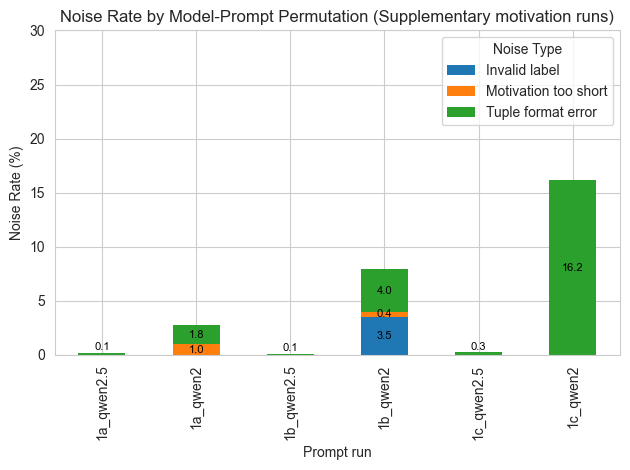

In [96]:
# Visualize tuple errors

# Get the value counts for the 'column' and 'noise_type'
column_noise_counts = noise_log_tuple.groupby(['column', 'noise_type']).size().unstack(fill_value=0)

# Rename columns for clarity
rename_map = {'shot_scale_vlm_1a_04_tuple': '1a_qwen2.5',
              'shot_scale_vlm_1a_09_tuple': '1a_qwen2',
              'shot_scale_vlm_1b_04_tuple': '1b_qwen2.5',
              'shot_scale_vlm_1b_09_tuple': '1b_qwen2',
              'shot_scale_vlm_1c_04_tuple': '1c_qwen2.5',
              'shot_scale_vlm_1c_09_tuple': '1c_qwen2',
              }

# If a certain column has zero errors, add to column counts (This part might need adjustment if a column has no errors at all)
# A better approach is to ensure all possible columns from rename_map are present in the DataFrame
all_columns = list(rename_map.keys())
column_noise_counts = column_noise_counts.reindex(all_columns, fill_value=0)

# Define the order of the columns
order = list(rename_map.keys())

# Apply renaming
if rename_map:
    column_noise_counts.index = column_noise_counts.index.map(rename_map)

# Apply ordering by reindexing
if order:
    renamed_order = [rename_map.get(key, key) for key in order]
    column_noise_counts = column_noise_counts.reindex(renamed_order)

# Change to % of total len of scenes
total = len(df_main)

# Convert counts to percentages
percentage_counts = (column_noise_counts / total) * 100

# Create the stacked bar graph
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
ax = percentage_counts.plot(kind='bar', stacked=True, edgecolor='none')

# Add annotations to each bar segment
for container in ax.containers:
    for patch in container.patches:
        height = patch.get_height()
        if height > 0.3: # Only annotate segments with height > 0
            ax.annotate(f'{height:.1f}',
                        (patch.get_x() + patch.get_width() / 2., patch.get_y() + height / 2.),
                        ha='center', va='center',
                        color='black', fontsize=8, xytext=(0, 0), textcoords='offset points')
        elif height > 0:
            ax.annotate(f'{height:.1f}',
                        (patch.get_x() + patch.get_width() / 2., patch.get_y() + height / 2.),
                        ha='center', va='center',
                        color='black', fontsize=8, xytext=(0, 5), textcoords='offset points')

plt.title('Noise Rate by Model-Prompt Permutation (Supplementary motivation runs)')
plt.xlabel('Prompt run')
plt.ylabel('Noise Rate (%)')
plt.ylim(0,30)
#plt.grid(False)
plt.xticks(rotation=90) # Rotate labels for better readability
plt.legend(title='Noise Type') # Add a legend for noise types
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_tuple_noise_rate_stacked.svg'), dpi=300)
plt.show()

Similarly, Qwen2-VL consistently struggles relatively more to output valid tuples and motivations, although now Qwen2.5-VL had a few errors. Most of these errors were minor format issues, such as missing closing quotemarks or parantheses. However, Qwen2-VL distinctly produced more noise for prompt 1C where research context was added. For many of its outputs, it placed the motivation *outside* of the tuple.

> 	(Uncertain, 'Motivation') - The image appears to be an aerial view of a landscape with text overlaid on it. It does not show any discernible subject or focus within the frame, making it difficult to classify as one of the shot scales provided.

The fact that it consistently breaks more often with 1C perhaps suggests that weaker models may struggle with longer prompts.

Qwen2.5 (runs 01-05) also raised uncharacteristic verbose noise when it generated additional text after the tuple.



> `('Wide shot', 'The image shows rockets being fired into the sky with a clear view of their trajectory and the surrounding environment, indicating that the subject (the rockets) is fully visible within the frame but the background dominates more than in a full shot.')`
>
> `This classification is based on the fact that the rockets are clearly visible and dominate the foreground, while the background elements such as the sky and clouds provide context. The rockets themselves are not the only focus of the image; they are part of a larger scene with significant environmental detail."`



> `('Medium full shot', 'The subjects are framed from the knees up and fully visible, with their upper bodies taking a significant portion of the frame but not dominating it as much as a close-up would.')`
>
> `This classification is based on the fact that both individuals in the image are fully visible from the knees up, which aligns with the definition of a medium full shot. The subjects' upper bodies take up a considerable amount of space within the frame without being so dominant as to classify them as a close-up or full shot.`

In [70]:
# Output interim noise log
noise_log.to_csv(os.path.join(data_output, 'idf_vlm_noise_log.csv'), index=False)

In [71]:
# Output interim tuple error log
tuple_error_log.to_csv(os.path.join(data_output, 'idf_vlm_tuple_error_log.csv'), index=False)

In [72]:
# Output noise analysis
df_analysis_noise.to_csv(os.path.join(data_output, '02_idf_data_shot_scale_vlm_noise.csv'), index=False)

In [54]:
df_analysis_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Columns: 108 entries, id to shot_scale_vlm_1c_10_noise
dtypes: float64(1), int64(9), object(98)
memory usage: 1.2+ MB


In [26]:
# Make a copy of df_analysis_noise for cleaning and refactoring
df_noise = df_analysis_noise.copy()

### Clean out noise and refactor shorthands

Now that we are done analyzing noise, we can properly clean them out and refactor the shorthanded labels.

In [25]:
shot_scale_cols = [col for col in df_noise.columns if col[:-5] == 'shot_scale_vlm_' or 'filler' in col]
shot_scale_cols.sort()

full_labels = list(shot_scale_refactor.keys())
allowed_labels = full_labels + short_hand_labels

# Generate print of invalid labels
for col in shot_scale_cols:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on allowed_labels
    value_counts = df_noise[col].value_counts()
    filtered_counts = value_counts[~value_counts.index.isin(allowed_labels)]
    print(filtered_counts)
    print()



Value counts for column: shot_scale_vlm_1a_01
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_02
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_03
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_04
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_05_filler
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_06
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_07
shot_scale_vlm_1a_07
Uncertain.    2
Name: count, dtype: int64


Value counts for column: shot_scale_vlm_1a_08
shot_scale_vlm_1a_08
Uncertain.    1
Name: count, dtype: int64


Value counts for column: shot_scale_vlm_1a_09
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_10_filler
shot_scale_vlm_1a_10_filler
The image is a Close up shot.                                                          

An excessive list of noise! While most of them are minor format errors (such as the ordering of labels), the most troublesome to clean are verbose prompts.

In these moments, we observe that Qwen2 particularly "acted out" when presented with a collage. This was an edge case that I failed to consider. During human coding, we decided that collages should be read based on the most recurring shot scale. However, the definitions and prompt was not updated to  In the interim for these cases, we will place them as `Uncertain` if there's no agreement between the scenes.

We will clean them one group at a time.

In [59]:
len("The shot scale of this still image is 'Medium close up'. The subject")

68

In [28]:
# Select noise columns (Boolean if its in the list)
noise_cols = [col for col in df_noise.columns if 'noise' in col]
noise_cols.sort()

# Loop through each scene

# Instantiate cleaned dataset to be updated without overwriting df_noise
df_clean = df_noise.copy()
for i, scene in df_noise.iterrows():

    # Loop through all the Noise boolean columns for a check
    for noise_col in noise_cols:
        if not scene[noise_col]: # If noise == False (ie matches constrains)
            continue
        else:
            # Obtain the column name with annotations
            anno_col = noise_col[:-6]
            if "05" in anno_col or "10" in anno_col: # Edit filler columns
                anno_col = anno_col + "_filler"
        annotation = scene[anno_col]
        # Hard coded cleaning...

        # Step 1: Dictionary method (Only for 1b)
        error_dict = {"WS (Wide Shot)": "WS",
                      "FS (Full Shot)": "FS",
                      "MFS (Medium Full Shot)": "MFS",
                      "MS (Medium Shot)": "MS",
                      "MCU (Medium Close Up)": "MCU",
                      "CU (Close-Up)": "CU",
                      "Medium Shot" : "MS",
                      "Medium Close-Up" : "MCU",
                      "Full Shot": "FS"
                      }

        valid_full_labels = ['Close up', 'Medium close up', 'Medium shot', 'Medium full shot', 'Full shot', 'Wide shot', 'Empty', 'Uncertain']

        # Clean additional periods
        if annotation[-1] == ".":
            annotation = annotation[:-1]

        # May just be tuple errors without label errors
        if annotation in valid_full_labels and ("1a" in anno_col or "1c" in anno_col):
            df_clean.at[i, anno_col] = annotation
            continue

        short_hand_labels = ['Empty', 'WS', 'FS', 'MFS', 'MS', 'MCU', 'CU', 'Uncertain']

        if annotation in short_hand_labels and "1b" in anno_col:
            df_clean.at[i, anno_col] = annotation
            continue

        elif annotation in error_dict.keys() and "1b" in anno_col:
            anno_cleaned = error_dict[annotation]
            # Update annotation
            df_clean.at[i, anno_col] = anno_cleaned
            continue

        elif pd.isna(annotation): # Check for the one NaN annotation
            df_clean.at[i, anno_col] = "Uncertain"
            continue

        elif annotation == "Empty" or annotation == "Uncertain":
            # Annotation raised as noise as motivation is too short
            continue

        elif annotation.startswith("The shot scale of this still image is"):
            # Slice the first 70 characters of the annotation so that it only catches the first label instance
            if len(annotation) > 70:
                annotation = annotation[:70]

            # loop through valid_full_labels for a match
            for label in valid_full_labels:
                if label.lower() in annotation.lower():
                    anno_cleaned = label
                    # Update annotation
                    df_clean.at[i, anno_col] = anno_cleaned
                    # Found match, break loop cycle
                    break
            continue

        # Dealing with verbose outputs. We want to separate those that detected collages from those that detected only a single shot

        else:
            # print(f"Remainder error: \n{annotation}")
            if "1a" in anno_col or "1c" in anno_col:
                # Hard coded list to search
                label_list = ['Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up', 'Close-up']
                label_count = 0

                # Final check as these maybe the tuple errors that actually have clean labels
                if annotation in label_list:
                    anno_cleaned = annotation
                    df_clean.at[i, anno_col] = anno_cleaned
                    continue

                # medium shot was being found in medium full shot, so this needed to be removed first to avoid being flagged multiple times
                if annotation.lower() == "medium full shot":
                    anno_cleaned = "Medium full shot"
                    df_clean.at[i, anno_col] = anno_cleaned
                    continue

                for key in label_list:
                    if key.lower() in annotation.lower():
                        label_count += 1
                if label_count == 1:
                    # print(f"Remainder error (1): \n{annotation}")
                    anno_cleaned = key
                    if anno_cleaned == 'Close-up':
                        anno_cleaned = 'Close up'
                    # Update annotation
                    df_clean.at[i, anno_col] = anno_cleaned
                    continue
                elif label_count > 1: # Handle instances with multiple labels detected
                    print(f"Multiple labels ({label_count}) detected 'Uncertain' filled: \n{annotation}\n")
                    df_clean.at[i, anno_col] = "Uncertain"
                else:
                    print(f"No valid label detected; Replaced with 'Uncertain': \n{annotation}\n")
                    anno_cleaned = "Uncertain"
                    df_clean.at[i, anno_col] = "Uncertain"
                    continue

            elif "1b" in anno_col:
                # Hard coded dictionary to search and filter
                label_dict = {#'Empty': 'Empty',
                              'Wide Shot (WS)': 'WS',
                              'WS (Wide Shot)': 'WS',
                              'WS (Wide Shots)': 'WS',
                              'Full Shot (FS)': 'FS',
                              'Medium Full Shot (MFS)': 'MFS',
                              'Medium Shot (MS)': 'MS',
                              '"Medium Shot" (MS)': 'MS',
                              'MS (Medium Shot)': 'MS',
                              '"Medium Close-Up" (MCU)': 'MCU',
                              'Medium Close-Up (MCU)': 'MCU',
                              'MCU (Medium Close-Up)': 'MCU',
                              'Close-Up (CU)': 'CU',
                              'CU (Close-Up)': 'CU',
                              'close-up shot (CU)': 'CU',
                              'close-ups (CU)': 'CU',
                              }


                label_count = 0
                for key in label_dict.keys(): # Opposite search to parse verbose
                    if key.lower() in annotation.lower():
                        label_count += 1
                if label_count == 1:
                    # If only one label is matched, means that there's only one type of shot scale, meaning it can be used
                    anno_cleaned = label_dict[key]
                    # Update annotation
                    df_clean.at[i, anno_col] = anno_cleaned

                # Conflicting entries likely due to collage shot; Return 'Uncertain'
                elif label_count > 1:
                    print(f"Multiple labels ({label_count}) detected 'Uncertain' filled: \n{annotation}\n")
                    df_clean.at[i, anno_col] = "Uncertain"

                else:
                    print(f"No valid label detected; Replaced with 'Uncertain': \n{annotation} ({scene['id']}: {anno_col})\n")
                    anno_cleaned = "Uncertain"
                    df_clean.at[i, anno_col] = "Uncertain"
                    continue

                # Note: If the 'filler' column cannot patch Uncertain entries due to it being 'Uncertain' itself, the video will be dropped from analysis
            else:
                print("Error: Edge case")

Multiple labels (2) detected 'Uncertain' filled: 
The image contains a combination of different shot scales:

1. The top left image is an Empty shot, as it shows the setting with no discernible subject.
2. The bottom right image is a CU (Close-Up), focusing on the person's face and upper body.
3. The middle right image is a MS (Medium Shot), showing the person from the waist up.

Therefore, the overall shot scale of this image can be classified as a combination of Empty, CU, and MS

Multiple labels (2) detected 'Uncertain' filled: 
The top image is a Medium shot, as it shows the subject from the waist up and captures most of the frame. The bottom image is a Wide shot, as the subject is in full view with the background dominating them

Multiple labels (2) detected 'Uncertain' filled: 
The image contains a person in the foreground with a wide shot (WS) of another person in the background, showing them from head to toe. Therefore, the shot scale for this image is:

- WS (Wide Shot)

Multi

These remainder errors are all confused by collages. Therefore we will insert "Uncertain".

In [29]:
# Check for remaining errors in df_clean; This should now return blank series

for col in shot_scale_cols:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on allowed_labels
    value_counts = df_clean[col].value_counts()
    filtered_counts = value_counts[~value_counts.index.isin(allowed_labels)]
    print(filtered_counts)
    print()


Value counts for column: shot_scale_vlm_1a_01
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_02
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_03
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_04
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_05_filler
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_06
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_07
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_08
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_09
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1a_10_filler
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm_1b_01
Series([], Name: count, dtype: int64)


Value counts for column: shot_scale_vlm

In [39]:
df_clean.to_csv(os.path.join(data_output, '03_idf_data_shot_scale_vlm_clean.csv'), index=False)

In [40]:
df_clean = pd.read_csv(os.path.join(data_output, '03_idf_data_shot_scale_vlm_clean.csv'))

In [32]:
# Expand shorthands for 1b in full

cols_1b = [col for col in df_clean.columns if col[-5:-3] == "1b" or (col[15:17] == "1b" and "filler" in col)]

short_hand_mapping = {
    'Empty': 'Empty',
    'WS': 'Wide shot',
    'FS': 'Full shot',
    'MFS': 'Medium full shot',
    'MS': 'Medium shot',
    'MCU': 'Medium close up',
    'CU': 'Close up',
    'Uncertain': 'Uncertain'
}

for col in cols_1b:
    df_clean[col] = df_clean[col].map(short_hand_mapping)

In [35]:
# Check for refactored labels
for col in cols_1b:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on allowed_labels
    value_counts = df_clean[col].value_counts()
    print(value_counts)


Value counts for column: shot_scale_vlm_1b_01
shot_scale_vlm_1b_01
Medium close up    1071
Wide shot           196
Empty               106
Close up             59
Uncertain             7
Medium shot           3
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1b_02
shot_scale_vlm_1b_02
Medium close up    1072
Wide shot           200
Empty               105
Close up             54
Uncertain            10
Medium shot           1
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1b_03
shot_scale_vlm_1b_03
Medium close up    1071
Wide shot           202
Empty               102
Close up             55
Uncertain            10
Medium shot           2
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1b_05_filler
shot_scale_vlm_1b_05_filler
Medium close up     1083
Empty                170
Wide shot            146
Close up              20
Medium shot           20
Medium full shot       3
Name: count, dtype: int64

Value counts for column: sh

In [36]:
# Check labels and distribution for all prompt runs
vlm_annotation_cols = [col for col in df_clean.columns if col[:-5] == "shot_scale_vlm_" or "filler" in col]

for col in vlm_annotation_cols:
    print(f"\nValue counts for column: {col}")
    # Get value counts and filter based on allowed_labels
    value_counts = df_clean[col].value_counts()
    print(value_counts)


Value counts for column: shot_scale_vlm_1a_01
shot_scale_vlm_1a_01
Close up            646
Medium shot         286
Medium close up     216
Wide shot           114
Uncertain            98
Empty                79
Medium full shot      3
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1a_02
shot_scale_vlm_1a_02
Close up            635
Medium shot         290
Medium close up     221
Wide shot           112
Uncertain           102
Empty                77
Medium full shot      4
Full shot             1
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1a_03
shot_scale_vlm_1a_03
Close up            643
Medium shot         290
Medium close up     215
Wide shot           115
Uncertain            92
Empty                83
Medium full shot      3
Full shot             1
Name: count, dtype: int64

Value counts for column: shot_scale_vlm_1a_05_filler
shot_scale_vlm_1a_05_filler
Close up            564
Medium close up     338
Medium shot         286
Empty       

In [37]:
# Remove columns no longer needed
valid_cols = [col for col in df_clean.columns if "noise" not in col and "tuple" not in col]
df_clean = df_clean[valid_cols].copy()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442 entries, 0 to 1441
Data columns (total 72 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               1442 non-null   object 
 1   url                              1442 non-null   int64  
 2   start_frame                      1442 non-null   int64  
 3   start_time                       1442 non-null   object 
 4   end_frame                        1442 non-null   int64  
 5   end_time                         1442 non-null   object 
 6   end_fps                          1442 non-null   float64
 7   scene_num                        1442 non-null   int64  
 8   num_scenes_detected              1442 non-null   int64  
 9   total_video_frames               1442 non-null   int64  
 10  total_video_duration             1442 non-null   object 
 11  face_locations_list              1442 non-null   object 
 12  face_count          

In [43]:
df_clean.to_csv(os.path.join(data_output, '04_idf_data_shot_scale_vlm_normalized.csv'), index=False)


## Stability analysis
- Calculating intra-prompt stability (Between the three main runs)
- Calculating inter-prompt stabilty (Between prompt perturbations)

In [3]:
df_norm = pd.read_csv(os.path.join(data_output, '04_idf_data_shot_scale_vlm_normalized.csv'))

### Intra-prompt stability
Both Krippendorff Alpha (ordinal) which excludes 'Uncertain' and Krippendorff Alpha (nominal) which includes 'Uncertain' will be calculated between exact runs of the same prompt (eg 1a_01, 1a_02, 1a_03).

#### Functions to calculate K-Alpha in shot scale

While shot scale is ordinally structured, the availability of an "Uncertain" option disrupts this structure. Therefore, both variations are accomodated and calculated. This allows us to analyze agreement accurate to its ordinal data structure and observe its stability in terms of being able to return labels close to each other, as well as stricter agreement based on how consistently it returns the same result (including "uncertain" responses).


In [143]:
def calc_k_alpha_shot_scale_ord(df, col_list):

    """
    Calculates Krippendorff's Alpha (for ordinal variables) for shot scale annotations. It converts 'Uncertain' to NaN.

    This function takes a df and a list of column names containing
    shot scale annotations as input and calculates K Alpha.

    Args:
        df (pd.DataFrame): The input DataFrame containing shot scale annotations.
        col_list (list): A list of column names in the DataFrame that contain
                         the shot scale annotations to be compared.

    Returns:
        tuple: A tuple containing:
            - alpha (float): The calculated Krippendorff's Alpha value.
            - rows_with_nan (int): The number of rows that contained at least
                                   one 'Uncertain' value (which were converted to NaN
                                   and excluded from the alpha calculation).
    """

    # Define ordinal scale for refactoring
    # Ordered from closest to further from the camera
    ordinal_scale = {
        'Close up': 1,
        'Medium close up': 2,
        'Medium shot': 3,
        'Medium full shot': 4,
        'Full shot' : 5,
        'Wide shot': 6,
        'Empty': 7,
        'Uncertain': np.nan, # Exclude NaN (NaN has to be excluded in ordinal scale or include as a separate category in nominal)
        }

    df_copy = df[col_list].copy() # Make copy of dataframe for refactoring; Only the desired columns

    # Check for values not in the ordinal_scale and replace with NaN
    for col in col_list:
        unmappable_values = df_copy[col][~df_copy[col].isin(ordinal_scale.keys())].unique()
        if len(unmappable_values) > 0:
            print(f"Warning: Unmappable values found in column '{col}' ({len(unmappable_values)}): \n{unmappable_values}. Replacing with NaN.")
            df_copy[col] = df_copy[col].replace(unmappable_values, np.nan)

    # Refactor
    for col in col_list:
        df_copy[col] = df_copy[col].map(ordinal_scale)

    # Count the number of rows with at least one NaN value in the specified columns
    rows_with_nan = df_copy[df_copy.isnull().any(axis=1)].shape[0]
    print(f"Number of rows with NaN values/'Uncertain' (excluded from calculation): {rows_with_nan}")

    # Transpose for krippendorff
    data_array = df_copy[col_list].to_numpy().T

    # Compute alpha
    alpha = krippendorff.alpha(reliability_data=data_array, level_of_measurement='ordinal')
    print(f"Krippendorff’s alpha (ordinal) for {col_list}: {alpha:.3f}")
    return alpha, rows_with_nan

def calc_k_alpha_shot_scale_nom(df, col_list):
    """
    Calculates Krippendorff's Alpha (for nominal variables) for shot scale annotations. It factors in the 'Uncertain' option but has to perform agreement analysis by treating shot scale labels as nominal categories.

    This function takes a df and a list of column names containing
    shot scale annotations as input and calculates K Alpha.

    Args:
        df (pd.DataFrame): The input DataFrame containing shot scale annotations.
        col_list (list): A list of column names in the DataFrame that contain
                         the shot scale annotations to be compared.

    Returns:
        tuple: A tuple containing:
            - alpha (float): The calculated Krippendorff's Alpha value.

    """
    # Define nominal scale for refactoring
    # Ordered from closest to further from the camera
    nominal_labels = {
        'Close up': 1,
        'Medium close up': 2,
        'Medium shot': 3,
        'Medium full shot': 4,
        'Full shot' : 5,
        'Wide shot': 6,
        'Empty': 7,
        'Uncertain': 8 # If Uncertain is to be included
        }

    df_copy = df[col_list].copy() # Make copy of dataframe for refactoring

    # Check for values not in the nominal_labels and replace with NaN
    for col in col_list:
        unmappable_values = df_copy[col][~df_copy[col].isin(nominal_labels.keys())].unique()
        if len(unmappable_values) > 0:
            print(f"Warning: Unmappable values found in column '{col}' ({len(unmappable_values)}): \n{unmappable_values}. Replacing with NaN.")
            df_copy[col] = df_copy[col].replace(unmappable_values, np.nan)

    # Refactor
    for col in col_list:
        df_copy[col] = df_copy[col].map(nominal_labels)

    # Transpose for krippendorff
    data_array = df_copy[col_list].to_numpy().T

    # Compute alpha
    alpha = krippendorff.alpha(reliability_data=data_array, level_of_measurement='nominal')
    print(f"Krippendorff’s alpha (nominal) for {col_list}: {alpha:.3f}\n")
    return alpha

In [144]:
# Grouped function
def calc_k_alpha_shot_scale_both(df, col_list):
    alpha_ord, rows_with_nan = calc_k_alpha_shot_scale_ord(df, col_list)
    alpha_nom = calc_k_alpha_shot_scale_nom(df, col_list)

    df_k_alpha = pd.DataFrame({'col_list': [col_list],
                               'alpha_ord': [alpha_ord],
                               'rows_with_nan': [rows_with_nan],
                               'alpha_nom': [alpha_nom], })

    return df_k_alpha


In [48]:
# Test on one set
test_cols = [col for col in df_norm.columns if "1a" in col and any(sub in col for sub in ["01", "02", "03"])]

df_k_alpha_test = calc_k_alpha_shot_scale_both(df_norm, test_cols)
df_k_alpha_test

Number of rows with NaN values/'Uncertain' (excluded from calculation): 114
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']: 0.957
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']: 0.883



col_list  alpha_ord  \
0  [shot_scale_vlm_1a_01, shot_scale_vlm_1a_02, s...   0.956861   

   rows_with_nan  alpha_nom  
0            114   0.883105

In [145]:
# Run in full
prompt_grps = ["1a",
                "1b",
                 "1c"
                 ]
model_runs = {'qwen2.5-vl-7b-instruct': ["01", "02", "03"],
              'qwen2-vl-7b-instruct': ["06", "07", "08"],
               }

# Instantiate df_k_alpha to collect alpha information
df_k_alpha = pd.DataFrame({
    'model_name': pd.Series(dtype='object'),
    'prompt': pd.Series(dtype='object'),
    'col_list': pd.Series(dtype='object'),
    'alpha_ord': pd.Series(dtype='float'),
    'rows_with_nan': pd.Series(dtype='int'),
    'alpha_nom': pd.Series(dtype='float')
})


# Loop through all permutations
for prompt in prompt_grps:
    for model_name in model_runs.keys():
        # Assign run group list
        run_grp = model_runs[model_name]

        # Retrieve column list
        col_list = [col for col in df_norm.columns if prompt in col and any(sub in col for sub in run_grp)]
        k_alpha_results = calc_k_alpha_shot_scale_both(df_norm, col_list)
        k_alpha_results['model_name'] = model_name
        k_alpha_results['prompt'] = prompt

        # Add to result
        df_k_alpha = pd.concat([df_k_alpha, k_alpha_results], ignore_index=True)

df_k_alpha

Number of rows with NaN values/'Uncertain' (excluded from calculation): 114
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']: 0.957
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']: 0.883

Number of rows with NaN values/'Uncertain' (excluded from calculation): 64
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_06', 'shot_scale_vlm_1a_07', 'shot_scale_vlm_1a_08']: 0.892
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_06', 'shot_scale_vlm_1a_07', 'shot_scale_vlm_1a_08']: 0.764

Number of rows with NaN values/'Uncertain' (excluded from calculation): 12
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1b_01', 'shot_scale_vlm_1b_02', 'shot_scale_vlm_1b_03']: 0.970
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1b_01', 'shot_scale_vlm_1b_02', 'shot_scale_vlm_1b_03']: 0.941

Number of rows with NaN values/'Uncertain' (excluded from calculation): 7
Krippen

model_name prompt  \
0  qwen2.5-vl-7b-instruct     1a   
1    qwen2-vl-7b-instruct     1a   
2  qwen2.5-vl-7b-instruct     1b   
3    qwen2-vl-7b-instruct     1b   
4  qwen2.5-vl-7b-instruct     1c   
5    qwen2-vl-7b-instruct     1c   

                                                             col_list  \
0  [shot_scale_vlm_1a_01, shot_scale_vlm_1a_02, shot_scale_vlm_1a_03]   
1  [shot_scale_vlm_1a_06, shot_scale_vlm_1a_07, shot_scale_vlm_1a_08]   
2  [shot_scale_vlm_1b_01, shot_scale_vlm_1b_02, shot_scale_vlm_1b_03]   
3  [shot_scale_vlm_1b_06, shot_scale_vlm_1b_07, shot_scale_vlm_1b_08]   
4  [shot_scale_vlm_1c_01, shot_scale_vlm_1c_02, shot_scale_vlm_1c_03]   
5  [shot_scale_vlm_1c_06, shot_scale_vlm_1c_07, shot_scale_vlm_1c_08]   

   alpha_ord  rows_with_nan  alpha_nom  
0   0.956861            114   0.883105  
1   0.891731             64   0.763551  
2   0.970109             12   0.940873  
3   0.930024              7   0.836172  
4   0.953187            161   0.889119  
5   0.872007             56   0.743496

In [146]:
# Export to csv
df_k_alpha.to_csv(os.path.join(data_output, 'idf_data_shot_scale_vlm_intraprompt_stability.csv'), index=False)

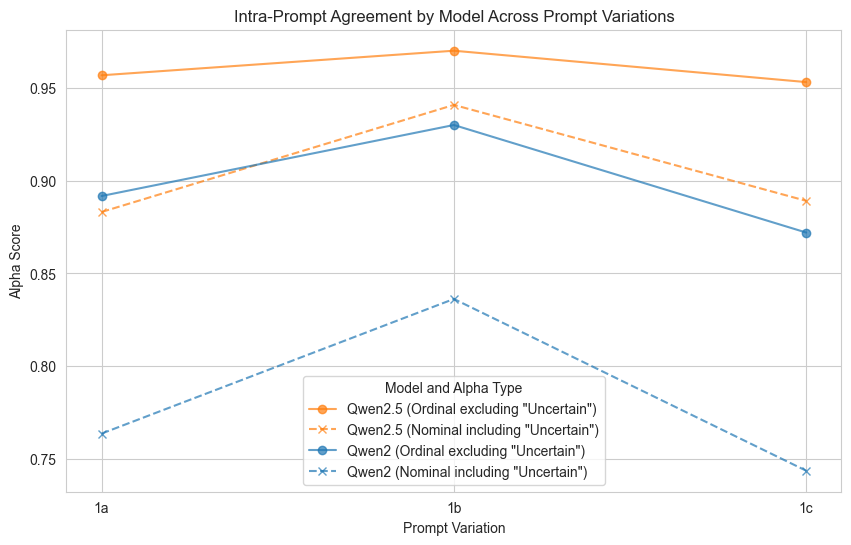

In [147]:
# Plot difference in Intraprompt stability

# Melt the DataFrame to have 'prompt', 'model_name', 'alpha_ord', 'alpha_nom'
df_k_alpha_melted = df_k_alpha.melt(
    id_vars=['model_name', 'prompt'],
    value_vars=['alpha_ord', 'alpha_nom'],
    var_name='alpha_type',
    value_name='alpha_value'
)

# Define colors for each model
model_colors = {
    'qwen2.5-vl-7b-instruct': 'tab:orange',
    'qwen2-vl-7b-instruct': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

for model in model_colors.keys():
    model_df = df_k_alpha_melted[df_k_alpha_melted['model_name'] == model]

    if model == 'qwen2.5-vl-7b-instruct':
        model_short = 'Qwen2.5'
    elif model == 'qwen2-vl-7b-instruct':
        model_short = 'Qwen2'
    # Plot ordinal alpha
    ordinal_df = model_df[model_df['alpha_type'] == 'alpha_ord']
    plt.plot(ordinal_df['prompt'], ordinal_df['alpha_value'], marker='o', linestyle='-', color=model_colors[model], label=f'{model_short} (Ordinal excluding "Uncertain")', alpha=0.7)

    # Plot nominal alpha
    nominal_df = model_df[model_df['alpha_type'] == 'alpha_nom']
    plt.plot(nominal_df['prompt'], nominal_df['alpha_value'], marker='x', linestyle='--', color=model_colors[model], label=f'{model_short} (Nominal including "Uncertain")', alpha=0.7)


plt.xlabel('Prompt Variation')
plt.ylabel('Alpha Score')
plt.title('Intra-Prompt Agreement by Model Across Prompt Variations')
plt.legend(title='Model and Alpha Type')
plt.grid(True)
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_intraprompt_stability.svg'), dpi=300, bbox_inches='tight')
plt.show()


In reliability evaluation, 0.8 and above is generally considered acceptable agreement. The numbers for nominal calculations are lower given that it treats all failures equally. Despite this, all prompt variations remain generally consistent within themselves.

Qwen2.5 in particular is rather consistent, demonstrating more than 0.95 intra-prompt stability between all three prompt runs when "Uncertain" entries were excluded.

### Inter-prompt stability


#### Aggregating results through a majority vote of three prompt runs
In order to calculate the inter-prompt stability, we need to first aggregate the results from the main three runs of each prompt-model permutation. We do this by obtaining the majority result (vote) of each permutation. If there is no majority result, 'Uncertain' will be assigned.

Given that the intra-prompt agreement was generally good, the majority vote could be said to be a reliable representation of the prompt variation.

In [10]:
# Define function to obtain the majority label between three columns
def majority_annotation(df, col_list, result_name):
    """
    Determines the majority annotation for each row across a list of columns.

    For each row in the input DataFrame, this function examines the values
    in the specified columns. It assigns the majority label among these
    columns as the result. If there is no clear majority (e.g., all three
    values are different), it assigns 'Uncertain'.

    Args:
        df (pd.DataFrame): The input DataFrame containing the annotation columns.
        col_list (list): A list of exactly three column names to analyze for the
                         majority annotation.
        result_name (str): The name of the new column to create in the output
                           DataFrame to store the majority annotation.

    Returns:
        pd.DataFrame: A DataFrame containing the original 'id' column and the
                      new column specified by 'result_name' with the majority
                      annotation for each row.
        uncertain_count (int): The number of rows where no majority could be
                               determined.
    """
    print(f'Calculating majority for {col_list}')

    # Check if the list size is exactly 3
    # If it's not, an AssertionError will be raised.
    assert len(col_list) == 3, f"Unexpected column size ({len(col_list)}). Expected 3 columns only."

    # Instantiate df_results to store results
    df_results = df[['id']].copy()
    # Add the new result column, initialized to None or a default value
    df_results[result_name] = None

    uncertain_count = 0
    # Loop row by row
    for i, scene in df.iterrows():
        # Obtain list of results
        results = [scene[col] for col in col_list]

        # Work out which is the most recurring result
        counts = {}
        for result in results:
            if pd.isna(result):
                print(f"Error: NaN value found at {scene['id']}")
                continue # Skip NaN values in counting
            counts[result] = counts.get(result, 0) + 1 # Count

        # Calculate majority
        if len(counts) == 1: # Clear majority, all three results are the same
              majority_label = list(counts.keys())[0]
        elif len(counts) == 2: # 2:1 ratio in vote
            # Iterate through the items to find the one with count 2
            for label, count in counts.items():
                if count == 2:
                    majority_label = label
                    break # Found the majority, no need to continue the loop

        elif len(counts) == 3: # All results are different; no majority
            # Therefore assign 'Uncertain'
            majority_label = 'Uncertain'
            print(f"No majority for {scene['id']}: {results}; Assigned: {majority_label}") # Debug print
            uncertain_count += 1

        else:
            print("Error: Unexpected result size! Please check code!")

        # Store results
        df_results.at[i, result_name] = majority_label

    print(f"Total of rows with no majority in {col_list}: {uncertain_count}\n")
    return df_results, uncertain_count

In [11]:
# Run on dataset
prompt_grps = ["1a",
                 "1b",
                 "1c"
                 ]
model_runs = {'qwen2.5-vl-7b-instruct': ["01", "02", "03"],
              'qwen2-vl-7b-instruct': ["06", "07", "08"],
               }
# Track uncertain aggregations
df_uncertain_agg_total = pd.DataFrame({
    'model_name': pd.Series(dtype='object'),
    'prompt': pd.Series(dtype='object'),
    'col_list': pd.Series(dtype='object'),
    'uncertain_count': pd.Series(dtype='int'),
})

for prompt in prompt_grps:
    for model_name in model_runs.keys():
        # Assign run group list
        run_grp = model_runs[model_name]

        # Retrieve column list
        col_list = [col for col in df_norm.columns if prompt in col and any(sub in col for sub in run_grp)]

        if model_name == 'qwen2.5-vl-7b-instruct':
            model_short = 'qwen2.5'
        elif model_name == 'qwen2-vl-7b-instruct':
            model_short = 'qwen2'
        result_column_name = f'shot_scale_vlm_{prompt}_{model_short}'

        df_result, uncertain_count = majority_annotation(df_norm, col_list, result_column_name)

        # Track uncertain aggregations
        df_uncertain_agg = pd.DataFrame({'model_name': [model_short],
                                         'prompt': [prompt],
                                         'col_list': [col_list],
                                         'uncertain_count': [uncertain_count]})
        df_uncertain_agg_total = pd.concat([df_uncertain_agg_total, df_uncertain_agg], ignore_index=True)

        df_norm = pd.merge(df_norm, df_result, on='id', how='left')

Calculating majority for ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']
No majority for 7413374980831874312.mp4_scene_2: ['Uncertain', 'Wide shot', 'Empty']; Assigned: Uncertain
No majority for 7397447925460241671.mp4_scene_6: ['Empty', 'Uncertain', 'Wide shot']; Assigned: Uncertain
No majority for 7315022331728989442.mp4_scene_15: ['Medium close up', 'Medium shot', 'Close up']; Assigned: Uncertain
No majority for 7307624697146068225.mp4_scene_59: ['Medium close up', 'Medium shot', 'Close up']; Assigned: Uncertain
No majority for 7304579698502192386.mp4_scene_21: ['Wide shot', 'Uncertain', 'Empty']; Assigned: Uncertain
Total of rows with no majority in ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03']: 5

Calculating majority for ['shot_scale_vlm_1a_06', 'shot_scale_vlm_1a_07', 'shot_scale_vlm_1a_08']
No majority for 7422680433990569234.mp4_scene_21: ['Medium close up', 'Close up', 'Medium shot']; Assigned: Uncertain
No majority for 7413

In [55]:
df_uncertain_agg_total

model_name prompt                                           col_list  \
0    qwen2.5     1a  [shot_scale_vlm_1a_01, shot_scale_vlm_1a_02, s...   
1      qwen2     1a  [shot_scale_vlm_1a_06, shot_scale_vlm_1a_07, s...   
2    qwen2.5     1b  [shot_scale_vlm_1b_01, shot_scale_vlm_1b_02, s...   
3      qwen2     1b  [shot_scale_vlm_1b_06, shot_scale_vlm_1b_07, s...   
4    qwen2.5     1c  [shot_scale_vlm_1c_01, shot_scale_vlm_1c_02, s...   
5      qwen2     1c  [shot_scale_vlm_1c_06, shot_scale_vlm_1c_07, s...   

   uncertain_count  
0                5  
1               26  
2                2  
3               11  
4                0  
5               24

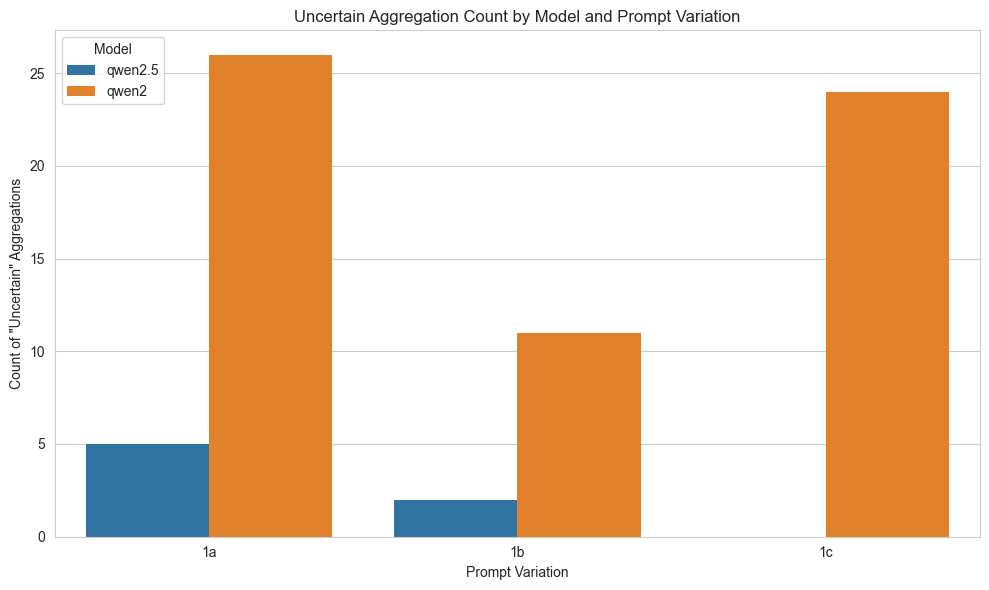

In [84]:
# Visualize count
plt.figure(figsize=(10, 6))
sns.barplot(data=df_uncertain_agg_total, x='prompt', y='uncertain_count', hue='model_name', edgecolor='none')

plt.title('Uncertain Aggregation Count by Model and Prompt Variation')
plt.xlabel('Prompt Variation')
plt.ylabel('Count of "Uncertain" Aggregations')
plt.legend(title='Model')
plt.tight_layout()
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_uncertain_aggregation_count.svg'), dpi=300)
plt.show()


Based on this, we can observe the number of scenes where all three main prompt runs returned a different result each time. We can observe that the number is higher for prompts ran by Qwen2 (06-08), validating earlier results that its intra prompt stability is lower.

In [12]:
df_norm

id                  url  start_frame  \
0      7357772207445134608.mp4_scene_1  7357772207445134608            0   
1      7357772207445134608.mp4_scene_2  7357772207445134608           61   
2      7357772207445134608.mp4_scene_3  7357772207445134608           83   
3      7357772207445134608.mp4_scene_4  7357772207445134608          121   
4      7357772207445134608.mp4_scene_5  7357772207445134608          221   
...                                ...                  ...          ...   
1437  7287823285566426369.mp4_scene_12  7287823285566426369          708   
1438  7287823285566426369.mp4_scene_13  7287823285566426369          760   
1439  7287823285566426369.mp4_scene_14  7287823285566426369          793   
1440  7287823285566426369.mp4_scene_15  7287823285566426369          854   
1441   7287537715829148930.mp4_scene_1  7287537715829148930            0   

                  start_time  end_frame                end_time  end_fps  \
0            0 days 00:00:00         61  0 days 00:00:02.033000    30.00   
1     0 days 00:00:02.033000         83  0 days 00:00:02.767000    30.00   
2     0 days 00:00:02.767000        121  0 days 00:00:04.033000    30.00   
3     0 days 00:00:04.033000        221  0 days 00:00:07.367000    30.00   
4     0 days 00:00:07.367000        229  0 days 00:00:07.633000    30.00   
...                      ...        ...                     ...      ...   
1437  0 days 00:00:23.624000        760  0 days 00:00:25.359000    29.97   
1438  0 days 00:00:25.359000        793  0 days 00:00:26.460000    29.97   
1439  0 days 00:00:26.460000        854  0 days 00:00:28.495000    29.97   
1440  0 days 00:00:28.495000       1212  0 days 00:00:40.440000    29.97   
1441         0 days 00:00:00        611  0 days 00:00:24.440000    25.00   

      scene_num  num_scenes_detected  total_video_frames  ...  \
0             1                   34                2126  ...   
1             2                   34                2126  ...   
2             3                   34                2126  ...   
3             4                   34                2126  ...   
4             5                   34                2126  ...   
...         ...                  ...                 ...  ...   
1437         12                   15                1212  ...   
1438         13                   15                1212  ...   
1439         14                   15                1212  ...   
1440         15                   15                1212  ...   
1441          1                    1                 611  ...   

     shot_scale_vlm_1c_04                    shot_scale_vlm_1c_04_motivation  \
0         Medium close up  The subject is framed from the chest up and ta...   
1               Wide shot  The subject (a structure) is fully visible wit...   
2                   Empty  The frame shows only text and no discernible s...   
3         Medium close up  The subject is framed from the chest up and ta...   
4                   Empty  The frame shows only the TikTok logo and handl...   
...                   ...                                                ...   
1437            Wide shot  The subject (helicopter) and soldiers are full...   
1438     Medium full shot  The subject is framed from the knees up and ap...   
1439     Medium full shot  The subject is framed from the knees up and ap...   
1440      Medium close up  The subject is framed from the chest up and ta...   
1441      Medium close up  The subject is framed from the chest up and ta...   

      shot_scale_vlm_1c_09                    shot_scale_vlm_1c_09_motivation  \
0          Medium close up  The subject is framed from the head up and tak...   
1                Uncertain  The image appears to be a wide shot with a red...   
2                    Empty  The image is completely black with no discerni...   
3          Medium close up  The subject is framed from the head up and tak...   
4                    Empty  The image is completely black with 

In [13]:
# Update csv
df_norm.to_csv(os.path.join(data_output, '04_idf_data_shot_scale_vlm_normalized.csv'), index=False)

#### Measure Inter-Prompt Stability
To measure the stability between prompts, we will use Krippendorff's Alpha again. In particular, we are interested in the agreement between prompt variation 1A and 1B, where 1B was contains perturbations in the form of introducing short hands.

**Prompt Variations**
- 1A: Base prompt
- 1B: Prompt perturbation by short-handing the shot scale labels
- 1C: Refined prompt format with added context and instruction text

In [60]:
# Run comparison
comparison_permutations = [["1a","1b"],
                           ["1a","1c"],
                           ["1b","1c"]
                           ]
model_names = {'qwen2.5': 'qwen2.5-vl-7b-instruct',
              'qwen2': 'qwen2-vl-7b-instruct',
               }

# Instantiate df_k_alpha to collect alpha information
df_interprompt_alpha = pd.DataFrame({
    'model_name': pd.Series(dtype='object'),
    'target_prompts': pd.Series(dtype='object'),
    'col_list': pd.Series(dtype='object'),
    'alpha_ord': pd.Series(dtype='float'),
    'rows_with_nan': pd.Series(dtype='int'),
    'alpha_nom': pd.Series(dtype='float')
})

# Loop through the necessary comparison permutations
for permutation in comparison_permutations:
    for model_name in model_names.keys():
        col_list = []
        for prompt in permutation:
            col_list.append(f'shot_scale_vlm_{prompt}_{model_name}')
        df_results = calc_k_alpha_shot_scale_both(df_norm, col_list)
        df_results['model_name'] = model_names[model_name]
        df_results['target_prompts'] = [permutation]
        df_interprompt_alpha = pd.concat([df_interprompt_alpha, df_results], ignore_index=True)

df_interprompt_alpha

Number of rows with NaN values/'Uncertain' (excluded from calculation): 103
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1b_qwen2.5']: 0.473
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1b_qwen2.5']: 0.046

Number of rows with NaN values/'Uncertain' (excluded from calculation): 82
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2', 'shot_scale_vlm_1b_qwen2']: 0.413
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_qwen2', 'shot_scale_vlm_1b_qwen2']: 0.075

Number of rows with NaN values/'Uncertain' (excluded from calculation): 158
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1c_qwen2.5']: 0.838
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1c_qwen2.5']: 0.655

Number of rows with NaN values/'Uncertain' (excluded from calculation): 111
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2', 'shot_scale_vlm_1c_qwen2']: 0.827

model_name target_prompts  \
0  qwen2.5-vl-7b-instruct       [1a, 1b]   
1    qwen2-vl-7b-instruct       [1a, 1b]   
2  qwen2.5-vl-7b-instruct       [1a, 1c]   
3    qwen2-vl-7b-instruct       [1a, 1c]   
4  qwen2.5-vl-7b-instruct       [1b, 1c]   
5    qwen2-vl-7b-instruct       [1b, 1c]   

                                            col_list  alpha_ord  \
0  [shot_scale_vlm_1a_qwen2.5, shot_scale_vlm_1b_...   0.472627   
1  [shot_scale_vlm_1a_qwen2, shot_scale_vlm_1b_qw...   0.412507   
2  [shot_scale_vlm_1a_qwen2.5, shot_scale_vlm_1c_...   0.838449   
3  [shot_scale_vlm_1a_qwen2, shot_scale_vlm_1c_qw...   0.827094   
4  [shot_scale_vlm_1b_qwen2.5, shot_scale_vlm_1c_...   0.513762   
5  [shot_scale_vlm_1b_qwen2, shot_scale_vlm_1c_qw...   0.378769   

   rows_with_nan  alpha_nom  
0            103   0.046235  
1             82   0.075427  
2            158   0.655390  
3            111   0.603793  
4            143   0.126676  
5             81   0.013399

While prompt 1a and 1c were generally consistent with each other, other agreement comparisons with 1b in particular.
This indicates that prompt perturbation in the form of short-handing the labels substantially changed the annotation output and perhaps should be avoided when prompt engineering.

This is particularly concerning data. This indicates that between prompt variations, both models are not stable at all, even when "Uncertain" entries are removed and compared on the basis of shot scale only. This means that both models are still extremely volatile and cannot be considered to be self-consistent (Jacomy and Borra 2024).

In [61]:
# Define a function that extracts comparison for each model and creates node-link data
# We can use this data to generate a chord diagram

def model_interprompt_data(model_name, df_interprompt_alpha):
    df_model = df_interprompt_alpha[df_interprompt_alpha['model_name'] == model_name]

    df_interprompt = pd.DataFrame({'prompt1': pd.Series(dtype='object'),
                                   'prompt2': pd.Series(dtype='object'),
                                   'alpha_type': pd.Series(dtype='object'),'alpha_score': pd.Series(dtype='float'),
                                   })

    for i, row in df_model.iterrows():
        target_prompts = row['target_prompts']
        prompt1 = target_prompts[0]
        prompt2 = target_prompts[1]
        alpha_ord = row['alpha_ord']
        alpha_nom = row['alpha_nom']

        # Add one row for ordinal alpha
        df_interprompt = pd.concat([df_interprompt, pd.DataFrame({'prompt1': [prompt1], 'prompt2': [prompt2], 'alpha_type': ['ordinal'], 'alpha_score': [alpha_ord]})], ignore_index=True)

        # Add one row for nominal alpha
        df_interprompt = pd.concat([df_interprompt, pd.DataFrame({'prompt1': [prompt1], 'prompt2': [prompt2], 'alpha_type': ['nominal'], 'alpha_score': [alpha_nom]})], ignore_index=True)


    return df_interprompt

In [62]:
qwen2_5_interprompt_alpha = model_interprompt_data('qwen2.5-vl-7b-instruct', df_interprompt_alpha)

qwen2_interprompt_alpha = model_interprompt_data('qwen2-vl-7b-instruct', df_interprompt_alpha)

In [67]:
print("Inter-prompt stability for Qwen2.5")
print(qwen2_5_interprompt_alpha)
qwen2_5_interprompt_alpha.to_csv(os.path.join(data_output, 'qwen2.5_interprompt_stability.csv'), index=False)

print("\nInter-prompt stability for Qwen2")
print(qwen2_interprompt_alpha)
qwen2_interprompt_alpha.to_csv(os.path.join(data_output, 'qwen2_interprompt_stability.csv'), index=False)

Inter-prompt stability for Qwen2.5
  prompt1 prompt2 alpha_type  alpha_score
0      1a      1b    ordinal     0.472627
1      1a      1b    nominal     0.046235
2      1a      1c    ordinal     0.838449
3      1a      1c    nominal     0.655390
4      1b      1c    ordinal     0.513762
5      1b      1c    nominal     0.126676

Inter-prompt stability for Qwen2
  prompt1 prompt2 alpha_type  alpha_score
0      1a      1b    ordinal     0.412507
1      1a      1b    nominal     0.075427
2      1a      1c    ordinal     0.827094
3      1a      1c    nominal     0.603793
4      1b      1c    ordinal     0.378769
5      1b      1c    nominal     0.013399


In [64]:
# Visualize different inter-prompt stabilities
def viz_network_stability(df_stability):

    # Create a MultiGraph to allow multiple edges between nodes
    G = nx.MultiGraph()

    # Add nodes (prompts)
    prompts = df_stability['prompt1'].unique().tolist() + df_stability['prompt2'].unique().tolist()
    prompts = list(set(prompts))
    for prompt in prompts:
        G.add_node(prompt)

    # Define color mapping for alpha types
    color_map = {'ordinal': 'blue', 'nominal': 'red'}

    # Add edges with weight and color based on alpha score and type
    for index, row in df_stability.iterrows():
        G.add_edge(row['prompt1'], row['prompt2'],
                  key=row['alpha_type'], # Use alpha type as key for multiple edges
                  weight=row['alpha_score']*4,
                  color=color_map[row['alpha_type']])

    # Prepare edge attributes for drawing
    edge_weights = [G[u][v][key]['weight'] * 5 for u, v, key in G.edges(keys=True)] # Scale weights
    edge_colors = [G[u][v][key]['color'] for u, v, key in G.edges(keys=True)]

    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue',
            width=edge_weights, edge_color=edge_colors, alpha=0.6,
            font_size=10, font_weight='bold')

    # Create a legend for edge colors
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_map.values()]
    labels = color_map.keys()
    plt.legend(handles, labels, title="Alpha Type")



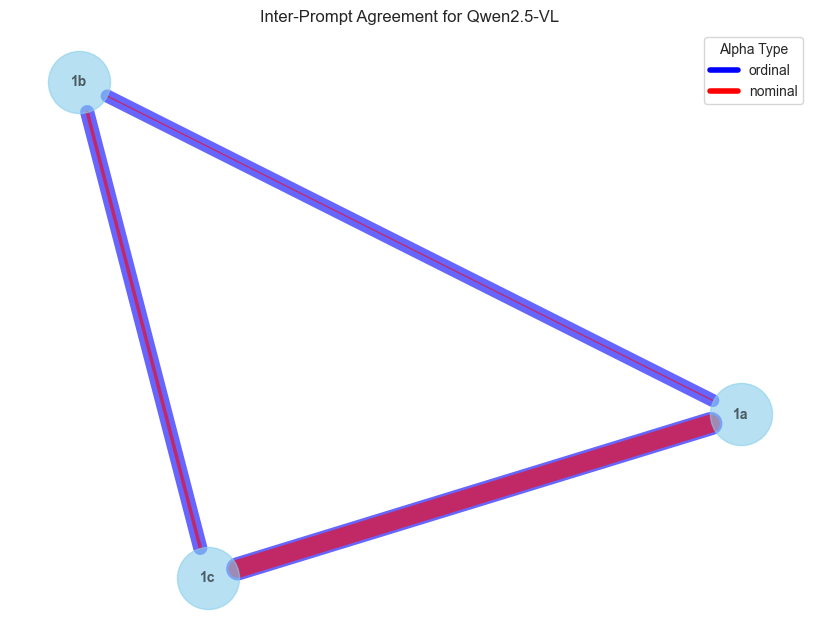

In [65]:
viz_network_stability(qwen2_5_interprompt_alpha)
plt.title('Inter-Prompt Agreement for Qwen2.5-VL')
plt.savefig(os.path.join(viz_output, 'qwen2.5_interprompt_stability_network.svg'), dpi=300, bbox_inches='tight')
plt.show()

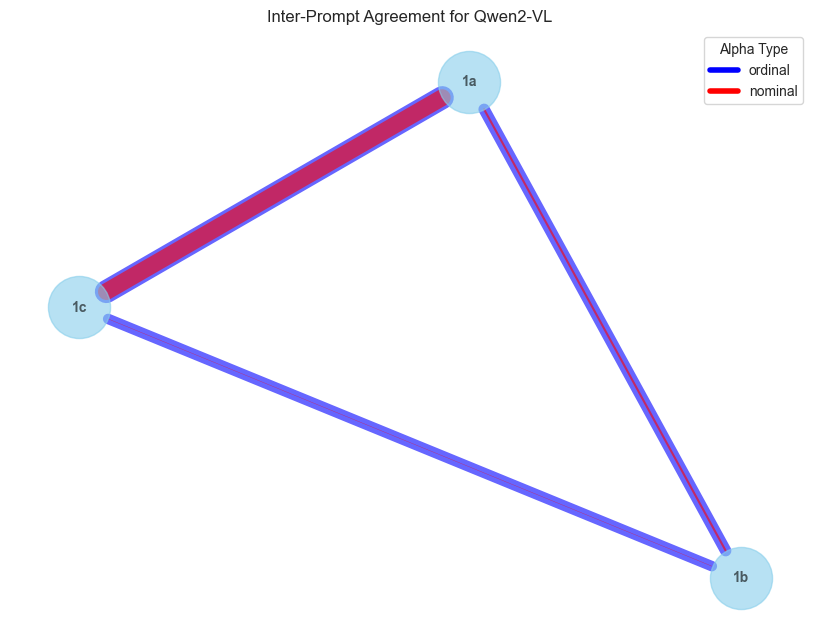

In [66]:
viz_network_stability(qwen2_interprompt_alpha)
plt.title('Inter-Prompt Agreement for Qwen2-VL')
plt.savefig(os.path.join(viz_output, 'qwen2_interprompt_stability_network.svg'), dpi=300, bbox_inches='tight')
plt.show()

#### Distribution Comparison Functions
To gain better insight, we can visualize the distributions of a model's annotation column for different prompts.



In [68]:
column_list = ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1c_qwen2.5']

In [100]:
# Define visualization function to compare distributions within a list of columns
def compare_distributions(df, column_list):
    """
      Compares the distribution of shot scale classifications across multiple columns.

      This function calculates and compares the value counts of shot scale classifications for the columns specified in `column_list`. It can operate in different modes based on the `mode` parameter, to include or exclude 'Uncertain' entries in the comparison.

      Args:
          df (pd.DataFrame): The DataFrame containing the columns to compare.
          column_list (list): A list of column names containing shot scale classifications to compare their distributions.
      """

    df_counts = pd.DataFrame()

    for col in column_list:
        value_counts = df[col].value_counts()
        df_counts[col] = value_counts

    # Define the desired order of shot scales
    if "Uncertain" in df_counts.index:
        order = ['Uncertain', 'Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up']
    elif "Uncertain" not in df_counts.index:
        order = ['Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up']

    # Reindex the df to match desired order
    df_counts = df_counts.reindex(order)

    # Plot the bar chart
    ax = df_counts.plot(kind='bar', figsize=(12, 6), edgecolor='none')
    #plt.grid(False)

    # Add labels and title
    plt.xlabel('Shot Scale')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return ax

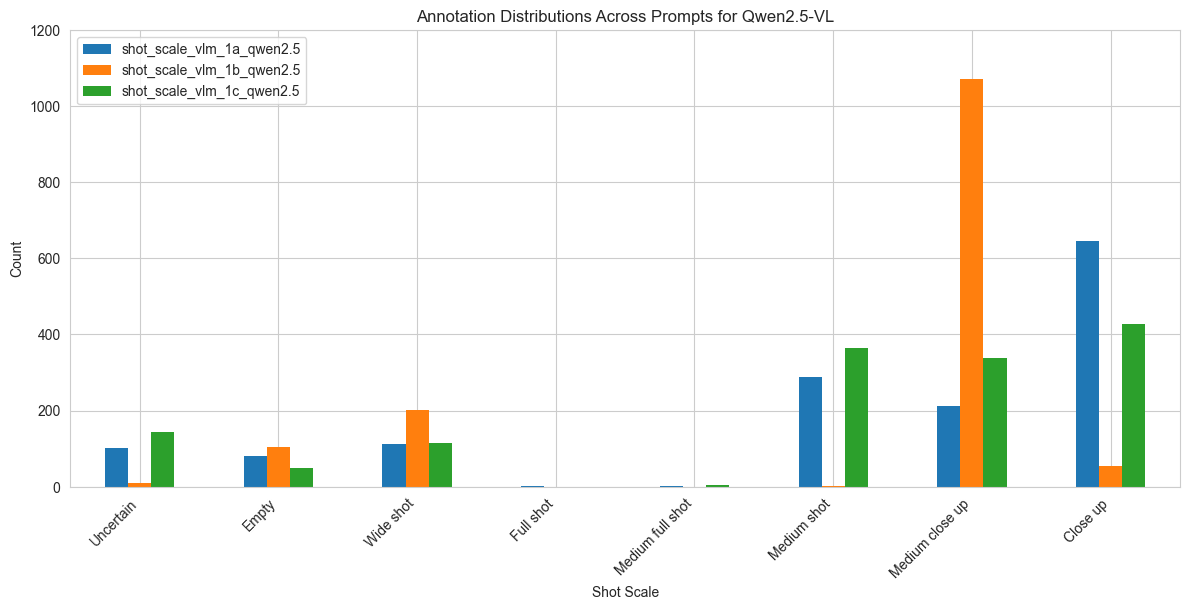

In [103]:
ax = compare_distributions(df_norm, column_list)
plt.ylim(0,1200)
plt.title('Annotation Distributions Across Prompts for Qwen2.5-VL')
plt.savefig(os.path.join(viz_output, 'annotation_distribution_qwen2.5.svg'), dpi=300, bbox_inches='tight')
plt.show()

In [80]:
def plot_confusion_matrix(df, col1, col2, labels=None, title="Confusion Matrix"):
    """
    Generates and plots a confusion matrix comparing the classifications
    between two columns in a DataFrame.
    PLEASE REMEMBER TO CALL plt.show() separately!
    Args:
        df (pd.DataFrame):  Input DataFrame.
        col1 (str): The name of the first column
        col2 (str): The name of the second column
        labels (list, optional): A list of unique labels to consider. If None,
                                 the unique labels from both columns will be used.
        title (str, optional): The title of the plot. Defaults to "Confusion Matrix".
    """
    # Drop rows where either column has a missing value (NaN)
    df_cleaned = df.dropna(subset=[col1, col2]).copy()

    # Get the labels
    y_true = df_cleaned[col1]
    y_pred = df_cleaned[col2]

    if labels is None:
        # Get all unique labels from both columns
        all_labels = sorted(list(set(y_true) | set(y_pred)))
        labels = all_labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel(f'Column 2: ({col2})')
    plt.ylabel(f'Column 1: ({col1})')
    plt.title(title)


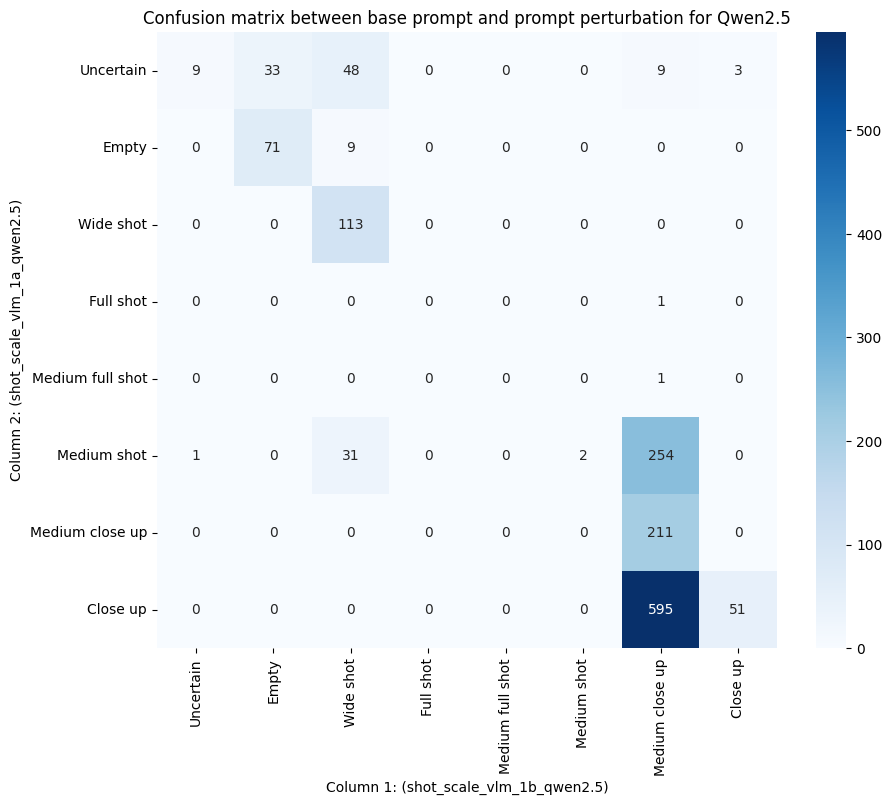

In [ ]:
plot_confusion_matrix(df_norm, 'shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1b_qwen2.5', ['Uncertain', 'Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up'], title = "Confusion matrix between base prompt and prompt perturbation for Qwen2.5")

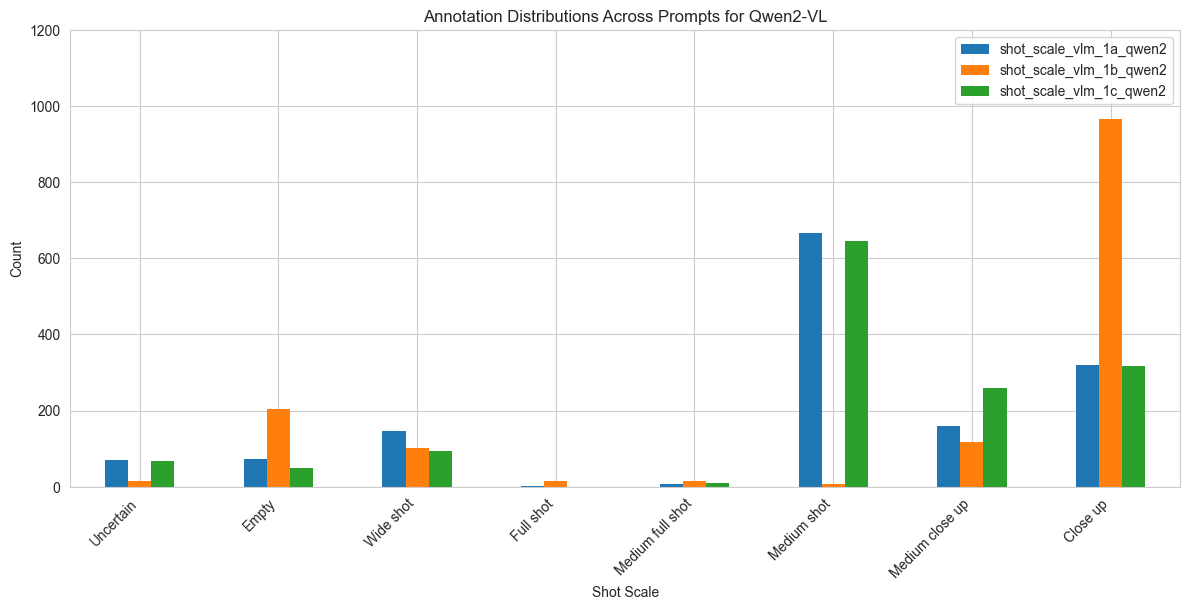

In [104]:
qwen2_list = ['shot_scale_vlm_1a_qwen2', 'shot_scale_vlm_1b_qwen2', 'shot_scale_vlm_1c_qwen2']
qwen2_ax = compare_distributions(df_norm, qwen2_list)
plt.ylim(0,1200)
plt.title('Annotation Distributions Across Prompts for Qwen2-VL')
plt.savefig(os.path.join(viz_output, 'annotation_distribution_qwen2.svg'), dpi=300, bbox_inches='tight')
plt.show()

#### Checking the validity of supplementary runs before we use them
Adding to this analysis, we can check the agreement of the supplementary runs, where the context and definitions remained constant, but only the return requirements were adjusted.

- Given that the intra-prompt stability of the main three prompt runs were reasonable, we can check the agreement between the aggregate result with their supplementary motivation and filler runs.

Recap of prompt runs:
1-3: Original prompt variation
4: A motivation for the classification was asked in the form of a tuple
5: "Uncertain" option was removed in order to generate substitutes for "Uncertain".

##### Evaluating Supplementary Motivation Runs
These runs were used to generate motivations for the prompt separate from the main three runs. This was done to avoid excessive data churn. It is also important to note that motivation runs to tend to take approximately 1.3 times longer to process. Given the size of the dataset and the number of runs needed, this was not done repeatedly.

In [105]:
# Run comparison between aggregate result and prompts where motivation was sought to evaluate validity of the motivation prompt relative to the main prompt runs.

prompt_list = ["1a",
               "1b",
               "1c"
               ]

model_names = {'qwen2.5': 'qwen2.5-vl-7b-instruct',
              'qwen2': 'qwen2-vl-7b-instruct',
               }

# Map to corresponding supplementary prompt run number
motivation_dict = {'qwen2.5': '04',
                 'qwen2': '09'
                 }

# Instantiate df_k_alpha to collect alpha information
df_motivation_agreement = pd.DataFrame({
    'model_name': pd.Series(dtype='object'),
    'prompt': pd.Series(dtype='object'),
    'col_list': pd.Series(dtype='object'),
    'alpha_ord': pd.Series(dtype='float'),
    'rows_with_nan': pd.Series(dtype='int'),
    'alpha_nom': pd.Series(dtype='float')
})

# Loop through the necessary comparison permutations
for model_name in model_names.keys():
    for prompt in prompt_list:

        # Set up target columns
        col_list = [f'shot_scale_vlm_{prompt}_{model_name}',
                    f'shot_scale_vlm_{prompt}_{motivation_dict[model_name]}'
                    ]

        df_results = calc_k_alpha_shot_scale_both(df_norm, col_list)
        df_results['model_name'] = model_names[model_name]
        df_results['prompt'] = [prompt]
        df_motivation_agreement = pd.concat([df_motivation_agreement, df_results], ignore_index=True)

df_motivation_agreement

Number of rows with NaN values/'Uncertain' (excluded from calculation): 110
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1a_04']: 0.730
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1a_04']: 0.342

Number of rows with NaN values/'Uncertain' (excluded from calculation): 12
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1b_04']: 0.795
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1b_04']: 0.704

Number of rows with NaN values/'Uncertain' (excluded from calculation): 143
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1c_qwen2.5', 'shot_scale_vlm_1c_04']: 0.715
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1c_qwen2.5', 'shot_scale_vlm_1c_04']: 0.179

Number of rows with NaN values/'Uncertain' (excluded from calculation): 84
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2', 'shot_scale_vlm_1a_09']: 0.699
Krippendorff’s alpha (nom

model_name prompt  \
0  qwen2.5-vl-7b-instruct     1a   
1  qwen2.5-vl-7b-instruct     1b   
2  qwen2.5-vl-7b-instruct     1c   
3    qwen2-vl-7b-instruct     1a   
4    qwen2-vl-7b-instruct     1b   
5    qwen2-vl-7b-instruct     1c   

                                            col_list  alpha_ord  \
0  [shot_scale_vlm_1a_qwen2.5, shot_scale_vlm_1a_04]   0.729752   
1  [shot_scale_vlm_1b_qwen2.5, shot_scale_vlm_1b_04]   0.794520   
2  [shot_scale_vlm_1c_qwen2.5, shot_scale_vlm_1c_04]   0.714533   
3    [shot_scale_vlm_1a_qwen2, shot_scale_vlm_1a_09]   0.698636   
4    [shot_scale_vlm_1b_qwen2, shot_scale_vlm_1b_09]   0.894340   
5    [shot_scale_vlm_1c_qwen2, shot_scale_vlm_1c_09]   0.556079   

   rows_with_nan  alpha_nom  
0            110   0.342425  
1             12   0.703782  
2            143   0.179131  
3             84   0.213477  
4             23   0.672309  
5            184   0.085267

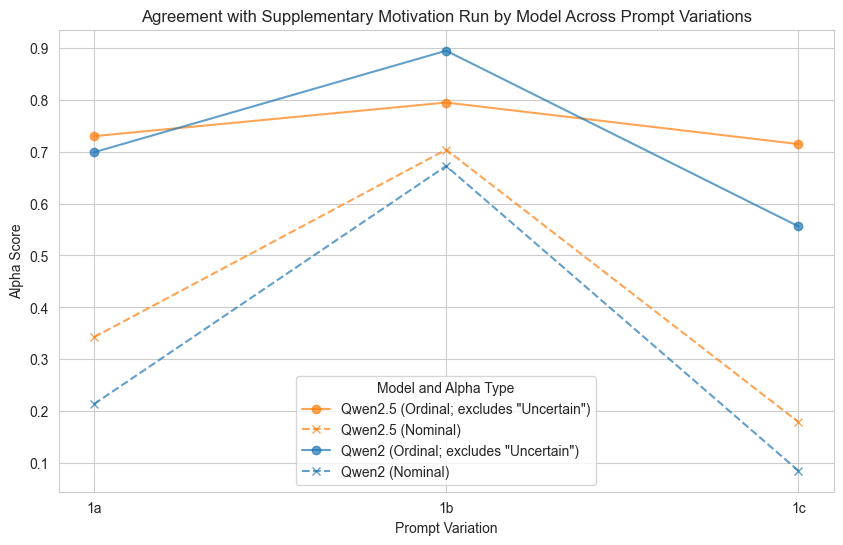

In [106]:
# Plot difference in Agreement with Motivation

# Melt the DataFrame to have 'prompt', 'model_name', 'alpha_ord', 'alpha_nom'
df_motivation_agreement_melted = df_motivation_agreement.melt(
    id_vars=['model_name', 'prompt'],
    value_vars=['alpha_ord', 'alpha_nom'],
    var_name='alpha_type',
    value_name='alpha_value'
)

# Define colors for each model
model_colors = {
    'qwen2.5-vl-7b-instruct': 'tab:orange',
    'qwen2-vl-7b-instruct': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

for model in model_colors.keys():
    model_df = df_motivation_agreement_melted[df_motivation_agreement_melted['model_name'] == model]

    if model == 'qwen2.5-vl-7b-instruct':
        model_short = 'Qwen2.5'
    elif model == 'qwen2-vl-7b-instruct':
        model_short = 'Qwen2'

    # Plot ordinal alpha
    ordinal_df = model_df[model_df['alpha_type'] == 'alpha_ord']
    plt.plot(ordinal_df['prompt'], ordinal_df['alpha_value'], marker='o', linestyle='-', color=model_colors[model], label=f'{model_short} (Ordinal; excludes "Uncertain")', alpha=0.7)

    # Plot nominal alpha
    nominal_df = model_df[model_df['alpha_type'] == 'alpha_nom']
    plt.plot(nominal_df['prompt'], nominal_df['alpha_value'], marker='x', linestyle='--', color=model_colors[model], label=f'{model_short} (Nominal)', alpha=0.7)


plt.xlabel('Prompt Variation')
plt.ylabel('Alpha Score')
plt.title('Agreement with Supplementary Motivation Run by Model Across Prompt Variations')
plt.legend(title='Model and Alpha Type')
plt.grid(True)
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_motivation_agreement.svg'), dpi=300, bbox_inches='tight')
plt.show()

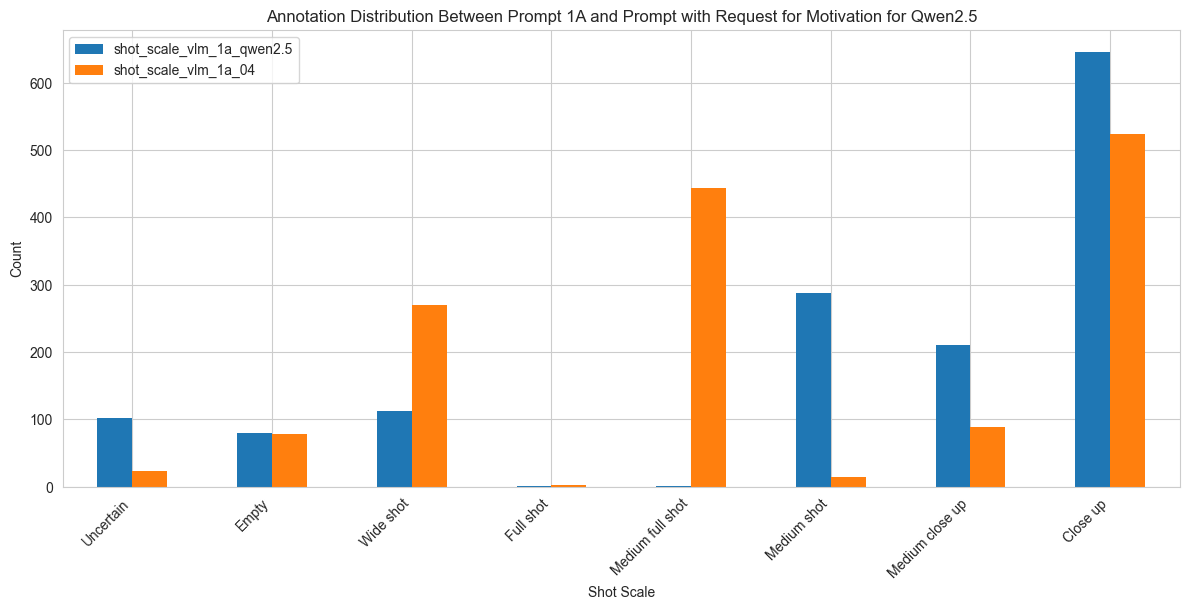

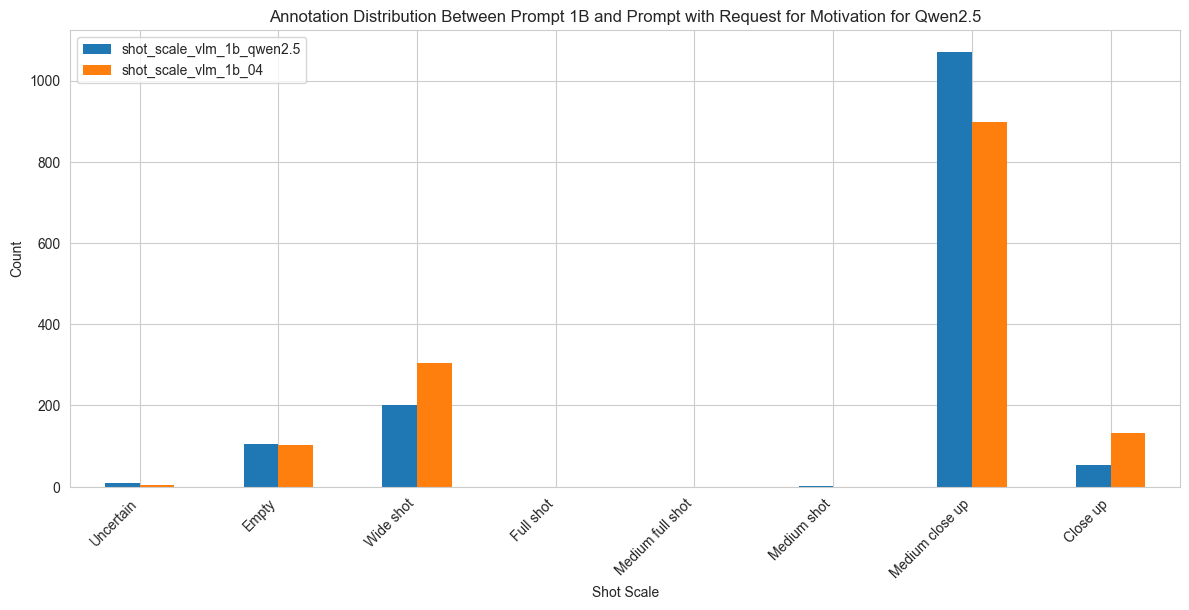

In [107]:
ax = compare_distributions(df_norm, ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1a_04'])
plt.title('Annotation Distribution Between Prompt 1A and Prompt with Request for Motivation for Qwen2.5')
plt.show()

ax = compare_distributions(df_norm, ['shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1b_04'])
plt.title('Annotation Distribution Between Prompt 1B and Prompt with Request for Motivation for Qwen2.5')
plt.show()

When evaluated on an ordinal scale, the prompt for motivation exhibit somewhat agreeable behaviour. However, when all mismatches are penalized equally, it becomes apparent that there are significant deviations despite the only addition being. This makes the motivations generated tenuous and needs to be used carefully.

##### Evaluating Supplementary Filler Runs

These columns were generated without "Uncertain" in their list of labels to be returned. This was to be able to fill entries that were "Uncertain".

However, after data cleaning, some may have been adjusted to "Uncertain" as well.

In [108]:
# Run comparison between aggregate result and prompts where uncertain option was removed relative to the main prompt runs.

prompt_list = ["1a",
               "1b",
               "1c"
               ]

model_names = {'qwen2.5': 'qwen2.5-vl-7b-instruct',
              'qwen2': 'qwen2-vl-7b-instruct',
               }

# Map to corresponding supplementary prompt run number
filler_dict = {'qwen2.5': '05_filler',
                 'qwen2': '10_filler'
                 }

# Instantiate df to collect alpha information
df_filler_agreement = pd.DataFrame({
    'model_name': pd.Series(dtype='object'),
    'prompt': pd.Series(dtype='object'),
    'col_list': pd.Series(dtype='object'),
    'alpha_ord': pd.Series(dtype='float'),
    'rows_with_nan': pd.Series(dtype='int'),
    'alpha_nom': pd.Series(dtype='float')
})

# Loop through the necessary comparison permutations
for model_name in model_names.keys():
    for prompt in prompt_list:

        # Set up target columns
        col_list = [f'shot_scale_vlm_{prompt}_{model_name}', # Aggregate col
                    f'shot_scale_vlm_{prompt}_{filler_dict[model_name]}'
                    ]

        df_results = calc_k_alpha_shot_scale_both(df_norm, col_list)
        df_results['model_name'] = model_names[model_name]
        df_results['prompt'] = [prompt]
        df_filler_agreement = pd.concat([df_filler_agreement, df_results], ignore_index=True)

# Remove alpha_nom as "Uncertain" is meant to be excluded and they would not include "Uncertain" in their distribution
df_filler_agreement = df_filler_agreement.drop(columns='alpha_nom')
df_filler_agreement

Number of rows with NaN values/'Uncertain' (excluded from calculation): 102
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1a_05_filler']: 0.912
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1a_qwen2.5', 'shot_scale_vlm_1a_05_filler']: 0.710

Number of rows with NaN values/'Uncertain' (excluded from calculation): 10
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1b_05_filler']: 0.912
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1b_qwen2.5', 'shot_scale_vlm_1b_05_filler']: 0.793

Number of rows with NaN values/'Uncertain' (excluded from calculation): 143
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1c_qwen2.5', 'shot_scale_vlm_1c_05_filler']: 0.822
Krippendorff’s alpha (nominal) for ['shot_scale_vlm_1c_qwen2.5', 'shot_scale_vlm_1c_05_filler']: 0.521

Number of rows with NaN values/'Uncertain' (excluded from calculation): 75
Krippendorff’s alpha (ordinal) for ['shot_scale_vlm_1a_qwen2', 'shot_scale_vl

model_name prompt  \
0  qwen2.5-vl-7b-instruct     1a   
1  qwen2.5-vl-7b-instruct     1b   
2  qwen2.5-vl-7b-instruct     1c   
3    qwen2-vl-7b-instruct     1a   
4    qwen2-vl-7b-instruct     1b   
5    qwen2-vl-7b-instruct     1c   

                                            col_list  alpha_ord  rows_with_nan  
0  [shot_scale_vlm_1a_qwen2.5, shot_scale_vlm_1a_...   0.911652            102  
1  [shot_scale_vlm_1b_qwen2.5, shot_scale_vlm_1b_...   0.912319             10  
2  [shot_scale_vlm_1c_qwen2.5, shot_scale_vlm_1c_...   0.821852            143  
3  [shot_scale_vlm_1a_qwen2, shot_scale_vlm_1a_10...   0.740921             75  
4  [shot_scale_vlm_1b_qwen2, shot_scale_vlm_1b_10...   0.713978             22  
5  [shot_scale_vlm_1c_qwen2, shot_scale_vlm_1c_10...   0.731875             67

Qwen2.5's filler columns are generally in agreement with each other, suggesting they can be used. On the other hand, Qwen2's is significantly worse, once again indicating its instability.

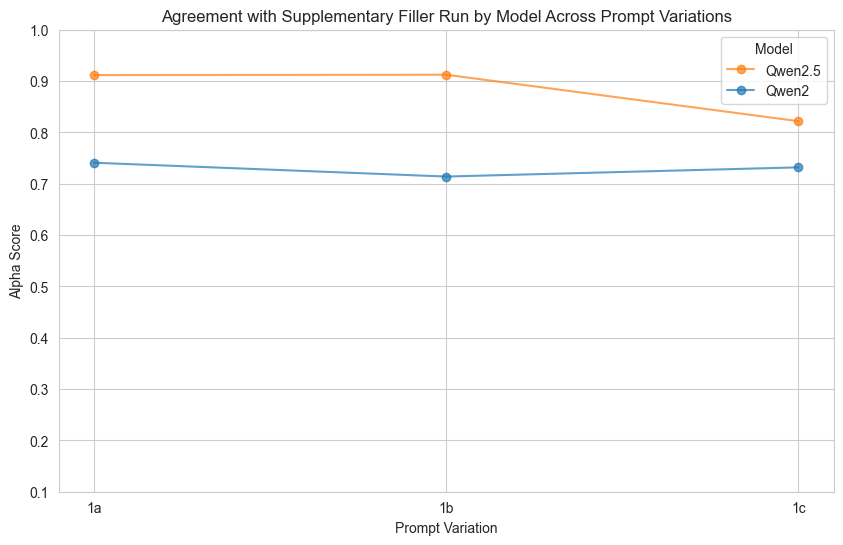

In [109]:
# Plot difference in Agreement with Motivation

# Melt the DataFrame to have 'prompt', 'model_name', 'alpha_ord'
df_filler_agreement_melted = df_filler_agreement.melt(
    id_vars=['model_name', 'prompt'],
    value_vars=['alpha_ord'],
    var_name='alpha_type',
    value_name='alpha_value'
)

# Define colors for each model
model_colors = {
    'qwen2.5-vl-7b-instruct': 'tab:orange',
    'qwen2-vl-7b-instruct': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

for model in model_colors.keys():
    model_df = df_filler_agreement_melted[df_filler_agreement_melted['model_name'] == model]

    if model == 'qwen2.5-vl-7b-instruct':
        model_short = 'Qwen2.5'
    elif model == 'qwen2-vl-7b-instruct':
        model_short = 'Qwen2'

    # Plot ordinal alpha
    ordinal_df = model_df[model_df['alpha_type'] == 'alpha_ord']
    plt.plot(ordinal_df['prompt'], ordinal_df['alpha_value'], marker='o', linestyle='-', color=model_colors[model], label=f'{model_short}', alpha=0.7)


plt.xlabel('Prompt Variation')
plt.ylabel('Alpha Score')
plt.ylim(0.1,1)
plt.title('Agreement with Supplementary Filler Run by Model Across Prompt Variations')
plt.legend(title='Model')
plt.grid(True)
plt.savefig(os.path.join(viz_output, 'idf_data_shot_scale_vlm_filler_agreement.svg'), dpi=300, bbox_inches='tight')
plt.show()

### Replace aggregate 'Uncertain' responses with filler inputs and remove videos with remainder "uncertain" scenes

In order to facilitate an even intercoder agreement comparison across the board, "Uncertain" responses need to be removed from the main runs and aggregate annotations (the majority vote).

This will be done through a three-step filter process.
1. If an entry is 'Uncertain' but it has a non-uncertain aggregate response (ie the other two entries from the same prompt-model permutation are "certain"), it will be replaced by an
2. If an entry is 'Uncertain' and its aggregate response across the three prompt runs is also "Uncertain", it will be manually reviewed and replaced by its filler run.
3. If its filler run happens to also be "Uncertain", the thumbnail and others from the same video is removed from the dataset entirely.

#### Reviewing consistently "uncertain" responses
Before we replace the scenes, we can review the thumbnails that the VLM consistently label as "Uncertain". This is indicated by "Uncertain" aggregate annotations across the 3 main runs of a prompt-model permutation.

In [14]:
df_norm = pd.read_csv(os.path.join(data_output,'04_idf_data_shot_scale_vlm_normalized.csv'))

In [15]:
# Display value counts of filler columns to check for distribution
filler_cols = [col for col in df_norm.columns if "filler" in col]
for col in filler_cols:
    print(df_norm[col].value_counts())
    print()

shot_scale_vlm_1a_05_filler
Close up            564
Medium close up     338
Medium shot         286
Empty               167
Wide shot            84
Medium full shot      3
Name: count, dtype: int64

shot_scale_vlm_1a_10_filler
Close up            672
Medium shot         433
Empty               137
Wide shot           117
Medium close up      45
Full shot            22
Uncertain             9
Medium full shot      7
Name: count, dtype: int64

shot_scale_vlm_1b_05_filler
Medium close up     1083
Empty                170
Wide shot            146
Close up              20
Medium shot           20
Medium full shot       3
Name: count, dtype: int64

shot_scale_vlm_1b_10_filler
Close up           1002
Empty               245
Medium close up     132
Medium shot          53
Uncertain             9
Wide shot             1
Name: count, dtype: int64

shot_scale_vlm_1c_05_filler
Medium close up     661
Medium shot         407
Empty               153
Close up            109
Wide shot            96
Me

Reviewing the value counts for the filler roles, we can observe that a few from Qwen2 (Prompt 1B) have been replaced with "Uncertain", after generating verbose replies after encountering collages.

In [112]:
df_norm['shot_scale_vlm_1b_10_filler'].value_counts()

shot_scale_vlm_1b_10_filler
Close up           1002
Empty               245
Medium close up     132
Medium shot          53
Uncertain             9
Wide shot             1
Name: count, dtype: int64

In [4]:
# Display a copy of df_norm filtered for "Uncertain" in shot_scale_vlm_1a_05_filler or shot_scale_vlm_1b_10_filler or shot_scale_vlm_1c_10_filler for review

df_norm_filtered = df_norm[
    (df_norm['shot_scale_vlm_1a_10_filler'] == 'Uncertain') |
    (df_norm['shot_scale_vlm_1b_10_filler'] == 'Uncertain') |
    (df_norm['shot_scale_vlm_1c_10_filler'] == 'Uncertain')
].copy()

desired_cols = ['id', 'url'] + [col for col in df_norm_filtered.columns if "shot_scale_vlm" in col]

df_norm_filtered = df_norm_filtered[desired_cols]
# Display the filtered DataFrame
df_norm_filtered[['id','shot_scale_vlm_1a_10_filler', 'shot_scale_vlm_1b_10_filler','shot_scale_vlm_1c_10_filler']]


id shot_scale_vlm_1a_10_filler  \
81    7422617346390494471.mp4_scene_8                 Medium shot   
200   7400439237939563796.mp4_scene_4                   Uncertain   
265   7378235135549902081.mp4_scene_1                 Medium shot   
267   7378235135549902081.mp4_scene_3                   Uncertain   
425  7349653141559741704.mp4_scene_14                   Uncertain   
446  7347367797426736386.mp4_scene_21                   Uncertain   
447  7347367797426736386.mp4_scene_22                   Wide shot   
453  7347367797426736386.mp4_scene_28                   Uncertain   
454  7347367797426736386.mp4_scene_29                   Uncertain   
455  7347367797426736386.mp4_scene_30                   Uncertain   
464  7347367797426736386.mp4_scene_39                   Uncertain   
466  7347367797426736386.mp4_scene_41                   Uncertain   

    shot_scale_vlm_1b_10_filler shot_scale_vlm_1c_10_filler  
81                    Uncertain                 Medium shot  
200                    Close up                 Medium shot  
265                   Uncertain                 Medium shot  
267                   Uncertain            Medium full shot  
425                   Uncertain                 Medium shot  
446                       Empty                       Empty  
447                   Uncertain                 Medium shot  
453                   Uncertain                 Medium shot  
454                   Uncertain                 Medium shot  
455                   Uncertain            Medium full shot  
464                   Uncertain                   Wide shot  
466                       Empty                    Close up

 Given that this only affects 12 rows, this should not greatly affect the dataset once we attempt to fill entries with `Uncertain`. Some thumbnails may need to be removed if they were deemed consistently `Uncertain` eg `7347367797426736386.mp4_scene_41`

 It is also interesting to note that six out of 12 of these scenes come from video `7347367797426736386`. This video contains multiple instances of collages, causing the VLM to break down frequently as it did not fit the definitions provided by the prompt. However, unlike its newer counterpart, Qwen2 , presumably due to its relatively greater instability.

In [16]:
# Create a dataframe of scenes where there is Uncertain in ANY of the aggregate columns
aggregate_cols = [col for col in df_norm.columns if "qwen2.5" in col or "qwen2" in col]
target_cols = ['id', 'url'] + aggregate_cols

# Create boolean mask
mask = df_norm[aggregate_cols].apply(lambda row: "Uncertain" in row.values, axis=1)


df_uncertain = df_norm[mask][target_cols]
df_uncertain

id                  url  \
1      7357772207445134608.mp4_scene_2  7357772207445134608   
2      7357772207445134608.mp4_scene_3  7357772207445134608   
8      7357772207445134608.mp4_scene_9  7357772207445134608   
12    7357772207445134608.mp4_scene_13  7357772207445134608   
18    7357772207445134608.mp4_scene_19  7357772207445134608   
...                                ...                  ...   
1427   7287823285566426369.mp4_scene_2  7287823285566426369   
1428   7287823285566426369.mp4_scene_3  7287823285566426369   
1432   7287823285566426369.mp4_scene_7  7287823285566426369   
1435  7287823285566426369.mp4_scene_10  7287823285566426369   
1439  7287823285566426369.mp4_scene_14  7287823285566426369   

     shot_scale_vlm_1a_qwen2.5 shot_scale_vlm_1a_qwen2  \
1                    Uncertain               Wide shot   
2                    Uncertain                   Empty   
8                    Uncertain               Wide shot   
12                       Empty                   Empty   
18                   Uncertain         Medium close up   
...                        ...                     ...   
1427               Medium shot               Wide shot   
1428                 Uncertain               Wide shot   
1432               Medium shot             Medium shot   
1435                 Uncertain               Uncertain   
1439           Medium close up               Uncertain   

     shot_scale_vlm_1b_qwen2.5 shot_scale_vlm_1b_qwen2  \
1                    Wide shot                   Empty   
2                        Empty                   Empty   
8              Medium close up                   Empty   
12                   Wide shot                   Empty   
18                       Empty         Medium close up   
...                        ...                     ...   
1427           Medium close up                   Empty   
1428                     Empty                   Empty   
1432           Medium close up               Uncertain   
1435                 Uncertain               Uncertain   
1439           Medium close up                   Empty   

     shot_scale_vlm_1c_qwen2.5 shot_scale_vlm_1c_qwen2  
1                    Uncertain               Wide shot  
2                    Uncertain               Uncertain  
8                    Uncertain             Medium shot  
12                   Uncertain                   Empty  
18                   Uncertain         Medium close up  
...                        ...                     ...  
1427                 Uncertain               Wide shot  
1428                 Uncertain               Wide shot  
1432               Medium shot             Medium shot  
1435                 Uncertain               Uncertain  
1439               Medium shot               Uncertain  

[231 rows x 8 columns]

In [17]:
# We can be more selective and only select scenes where three or more aggregates are Uncertain

threshold = 3
df_uncertain_threshold = df_uncertain.copy()

for i, row in df_uncertain.iterrows():
    uncertain_count = 0
    for col in aggregate_cols:
        if row[col] == "Uncertain":
            uncertain_count += 1
    if uncertain_count < threshold:
        df_uncertain_threshold = df_uncertain_threshold.drop(i)
df_uncertain_threshold

id                  url  \
2      7357772207445134608.mp4_scene_3  7357772207445134608   
20    7357772207445134608.mp4_scene_21  7357772207445134608   
30    7357772207445134608.mp4_scene_31  7357772207445134608   
93     7421923208376405266.mp4_scene_3  7421923208376405266   
109    7417541679802060050.mp4_scene_7  7417541679802060050   
115   7417541679802060050.mp4_scene_13  7417541679802060050   
138   7414538490660048135.mp4_scene_14  7414538490660048135   
195   7400840806661197077.mp4_scene_12  7400840806661197077   
218   7397447925460241671.mp4_scene_12  7397447925460241671   
425   7349653141559741704.mp4_scene_14  7349653141559741704   
440   7347367797426736386.mp4_scene_15  7347367797426736386   
457   7347367797426736386.mp4_scene_32  7347367797426736386   
466   7347367797426736386.mp4_scene_41  7347367797426736386   
473   7347367797426736386.mp4_scene_48  7347367797426736386   
576    7332472351809899778.mp4_scene_8  7332472351809899778   
594   7331799655585516802.mp4_scene_14  7331799655585516802   
601   7331799655585516802.mp4_scene_21  7331799655585516802   
611   7331799655585516802.mp4_scene_31  7331799655585516802   
673   7326891550598761729.mp4_scene_15  7326891550598761729   
678   7326891550598761729.mp4_scene_20  7326891550598761729   
779   7317601260947918082.mp4_scene_12  7317601260947918082   
825    7314608725224967425.mp4_scene_4  7314608725224967425   
826    7314608725224967425.mp4_scene_5  7314608725224967425   
841   7314608725224967425.mp4_scene_20  7314608725224967425   
852    7312113109848575234.mp4_scene_4  7312113109848575234   
895    7309917666364493057.mp4_scene_9  7309917666364493057   
963   7307624697146068225.mp4_scene_52  7307624697146068225   
989   7306872398215777537.mp4_scene_14  7306872398215777537   
1024   7304841271166766337.mp4_scene_9  7304841271166766337   
1025  7304841271166766337.mp4_scene_10  7304841271166766337   
1091   7303238806273068290.mp4_scene_6  7303238806273068290   
1094   7303238806273068290.mp4_scene_9  7303238806273068290   
1148  7301501906440981761.mp4_scene_16  7301501906440981761   
1156   7300966749761998082.mp4_scene_3  7300966749761998082   
1161   7300966749761998082.mp4_scene_8  7300966749761998082   
1190  7299238025198898434.mp4_scene_15  7299238025198898434   
1199  7299238025198898434.mp4_scene_24  7299238025198898434   
1272   7295172273592339713.mp4_scene_2  7295172273592339713   
1278   7295172273592339713.mp4_scene_8  7295172273592339713   
1435  7287823285566426369.mp4_scene_10  7287823285566426369   

     shot_scale_vlm_1a_qwen2.5 shot_scale_vlm_1a_qwen2  \
2                    Uncertain                   Empty   
20                   Uncertain               Uncertain   
30                   Uncertain               Uncertain   
93                   Uncertain               Uncertain   
109                  Uncertain               Uncertain   
115                  Uncertain               Wide shot   
138                  Uncertain                   Empty   
195                  Uncertain               Uncertain   
218                  Uncertain               Uncertain   
425                Medium shot               Wide shot   
440                  Uncertain               Uncertain   
457                  Uncertain               Uncertain   
466                  Uncertain               Uncertain   
473                  Uncertain               Wide shot   
576                  Uncertain               Uncertain   
594                  Uncertain               Uncertain   
601                  Uncertain               Uncertain   
611                  Uncertain                   Empty   
673                  Uncertain                Close up   
678                  Uncertain               Uncertain   
779                Medium shot               Uncertain   
825                  Uncertain             Medium shot   
826                  Uncertain               Uncertain   
841                  Uncertain               Uncertain   
85

##### Setting up helper visualization functions

In [18]:
# Obtain two columns of motivations (The two most reliable columns
df_motivations = df_norm[['id','shot_scale_vlm_1a_04_motivation','shot_scale_vlm_1c_04_motivation']]

# Combine with df_uncertain_threshold
df_uncertain_threshold = df_uncertain_threshold.merge(df_motivations, on='id', how='left')
df_uncertain_threshold

id                  url  \
0    7357772207445134608.mp4_scene_3  7357772207445134608   
1   7357772207445134608.mp4_scene_21  7357772207445134608   
2   7357772207445134608.mp4_scene_31  7357772207445134608   
3    7421923208376405266.mp4_scene_3  7421923208376405266   
4    7417541679802060050.mp4_scene_7  7417541679802060050   
5   7417541679802060050.mp4_scene_13  7417541679802060050   
6   7414538490660048135.mp4_scene_14  7414538490660048135   
7   7400840806661197077.mp4_scene_12  7400840806661197077   
8   7397447925460241671.mp4_scene_12  7397447925460241671   
9   7349653141559741704.mp4_scene_14  7349653141559741704   
10  7347367797426736386.mp4_scene_15  7347367797426736386   
11  7347367797426736386.mp4_scene_32  7347367797426736386   
12  7347367797426736386.mp4_scene_41  7347367797426736386   
13  7347367797426736386.mp4_scene_48  7347367797426736386   
14   7332472351809899778.mp4_scene_8  7332472351809899778   
15  7331799655585516802.mp4_scene_14  7331799655585516802   
16  7331799655585516802.mp4_scene_21  7331799655585516802   
17  7331799655585516802.mp4_scene_31  7331799655585516802   
18  7326891550598761729.mp4_scene_15  7326891550598761729   
19  7326891550598761729.mp4_scene_20  7326891550598761729   
20  7317601260947918082.mp4_scene_12  7317601260947918082   
21   7314608725224967425.mp4_scene_4  7314608725224967425   
22   7314608725224967425.mp4_scene_5  7314608725224967425   
23  7314608725224967425.mp4_scene_20  7314608725224967425   
24   7312113109848575234.mp4_scene_4  7312113109848575234   
25   7309917666364493057.mp4_scene_9  7309917666364493057   
26  7307624697146068225.mp4_scene_52  7307624697146068225   
27  7306872398215777537.mp4_scene_14  7306872398215777537   
28   7304841271166766337.mp4_scene_9  7304841271166766337   
29  7304841271166766337.mp4_scene_10  7304841271166766337   
30   7303238806273068290.mp4_scene_6  7303238806273068290   
31   7303238806273068290.mp4_scene_9  7303238806273068290   
32  7301501906440981761.mp4_scene_16  7301501906440981761   
33   7300966749761998082.mp4_scene_3  7300966749761998082   
34   7300966749761998082.mp4_scene_8  7300966749761998082   
35  7299238025198898434.mp4_scene_15  7299238025198898434   
36  7299238025198898434.mp4_scene_24  7299238025198898434   
37   7295172273592339713.mp4_scene_2  7295172273592339713   
38   7295172273592339713.mp4_scene_8  7295172273592339713   
39  7287823285566426369.mp4_scene_10  7287823285566426369   

   shot_scale_vlm_1a_qwen2.5 shot_scale_vlm_1a_qwen2  \
0                  Uncertain                   Empty   
1                  Uncertain               Uncertain   
2                  Uncertain               Uncertain   
3                  Uncertain               Uncertain   
4                  Uncertain               Uncertain   
5                  Uncertain               Wide shot   
6                  Uncertain                   Empty   
7                  Uncertain               Uncertain   
8                  Uncertain               Uncertain   
9                Medium shot               Wide shot   
10                 Uncertain               Uncertain   
11                 Uncertain               Uncertain   
12                 Uncertain               Uncertain   
13                 Uncertain               Wide shot   
14                 Uncertain               Uncertain   
15                 Uncertain               Uncertain   
16                 Uncertain               Uncertain   
17                 Uncertain                   Empty   
18                 Uncertain                Close up   
19                 Uncertain               Uncertain   
20               Medium shot               Uncertain   
21                 Uncertain             Medium shot   
22                 Uncertain               Uncertain   
23                 Uncertain               Uncertain   
24                 Uncertain             Medium shot   
25                 Uncertain               Uncertain   
26                 U

In [20]:
def read_rgb(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

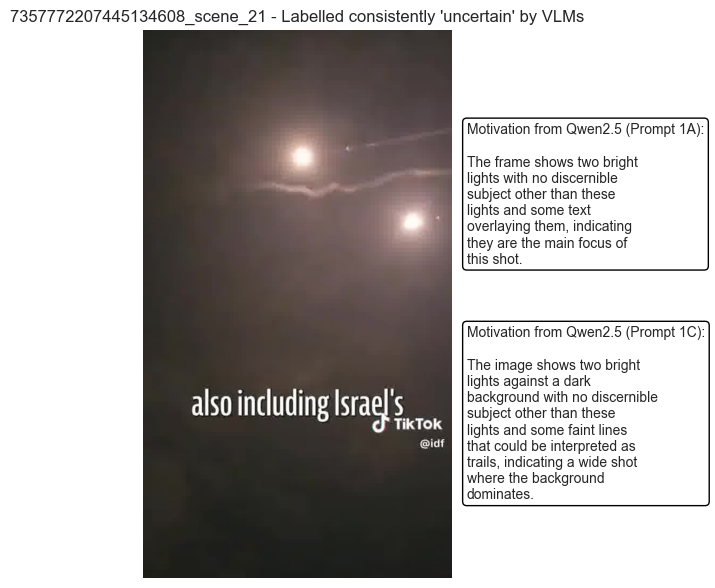

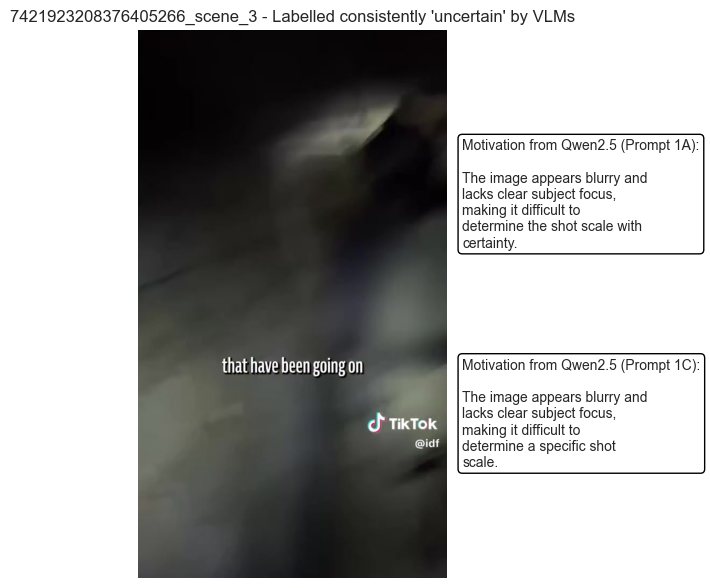

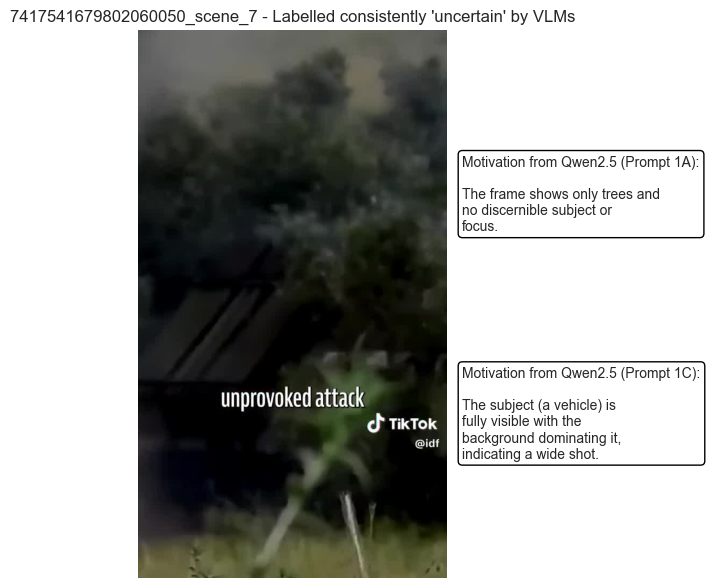

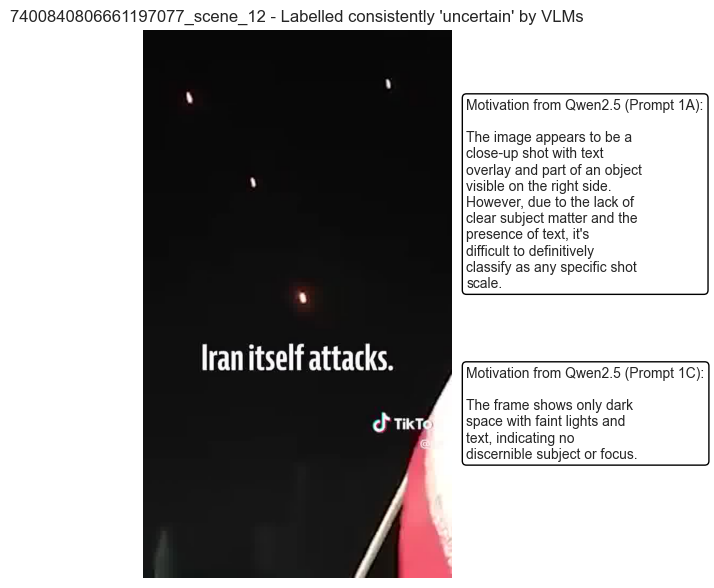

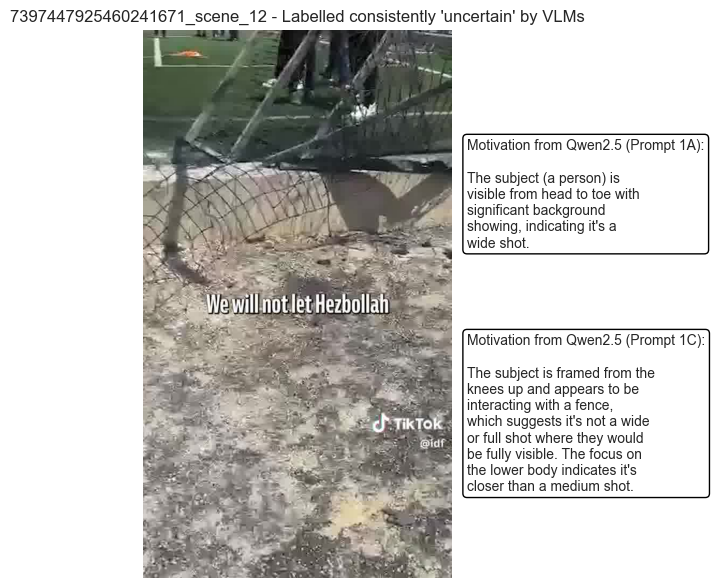

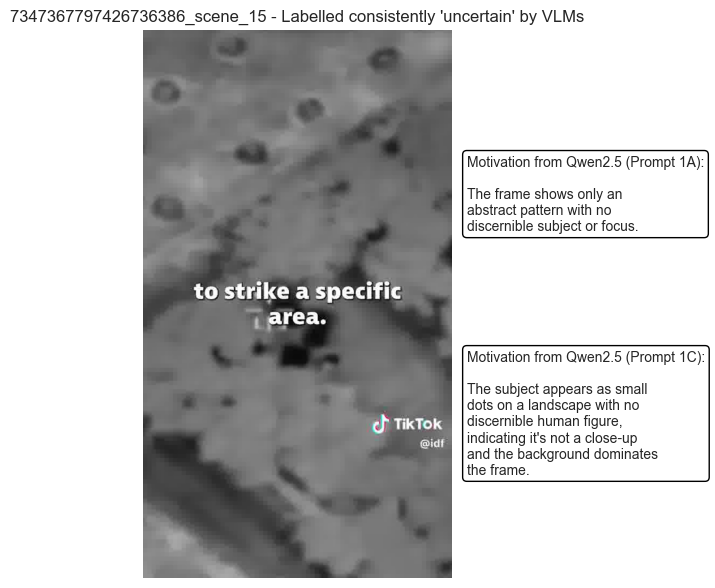

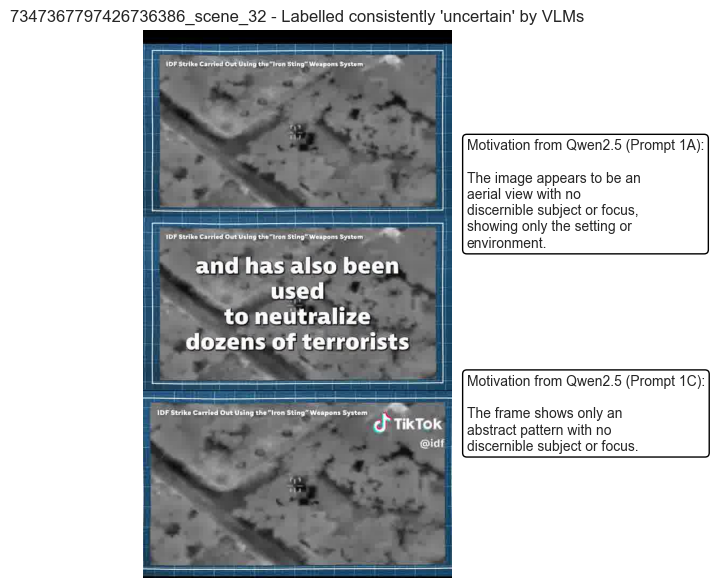

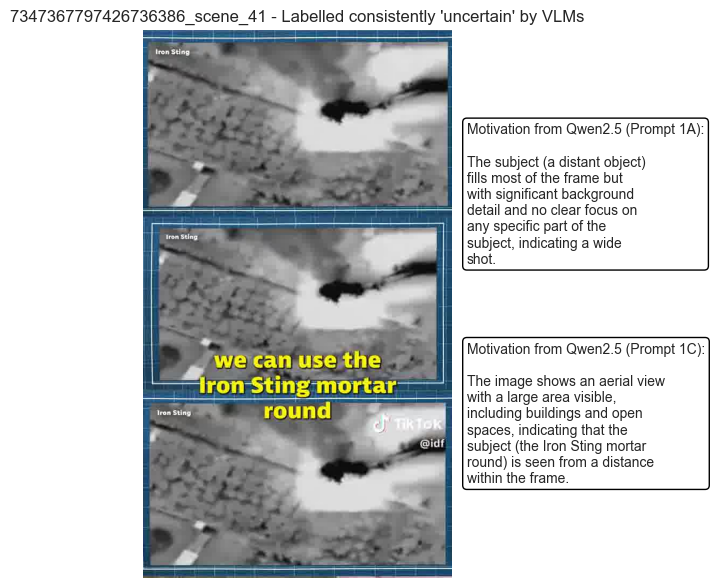

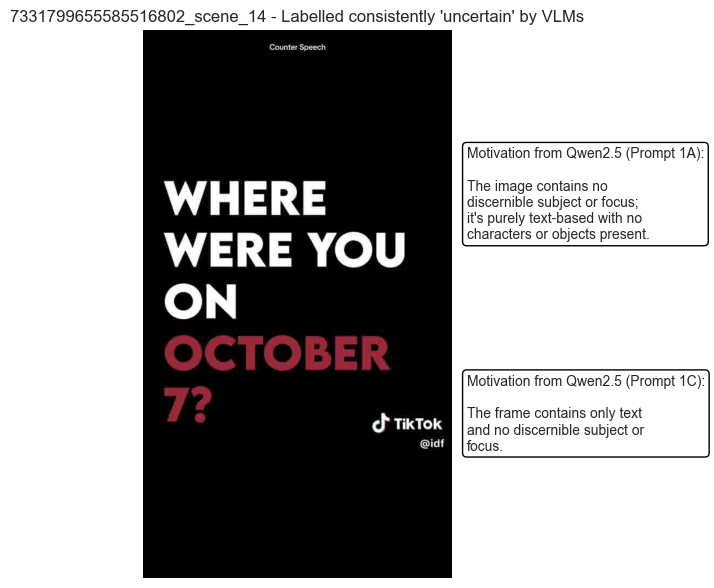

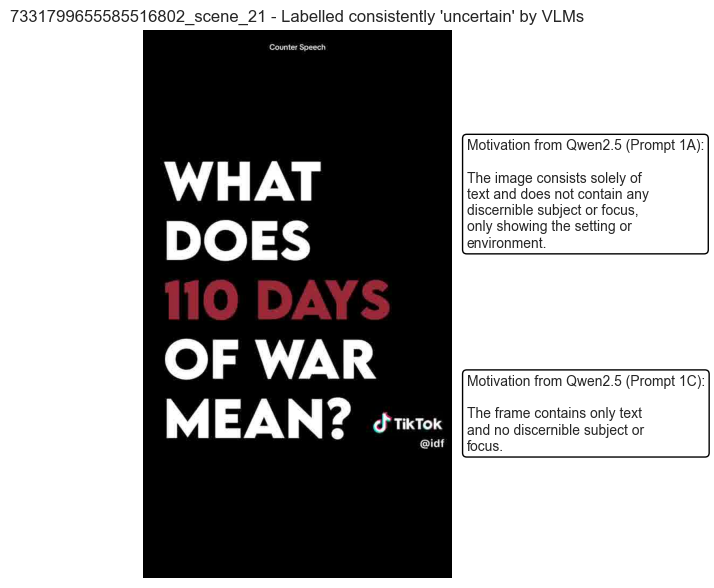

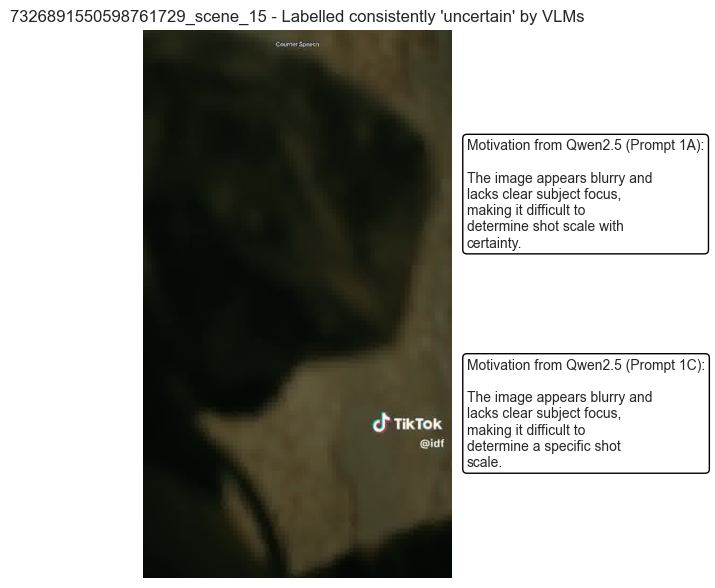

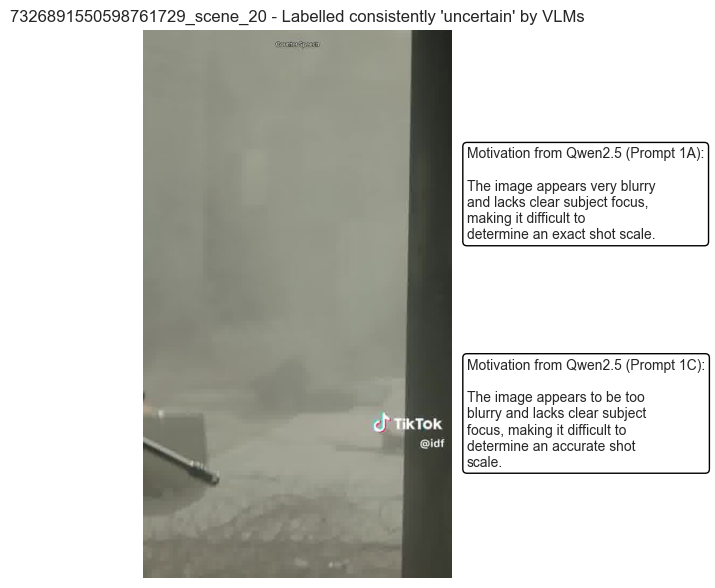

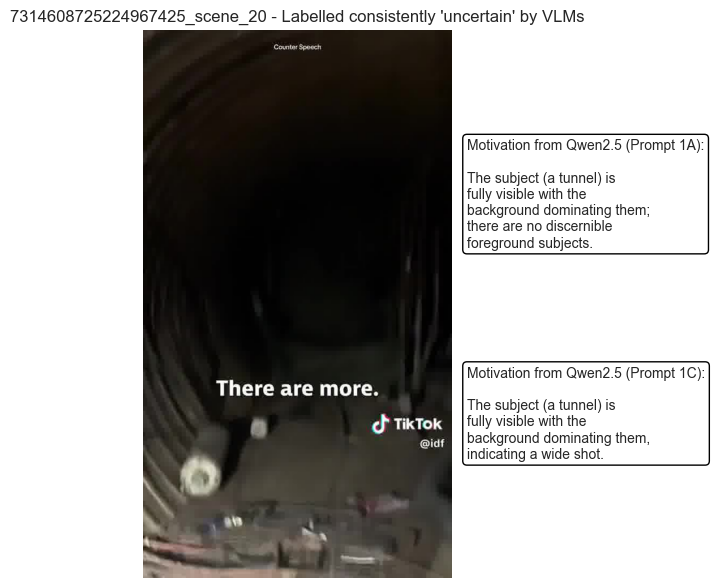

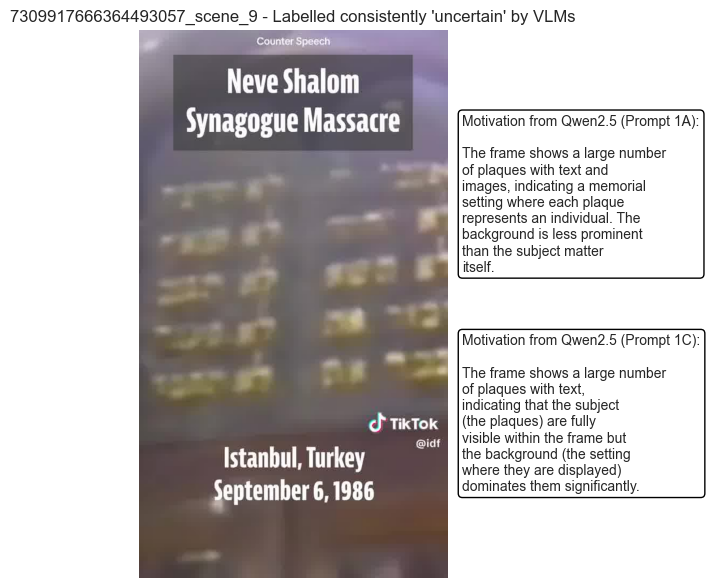

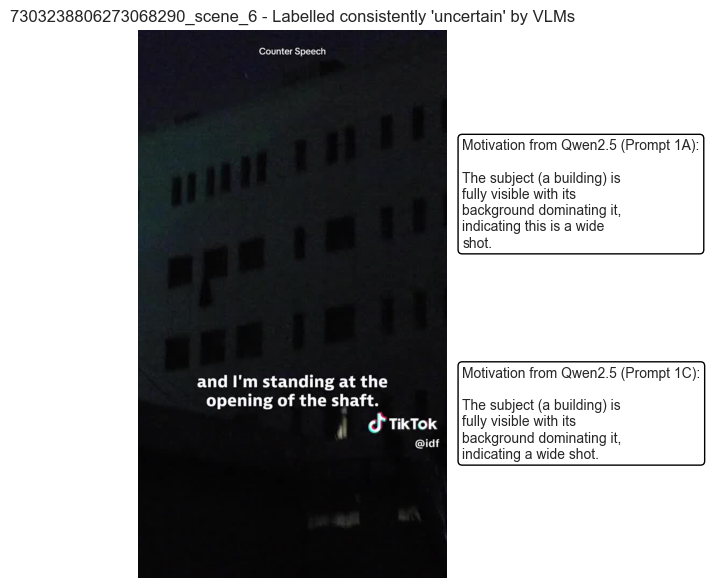

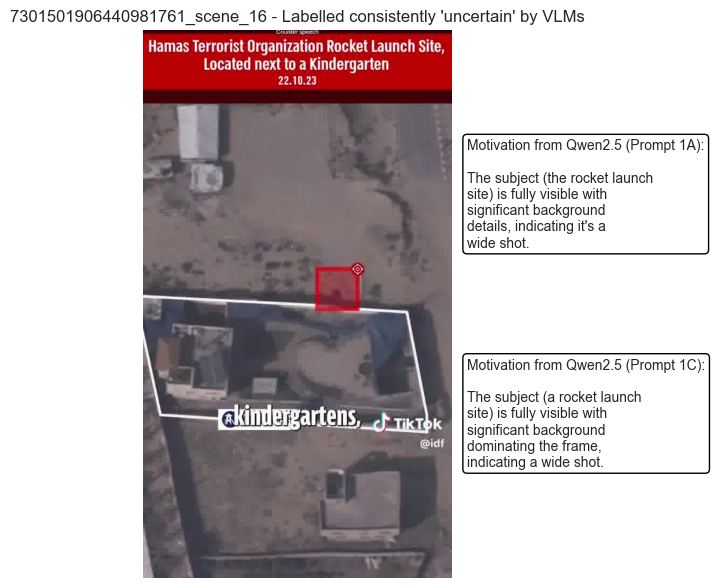

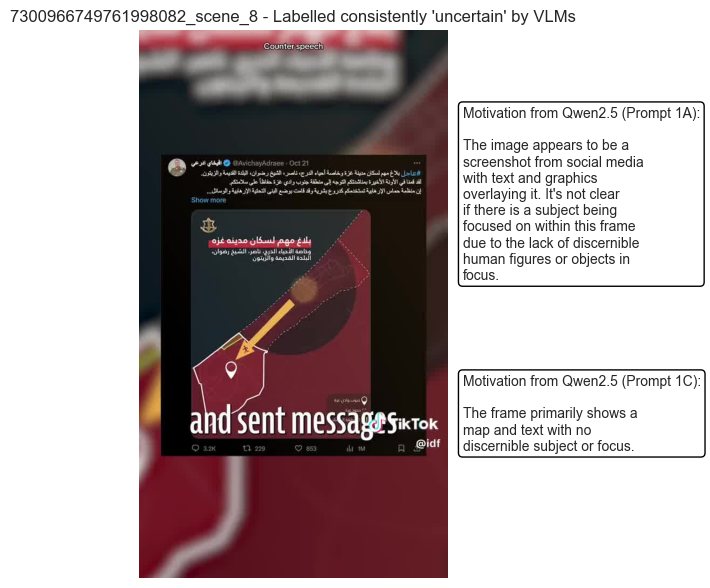

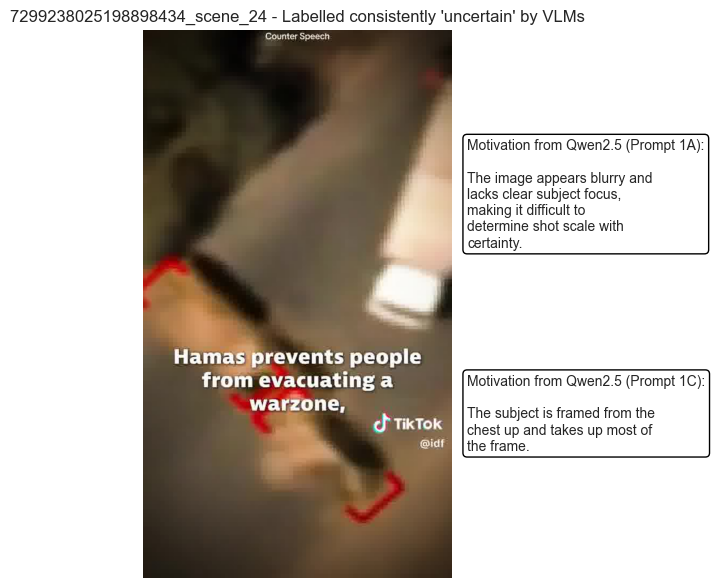

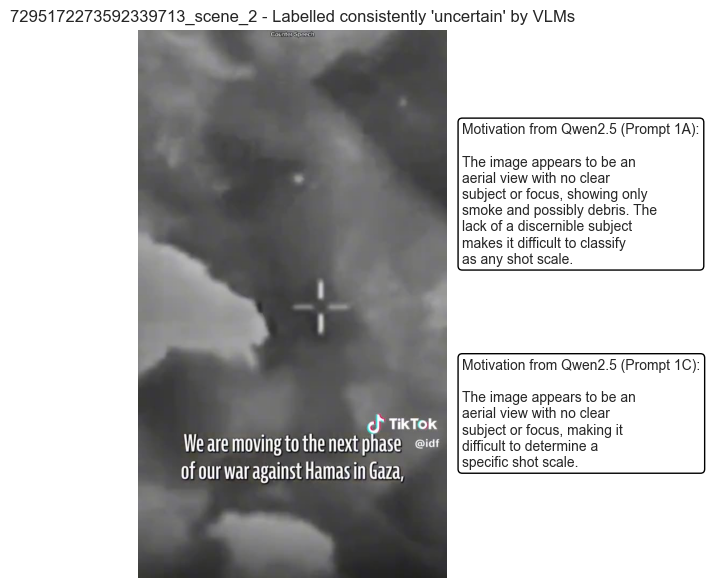

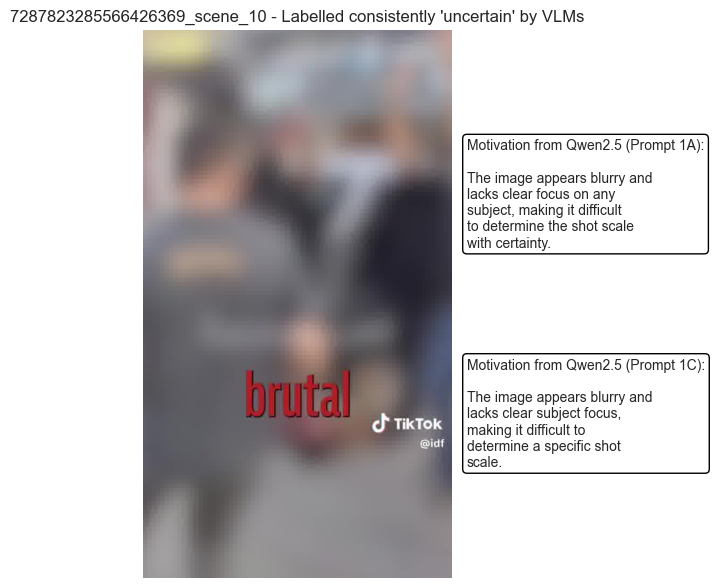

In [132]:
# Visualize and show "Uncertain" thumbnails
for index, scene in df_uncertain_threshold.iterrows():
    video_id = scene['url']
    scene_id = scene['id']

    cleaned_id = re.sub(r'\.mp4', '', scene_id)
    image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')
    image = read_rgb(image_path)

    max_width = 30

    # Retrieve motivations
    motivation_a = textwrap.fill(scene['shot_scale_vlm_1a_04_motivation'], width=max_width)
    motivation_a = 'Motivation from Qwen2.5 (Prompt 1A):\n\n' + motivation_a
    motivation_c = textwrap.fill(scene['shot_scale_vlm_1c_04_motivation'], width=max_width)
    motivation_c = 'Motivation from Qwen2.5 (Prompt 1C):\n\n' + motivation_c

    plt.figure(figsize=(6, 12))
    plt.title(f"{cleaned_id} - Labelled consistently 'uncertain' by VLMs")

    # Annotate on the middle-right side of the image
    plt.annotate(
        motivation_a,
        xy=(1.05, 0.7),  # Position: 1.05 means slightly to the right of the axes
        xycoords='axes fraction',  # Position relative to axes (not data coordinates)
        fontsize=10,
        ha='left',  # Align text to the left
        va='center',  # Vertically centered
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')  # Add highlight box
    )

    plt.annotate(
        motivation_c,
        xy=(1.05, 0.3),  # Position: 1.05 means slightly to the right of the axes
        xycoords='axes fraction',  # Position relative to axes (not data coordinates)
        fontsize=10,
        ha='left',  # Align text to the left
        va='center',  # Vertically centered
        bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')  # Add highlight box
    )
    plt.imshow(image)
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout()
    plt.show()





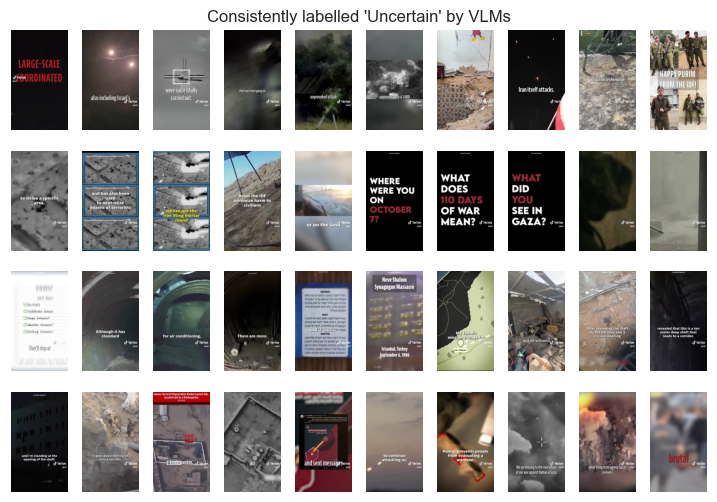

In [26]:
plt.figure(figsize=(9, 6))
# plt.subplots(2,10)
plt.title("Consistently labelled 'Uncertain' by VLMs")

plt.axis('off')
plt.grid(False)

for index, scene in df_uncertain_threshold.iterrows():
    video_id = scene['url']
    scene_id = scene['id']

    cleaned_id = re.sub(r'\.mp4', '', scene_id)
    image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')
    image = read_rgb(image_path)
    plt.subplot(4, 10, index+1)
    plt.imshow(image)
    plt.axis('off')
    plt.grid(False)

plt.savefig(os.path.join(viz_output,'uncertain_majority.svg'),dpi=300)
plt.show()


#### Replacing Main Run 'Uncertain' responses
1. If an entry is 'Uncertain' but it has a non-uncertain aggregate response (ie the other two entries from the same prompt-model permutation are "certain"), it will be replaced by the aggregate response
2. If an entry is 'Uncertain' and its aggregate response across the three prompt runs is also "Uncertain", it will be manually reviewed and replaced by its filler run.
3. If its filler run happens to also be "Uncertain", the thumbnail and others from the same video will need to be removed from the dataset entirely.

In [28]:
df_final = df_norm.copy()
# Step 1: Identify and replace "Uncertain" in main prompt runs

# Obtain column list of main prompt runs
main_prompt_cols = [col for col in df_final.columns if "shot_scale_vlm" in col and "filler" not in col and "qwen" not in col and "04" not in col and "09" not in col]
    # Skips filler, aggregate and supp. motivation

# Initialize uncertain replacement log
replacement_failure = []

# Loop through scenes
for i, scene in df_final.iterrows():
    for col in main_prompt_cols:

        # Check if annotation is "Uncertain"
        if scene[col] != "Uncertain":
            continue # Skip and move on

        # Uncertain means need to replace

        # Identify model and matching aggregate and filler run
        qwen2_5_runs = ['01', '02', '03']
        qwen2_runs = ['06', '07', '08']

        run_no = col[-2:]
        if run_no in qwen2_5_runs:
            model = 'qwen2.5'
            filler_run = col[:-2] + '05_filler'
        elif run_no in qwen2_runs:
            model = 'qwen2'

            filler_run = col[:-2] + '10_filler'
        else:
            raise ValueError(f"Unexpected run number: {run_no}")

        aggregate_col = col[:18] + model
        # Check value from aggregate column
        aggregate_label = scene[aggregate_col]
        if aggregate_label != "Uncertain":
            df_final.at[i, col] = aggregate_label # Replace
            # print(f"'Uncertain' replaced by {aggregate_label} at {scene['id']}: {col} from aggregate") # Debug
            continue # Move on

        # Step 2: Replace with filler run

        # Check value from filler
        filler_label = scene[filler_run]
        if filler_label != "Uncertain":
            df_final.at[i, col] = filler_label # Replace if its
            # print(f"'Uncertain' replaced by {filler_label} at {scene['id']}: {col} from filler") # Debug
            continue # Move on

        # Step 3: Both layers fell through!
        # log
        print(f"Unable to replace 'Uncertain' at {scene['id']}: {col}")
        replacement_failure.append({'id': scene['id'],
                                          'url': scene['url'],
                                          'uncertain_col': col,
                                          'aggregate_col': aggregate_col,
                                          })

df_replacement_failure = pd.DataFrame(replacement_failure)
df_replacement_failure

Unable to replace 'Uncertain' at 7349653141559741704.mp4_scene_14: shot_scale_vlm_1b_06
Unable to replace 'Uncertain' at 7349653141559741704.mp4_scene_14: shot_scale_vlm_1b_08
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_21: shot_scale_vlm_1a_06
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_21: shot_scale_vlm_1a_07
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_21: shot_scale_vlm_1a_08
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_28: shot_scale_vlm_1b_07
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_28: shot_scale_vlm_1b_08
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1a_06
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1a_07
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1a_08
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1b_07
Unable to replace 'Uncertain' at

id                  url  \
0   7349653141559741704.mp4_scene_14  7349653141559741704   
1   7349653141559741704.mp4_scene_14  7349653141559741704   
2   7347367797426736386.mp4_scene_21  7347367797426736386   
3   7347367797426736386.mp4_scene_21  7347367797426736386   
4   7347367797426736386.mp4_scene_21  7347367797426736386   
5   7347367797426736386.mp4_scene_28  7347367797426736386   
6   7347367797426736386.mp4_scene_28  7347367797426736386   
7   7347367797426736386.mp4_scene_30  7347367797426736386   
8   7347367797426736386.mp4_scene_30  7347367797426736386   
9   7347367797426736386.mp4_scene_30  7347367797426736386   
10  7347367797426736386.mp4_scene_30  7347367797426736386   
11  7347367797426736386.mp4_scene_41  7347367797426736386   
12  7347367797426736386.mp4_scene_41  7347367797426736386   
13  7347367797426736386.mp4_scene_41  7347367797426736386   

           uncertain_col            aggregate_col  
0   shot_scale_vlm_1b_06  shot_scale_vlm_1b_qwen2  
1   shot_scale_vlm_1b_08  shot_scale_vlm_1b_qwen2  
2   shot_scale_vlm_1a_06  shot_scale_vlm_1a_qwen2  
3   shot_scale_vlm_1a_07  shot_scale_vlm_1a_qwen2  
4   shot_scale_vlm_1a_08  shot_scale_vlm_1a_qwen2  
5   shot_scale_vlm_1b_07  shot_scale_vlm_1b_qwen2  
6   shot_scale_vlm_1b_08  shot_scale_vlm_1b_qwen2  
7   shot_scale_vlm_1a_06  shot_scale_vlm_1a_qwen2  
8   shot_scale_vlm_1a_07  shot_scale_vlm_1a_qwen2  
9   shot_scale_vlm_1a_08  shot_scale_vlm_1a_qwen2  
10  shot_scale_vlm_1b_07  shot_scale_vlm_1b_qwen2  
11  shot_scale_vlm_1a_06  shot_scale_vlm_1a_qwen2  
12  shot_scale_vlm_1a_07  shot_scale_vlm_1a_qwen2  
13  shot_scale_vlm_1a_08  shot_scale_vlm_1a_qwen2

In [29]:
# Replace 'Uncertain' aggregate results
aggregate_cols = [col for col in df_norm.columns if "qwen2.5" in col or "qwen2" in col]
replacement_failure_agg = []


# Loop through scenes
for i, scene in df_final.iterrows():
    for col in aggregate_cols:
        if scene[col] != "Uncertain": # Check if Uncertain
            continue # Skip and move on

        # Uncertain = need to replace

        # Identify model and matching filler run

        if "qwen2.5" in col:
            model = 'qwen2.5'
            filler_run = col[:18] + '05_filler'
        elif "qwen2" in col:
            model = 'qwen2'
            filler_run = col[:18] + '10_filler'
        else:
            raise ValueError(f"Unexpected run number: {run_no}")

        filler_label = scene[filler_run]
        if filler_label != "Uncertain":
            df_final.at[i, col] = filler_label # Replace if its not uncertain
            # print(f"'Uncertain' replaced by {filler_label} at {scene['id']}: {col} from filler") # Debug
            continue # Move on

        # Step 3: Both layers fell through!
        # log
        print(f"Unable to replace 'Uncertain' at {scene['id']}: {col}")
        replacement_failure_agg.append({'id': scene['id'],
                                          'url': scene['url'],
                                          'uncertain_col': col,
                                        'filler_run' : filler_run
                                          })
df_replacement_failure_agg = pd.DataFrame(replacement_failure_agg)
df_replacement_failure_agg

Unable to replace 'Uncertain' at 7349653141559741704.mp4_scene_14: shot_scale_vlm_1b_qwen2
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_21: shot_scale_vlm_1a_qwen2
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_28: shot_scale_vlm_1b_qwen2
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1a_qwen2
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_30: shot_scale_vlm_1b_qwen2
Unable to replace 'Uncertain' at 7347367797426736386.mp4_scene_41: shot_scale_vlm_1a_qwen2


id                  url  \
0  7349653141559741704.mp4_scene_14  7349653141559741704   
1  7347367797426736386.mp4_scene_21  7347367797426736386   
2  7347367797426736386.mp4_scene_28  7347367797426736386   
3  7347367797426736386.mp4_scene_30  7347367797426736386   
4  7347367797426736386.mp4_scene_30  7347367797426736386   
5  7347367797426736386.mp4_scene_41  7347367797426736386   

             uncertain_col                   filler_run  
0  shot_scale_vlm_1b_qwen2  shot_scale_vlm_1b_10_filler  
1  shot_scale_vlm_1a_qwen2  shot_scale_vlm_1a_10_filler  
2  shot_scale_vlm_1b_qwen2  shot_scale_vlm_1b_10_filler  
3  shot_scale_vlm_1a_qwen2  shot_scale_vlm_1a_10_filler  
4  shot_scale_vlm_1b_qwen2  shot_scale_vlm_1b_10_filler  
5  shot_scale_vlm_1a_qwen2  shot_scale_vlm_1a_10_filler

In [30]:
df_replacement_failure.to_csv(os.path.join(data_output, 'idf_data_shot_scale_vlm_replacement_failure.csv'))

In [31]:
df_replacement_failure = pd.read_csv(os.path.join(data_output, 'idf_data_shot_scale_vlm_replacement_failure.csv'))

In [32]:
replacement_failure_list = list(df_replacement_failure['id'].unique())

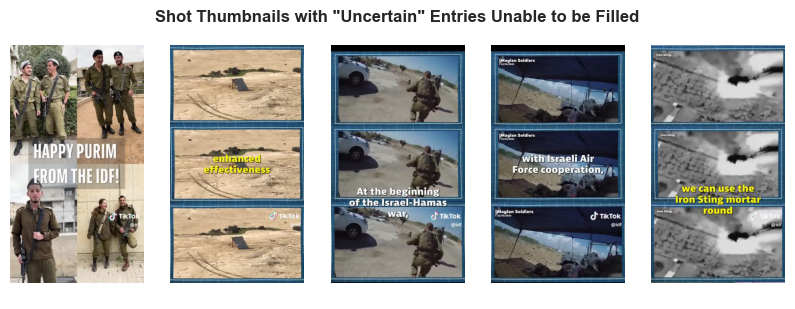

In [35]:
plt.figure(figsize=(10, 3.5))
# plt.subplots(2,10)
plt.title('Shot Thumbnails with "Uncertain" Entries Unable to be Filled', fontweight='bold')

plt.axis('off')
plt.grid(False)

for index, scene in enumerate(replacement_failure_list):

    scene_id = scene
    video_id = int(scene[:19])

    cleaned_id = re.sub(r'\.mp4', '', scene_id)
    image_path = os.path.join(frames_folder, str(video_id), f'{cleaned_id}.jpeg')
    image = read_rgb(image_path)
    plt.subplot(1, 5, index+1)
    plt.imshow(image)
    plt.axis('off')
    plt.grid(False)


plt.show()

As inspected, there are a few consistently uncertain entries that cannot be replaced due to the fact that its filler data was replaced by "uncertain" during the data cleaning process. This specifically affects five scenes. They will be removed from agreement analysis.

In [159]:
df_final = df_final[~df_final['id'].isin(replacement_failure_list)]
len(df_final)

1437

In [160]:
df_final.to_csv(os.path.join(data_output, '05_idf_data_vlm_evaluation_final.csv'))

## Calculating intercoder agreement
We will now compare the relative agreement of each to the primary coding (myself). This would be done through calculating the K-Alpha score (using ordinal variables only) and calculating the mean signed difference (MSD). This will be done on the cleaned dataset with "Uncertain" responses either filled using filler supplementary run, or


In [162]:
df_final = pd.read_csv(os.path.join(os.path.join(data_output, '05_idf_data_vlm_evaluation_final.csv')))

### Mean Signed Difference (MSD)
On top of using K-Alpha to calculate the magnitude of agreement, the mean signed difference helps to provide insight as to the direction of disagreement. This is helpful in the context of shot scale analysis where it is helpful to understand whether an annotator is biased in classifying shots nearer or further.

In [163]:
# Calculate mean signed difference relative to the primary coder
def calc_msd(df, column_name):
    '''
    Calculates the mean signed difference between the primary coder and a secondary column.


    '''

    # Define ordinal scale for refactoring
    # Ordered from closest to further from the camera
    ordinal_scale = {
        'Close up': 1,
        'Medium close up': 2,
        'Medium shot': 3,
        'Medium full shot': 4,
        'Full shot' : 5,
        'Wide shot': 6,
        'Empty': 7,
        }

    df_copy = df[['id','shot_scale_m', column_name]].copy() # Make copy of dataframe for refactoring; Only the desired columns

    for i, scene in df_copy.iterrows():
          pri_label = scene['shot_scale_m']
          sec_label = scene[column_name]

          # Assertions
          assert pri_label in ordinal_scale.keys(), f"Unexpected primary label: {pri_label} for {scene[id]}"
          assert sec_label in ordinal_scale.keys(), f"Unexpected secondary label: {sec_label} for {scene[id]}"

          # Calculate difference
          pri_rank = ordinal_scale[scene['shot_scale_m']]
          sec_rank = ordinal_scale[scene[column_name]]
          df_copy.at[i, 'difference'] = sec_rank - pri_rank

    msd = df_copy['difference'].mean()
    print(f"Mean signed difference for 'shot_scale_m' and {column_name}: {msd:.3f}\n")
    return msd


### Benchmark 1: Human-Human coding

In [191]:
# Create dataframe to store all intercoder agreements
df_intercoder_agr = pd.DataFrame({
    'benchmark_col': pd.Series(dtype='object'),
    'target_col': pd.Series(dtype='object'),
    'target_annotator': pd.Series(dtype='object'),
    'alpha': pd.Series(dtype='float'),
    'msd': pd.Series(dtype='float'),
    })

In [192]:
# All primary coding is labelled with '_m'
# All secondary coding is labelled with '_c'

# Calculate intercoder agreement between human coders
alpha_h2h, rows_with_nan = calc_k_alpha_shot_scale_ord(df_final,['shot_scale_m', 'shot_scale_c'])

# If there are rows removed, something is very wrong

# Calculate msd
msd_h2h = calc_msd(df_final, 'shot_scale_c')

# Add to dataset
df_h2h = pd.DataFrame({'benchmark_col': ['shot_scale_m'],
                       'target_col': ['shot_scale_c'],
                       'target_annotator': ['human'],
                       'alpha': [alpha_h2h],
                       'msd': [msd_h2h]
                       })
df_intercoder_agr = pd.concat([df_intercoder_agr, df_h2h], ignore_index=True)

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_c']: 0.919
Mean signed difference for 'shot_scale_m' and shot_scale_c: -0.001



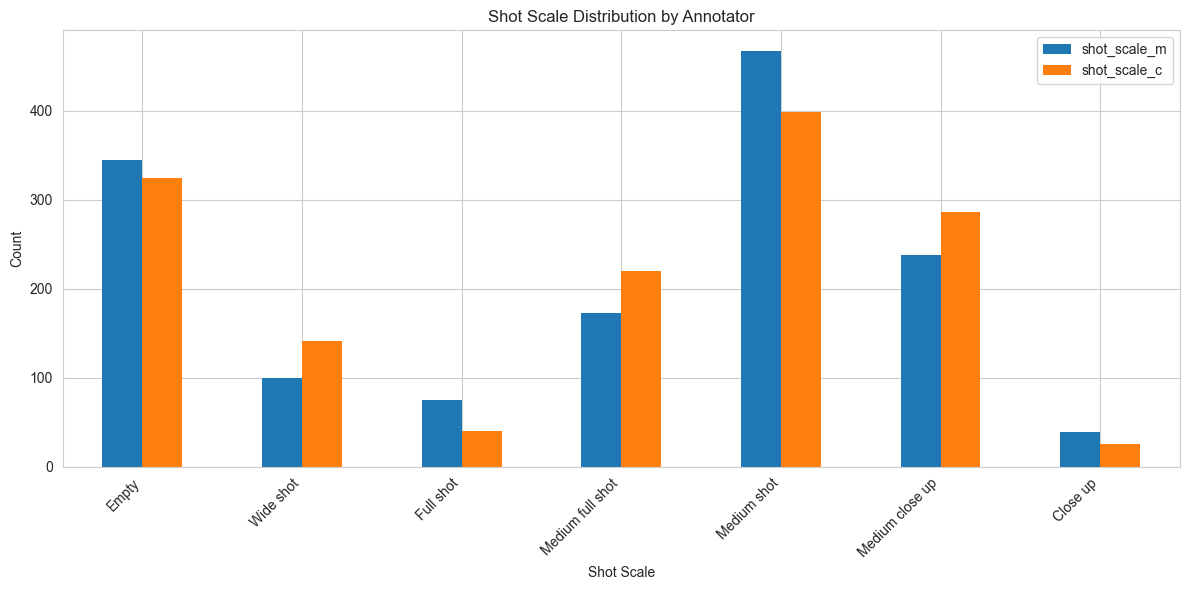

In [167]:
# Comparison of distribution for shot counts
# Count the values for each shot scale in both columns
shot_scale_m_counts = df_final['shot_scale_m'].value_counts()
shot_scale_c_counts = df_final['shot_scale_c'].value_counts()

# Combine the counts into a single DataFrame
shot_scale_counts = pd.DataFrame({
    'shot_scale_m': shot_scale_m_counts,
    'shot_scale_c': shot_scale_c_counts
})

# Define the desired order of shot scales
order = ['Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up']

# Reindex the DataFrame to match the desired order
shot_scale_counts = shot_scale_counts.reindex(order)

# Plot the bar chart
ax = shot_scale_counts.plot(kind='bar', figsize=(12, 6),edgecolor="none")

# Add labels and title
plt.xlabel('Shot Scale')
plt.ylabel('Count')
plt.title('Shot Scale Distribution by Annotator')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(viz_output, 'shot_scale_distribution_h2h.svg'))
plt.show()


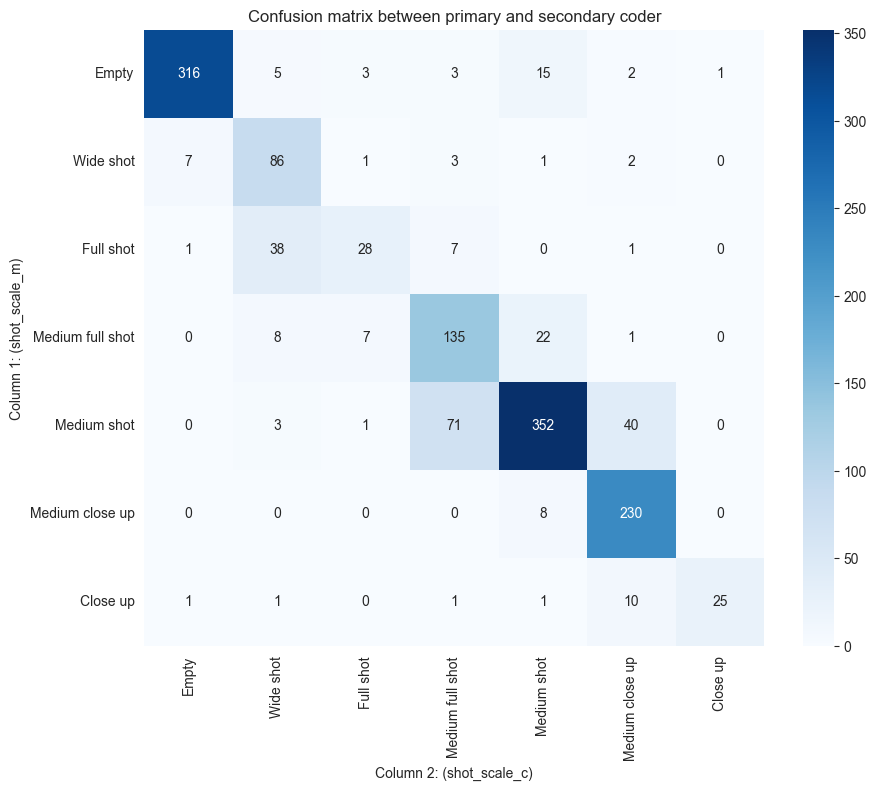

In [168]:
plot_confusion_matrix(df_final, 'shot_scale_m', 'shot_scale_c', ['Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up'], title = "Confusion matrix between primary and secondary coder")
plt.savefig(os.path.join(viz_output, 'confusion_matrix_h2h.svg'))
plt.show()

This demonstrates a strong intercoder reliability and sets the benchmark for other methods.

### Benchmark 2: Classification through pose estimation
Next, we measure the agreement between the primary coder and the classifier through pose estimation.

In [170]:
# Stability check - Check the stability of shot_scale_classifier
alpha_cv_stability, rows_with_nan = calc_k_alpha_shot_scale_ord(df_final,['shot_scale_classifier_1', 'shot_scale_classifier_2','shot_scale_classifier_3'])

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_classifier_1', 'shot_scale_classifier_2', 'shot_scale_classifier_3']: 1.000


This means that the shot scale classifier produced the same results everytime. We can safely use one column to calculate the agreement.

In [193]:
# Calculate K-Alpha between primary and CV classifier
alpha_h2cv, rows_with_nan = calc_k_alpha_shot_scale_ord(df_final,['shot_scale_m', 'shot_scale_classifier_1'])

msd_h2cv = calc_msd(df_final, 'shot_scale_classifier_1')
# add
df_h2cv = pd.DataFrame({'benchmark_col': ['shot_scale_m'],
                       'target_col': ['shot_scale_classifier_1'],
                       'target_annotator': ['computer vision'],
                       'alpha': [alpha_h2cv],
                        'msd' : [msd_h2cv]
                        })
df_intercoder_agr = pd.concat([df_intercoder_agr, df_h2cv], ignore_index=True)

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_classifier_1']: 0.771
Mean signed difference for 'shot_scale_m' and shot_scale_classifier_1: 0.049



In [194]:
df_intercoder_agr

benchmark_col               target_col target_annotator     alpha       msd
0  shot_scale_m             shot_scale_c            human  0.919240 -0.001392
1  shot_scale_m  shot_scale_classifier_1  computer vision  0.770974  0.049408

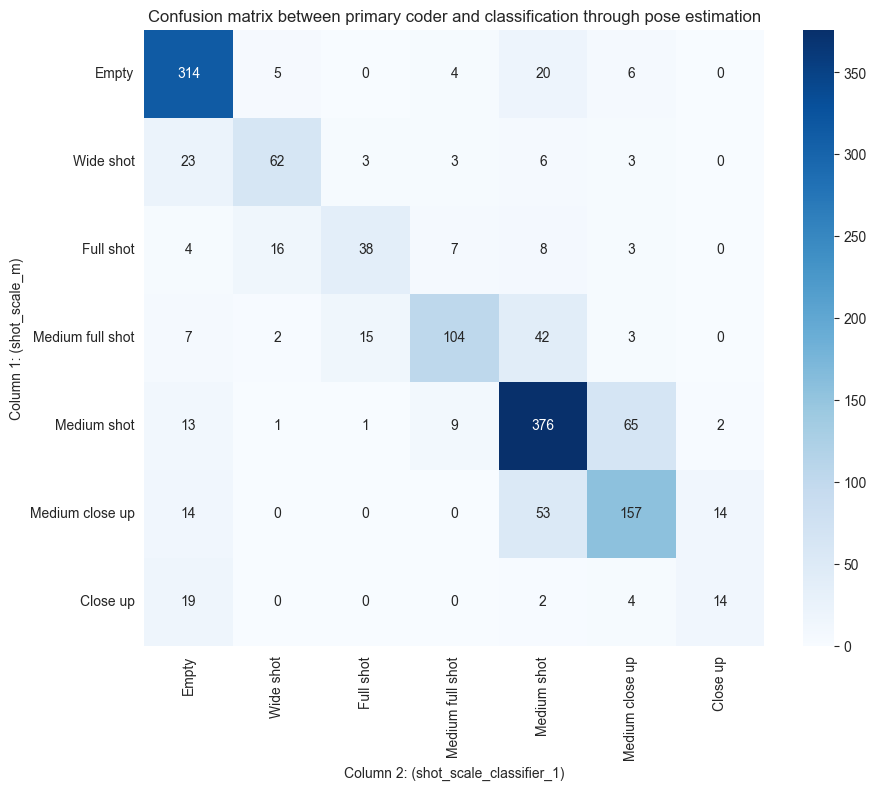

In [174]:
plot_confusion_matrix(df_norm, 'shot_scale_m', 'shot_scale_classifier_1', [ 'Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up'], title = "Confusion matrix between primary coder and classification through pose estimation")
plt.savefig(os.path.join(viz_output, 'confusion_matrix_h2cv.svg'))
plt.show()

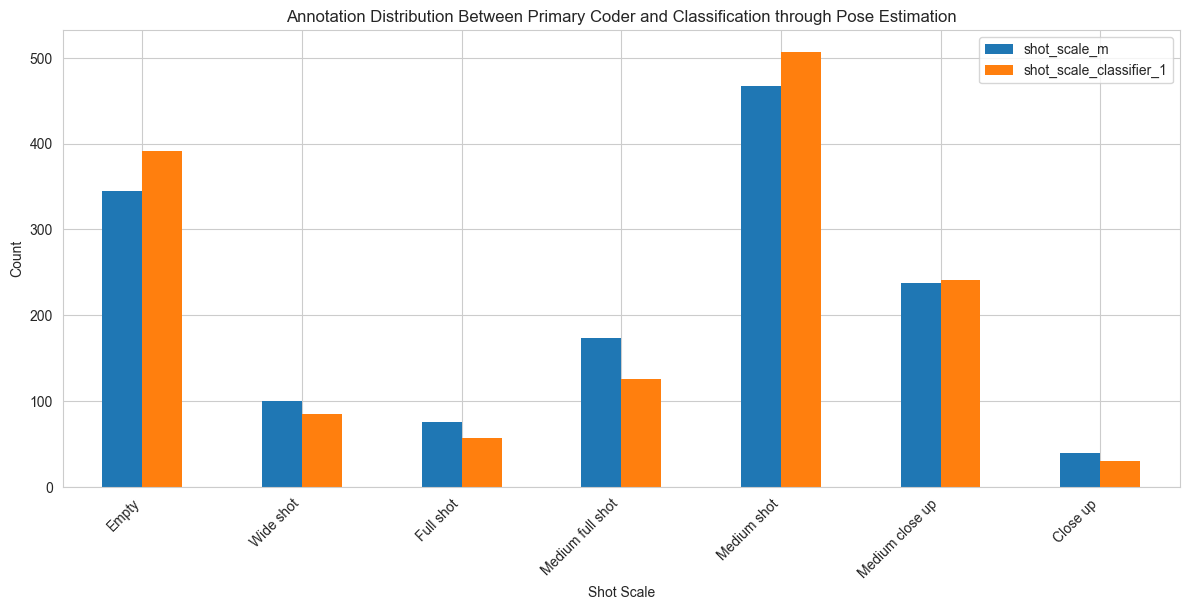

In [176]:
ax = compare_distributions(df_final, ['shot_scale_m', 'shot_scale_classifier_1'])
plt.title('Annotation Distribution Between Primary Coder and Classification through Pose Estimation')
plt.savefig(os.path.join(viz_output, 'shot_scale_distribution_h2cv.svg'))
plt.show()

### Calculate Intercoder Agreement between VLM runs and Primary Coder

In [195]:
# Package agreement calculation functions into one function for vlms that updates df_intercoder_agr

def calc_agreements_vlm(df_intercoder_agr, df_norm, target_col):
    # Calculate K-Alpha between primary and CV classifier
    alpha, rows_with_nan = calc_k_alpha_shot_scale_ord(df_norm,['shot_scale_m', target_col])

    assert rows_with_nan == 0, f"Unexpected number of rows with NaN: {rows_with_nan}"

    msd = calc_msd(df_norm, target_col)
    qwen2_5_runs = ['01', '02', '03']
    qwen2_runs = ['06', '07', '08']

    if "qwen2.5" in target_col:
        target_anno = "qwen2.5"
    elif "qwen2" in target_col:
        target_anno = "qwen2"
    else:
        target_anno = None
        for run in qwen2_5_runs:
            if run in target_col:
                target_anno = "qwen2.5"
                break
        if target_anno is None:
                for run in qwen2_runs:
                    if run in target_col:
                        target_anno = "qwen2"
        if target_anno is None:
                target_anno = "unknown"


    # Update df
    df_results = pd.DataFrame({'benchmark_col': ['shot_scale_m'],
                          'target_col': [target_col],
                          'target_annotator': [target_anno],
                          'alpha': [alpha],
                            'msd' : [msd]
                            })
    df_intercoder_agr = pd.concat([df_intercoder_agr, df_results], ignore_index=True)
    return df_intercoder_agr


In [180]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       1437 non-null   int64  
 1   id                               1437 non-null   object 
 2   url                              1437 non-null   int64  
 3   start_frame                      1437 non-null   int64  
 4   start_time                       1437 non-null   object 
 5   end_frame                        1437 non-null   int64  
 6   end_time                         1437 non-null   object 
 7   end_fps                          1437 non-null   float64
 8   scene_num                        1437 non-null   int64  
 9   num_scenes_detected              1437 non-null   int64  
 10  total_video_frames               1437 non-null   int64  
 11  total_video_duration             1437 non-null   object 
 12  face_locations_list 

In [196]:
# Obtain desired columns
target_cols = [col for col in df_final.columns if "shot_scale_vlm" in col and "filler" not in col and "04" not in col and "09" not in col]

for col in target_cols:
    df_intercoder_agr = calc_agreements_vlm(df_intercoder_agr, df_final, col)

df_intercoder_agr

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_vlm_1a_01']: 0.373
Mean signed difference for 'shot_scale_m' and shot_scale_vlm_1a_01: -1.564

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_vlm_1a_02']: 0.382
Mean signed difference for 'shot_scale_m' and shot_scale_vlm_1a_02: -1.551

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_vlm_1a_03']: 0.376
Mean signed difference for 'shot_scale_m' and shot_scale_vlm_1a_03: -1.557

Number of rows with NaN values/'Uncertain' (excluded from calculation): 0
Krippendorff’s alpha (ordinal) for ['shot_scale_m', 'shot_scale_vlm_1a_06']: 0.508
Mean signed difference for 'shot_scale_m' and shot_scale_vlm_1a_06: -1.154

Number of rows with NaN values/'Uncertain' (excluded from calculatio

benchmark_col                 target_col target_annotator     alpha  \
0   shot_scale_m               shot_scale_c            human  0.919240   
1   shot_scale_m    shot_scale_classifier_1  computer vision  0.770974   
2   shot_scale_m       shot_scale_vlm_1a_01          qwen2.5  0.372894   
3   shot_scale_m       shot_scale_vlm_1a_02          qwen2.5  0.382082   
4   shot_scale_m       shot_scale_vlm_1a_03          qwen2.5  0.376397   
5   shot_scale_m       shot_scale_vlm_1a_06            qwen2  0.507965   
6   shot_scale_m       shot_scale_vlm_1a_07            qwen2  0.499280   
7   shot_scale_m       shot_scale_vlm_1a_08            qwen2  0.507544   
8   shot_scale_m       shot_scale_vlm_1b_01          qwen2.5  0.263089   
9   shot_scale_m       shot_scale_vlm_1b_02          qwen2.5  0.274703   
10  shot_scale_m       shot_scale_vlm_1b_03          qwen2.5  0.271823   
11  shot_scale_m       shot_scale_vlm_1b_06            qwen2  0.200875   
12  shot_scale_m       shot_scale_vlm_1b_07            qwen2  0.214694   
13  shot_scale_m       shot_scale_vlm_1b_08            qwen2  0.212993   
14  shot_scale_m       shot_scale_vlm_1c_01          qwen2.5  0.478704   
15  shot_scale_m       shot_scale_vlm_1c_02          qwen2.5  0.473632   
16  shot_scale_m       shot_scale_vlm_1c_03          qwen2.5  0.478510   
17  shot_scale_m       shot_scale_vlm_1c_06            qwen2  0.390771   
18  shot_scale_m       shot_scale_vlm_1c_07            qwen2  0.382437   
19  shot_scale_m       shot_scale_vlm_1c_08            qwen2  0.380865   
20  shot_scale_m  shot_scale_vlm_1a_qwen2.5          qwen2.5  0.375264   
21  shot_scale_m    shot_scale_vlm_1a_qwen2            qwen2  0.503367   
22  shot_scale_m  shot_scale_vlm_1b_qwen2.5          qwen2.5  0.276054   
23  shot_scale_m    shot_scale_vlm_1b_qwen2            qwen2  0.201506   
24  shot_scale_m  shot_scale_vlm_1c_qwen2.5          qwen2.5  0.482426   
25  shot_scale_m    shot_scale_vlm_1c_qwen2            qwen2  0.374018   

         msd  
0  -0.001392  
1   0.049408  
2  -1.564370  
3  -1.551148  
4  -1.557411  
5  -1.153793  
6  -1.148921  
7  -1.141962  
8  -1.289492  
9  -1.269311  
10 -1.274182  
11 -1.808629  
12 -1.789144  
13 -1.786360  
14 -1.332637  
15 -1.342380  
16 -1.338205  
17 -1.421016  
18 -1.425191  
19 -1.422408  
20 -1.559499  
21 -1.167711  
22 -1.269311  
23 -1.807237  
24 -1.331942  
25 -1.441197

In [202]:
# Calculate mean for main runs

prompt_run_grps = {"1a_qwen2.5_mean": ['shot_scale_vlm_1a_01', 'shot_scale_vlm_1a_02', 'shot_scale_vlm_1a_03'],
                   "1a_qwen2_mean": ['shot_scale_vlm_1a_06', 'shot_scale_vlm_1a_07', 'shot_scale_vlm_1a_08'],
                   "1b_qwen2.5_mean": ['shot_scale_vlm_1b_01', 'shot_scale_vlm_1b_02', 'shot_scale_vlm_1b_03'],
                   "1b_qwen2_mean": ['shot_scale_vlm_1b_06', 'shot_scale_vlm_1b_07', 'shot_scale_vlm_1b_08'],
                   "1c_qwen2.5_mean": ['shot_scale_vlm_1c_01', 'shot_scale_vlm_1c_02', 'shot_scale_vlm_1c_03'],
                   "1c_qwen2_mean": ['shot_scale_vlm_1c_06', 'shot_scale_vlm_1c_07', 'shot_scale_vlm_1c_08'],}

for mean_name, run_list in prompt_run_grps.items():

    alpha_sum = 0
    msd_sum = 0
    for run in run_list:
        target_run = df_intercoder_agr[df_intercoder_agr['target_col'] == run]
        alpha = target_run['alpha'].values[0]
        msd = target_run['msd'].values[0]
        # print(f"Alpha for {run}: {alpha}")
        # print(f"MSD for {run}: {msd}")
        alpha_sum += alpha
        msd_sum += msd
    mean_alpha = alpha_sum / 3
    mean_msd = msd_sum / 3

    if "qwen2.5" in mean_name:
        target_anno = "qwen2.5"
    elif "qwen2" in mean_name:
        target_anno = "qwen2"

    # Update df
    df_results = pd.DataFrame({'benchmark_col': ['shot_scale_m'],
                          'target_col': [mean_name],
                          'target_annotator': [target_anno],
                          'alpha': [mean_alpha],
                            'msd' : [mean_msd]
                            })
    df_intercoder_agr = pd.concat([df_intercoder_agr, df_results], ignore_index=True)





In [212]:
df_intercoder_agr

benchmark_col                 target_col target_annotator     alpha  \
0   shot_scale_m               shot_scale_c            human  0.919240   
1   shot_scale_m    shot_scale_classifier_1  computer vision  0.770974   
2   shot_scale_m       shot_scale_vlm_1a_01          qwen2.5  0.372894   
3   shot_scale_m       shot_scale_vlm_1a_02          qwen2.5  0.382082   
4   shot_scale_m       shot_scale_vlm_1a_03          qwen2.5  0.376397   
5   shot_scale_m       shot_scale_vlm_1a_06            qwen2  0.507965   
6   shot_scale_m       shot_scale_vlm_1a_07            qwen2  0.499280   
7   shot_scale_m       shot_scale_vlm_1a_08            qwen2  0.507544   
8   shot_scale_m       shot_scale_vlm_1b_01          qwen2.5  0.263089   
9   shot_scale_m       shot_scale_vlm_1b_02          qwen2.5  0.274703   
10  shot_scale_m       shot_scale_vlm_1b_03          qwen2.5  0.271823   
11  shot_scale_m       shot_scale_vlm_1b_06            qwen2  0.200875   
12  shot_scale_m       shot_scale_vlm_1b_07            qwen2  0.214694   
13  shot_scale_m       shot_scale_vlm_1b_08            qwen2  0.212993   
14  shot_scale_m       shot_scale_vlm_1c_01          qwen2.5  0.478704   
15  shot_scale_m       shot_scale_vlm_1c_02          qwen2.5  0.473632   
16  shot_scale_m       shot_scale_vlm_1c_03          qwen2.5  0.478510   
17  shot_scale_m       shot_scale_vlm_1c_06            qwen2  0.390771   
18  shot_scale_m       shot_scale_vlm_1c_07            qwen2  0.382437   
19  shot_scale_m       shot_scale_vlm_1c_08            qwen2  0.380865   
20  shot_scale_m  shot_scale_vlm_1a_qwen2.5          qwen2.5  0.375264   
21  shot_scale_m    shot_scale_vlm_1a_qwen2            qwen2  0.503367   
22  shot_scale_m  shot_scale_vlm_1b_qwen2.5          qwen2.5  0.276054   
23  shot_scale_m    shot_scale_vlm_1b_qwen2            qwen2  0.201506   
24  shot_scale_m  shot_scale_vlm_1c_qwen2.5          qwen2.5  0.482426   
25  shot_scale_m    shot_scale_vlm_1c_qwen2            qwen2  0.374018   
26  shot_scale_m            1a_qwen2.5_mean          qwen2.5  0.377124   
27  shot_scale_m              1a_qwen2_mean            qwen2  0.504930   
28  shot_scale_m            1b_qwen2.5_mean          qwen2.5  0.269872   
29  shot_scale_m              1b_qwen2_mean            qwen2  0.209521   
30  shot_scale_m            1c_qwen2.5_mean          qwen2.5  0.476949   
31  shot_scale_m              1c_qwen2_mean            qwen2  0.384691   

         msd  
0  -0.001392  
1   0.049408  
2  -1.564370  
3  -1.551148  
4  -1.557411  
5  -1.153793  
6  -1.148921  
7  -1.141962  
8  -1.289492  
9  -1.269311  
10 -1.274182  
11 -1.808629  
12 -1.789144  
13 -1.786360  
14 -1.332637  
15 -1.342380  
16 -1.338205  
17 -1.421016  
18 -1.425191  
19 -1.422408  
20 -1.559499  
21 -1.167711  
22 -1.269311  
23 -1.807237  
24 -1.331942  
25 -1.441197  
26 -1.557643  
27 -1.148225  
28 -1.277662  
29 -1.794711  
30 -1.337741  
31 -1.422872

In [211]:
df_benchmark = df_intercoder_agr[~df_intercoder_agr['target_annotator'].str.contains('qwen')]
df_benchmark

benchmark_col               target_col target_annotator     alpha       msd
0  shot_scale_m             shot_scale_c            human  0.919240 -0.001392
1  shot_scale_m  shot_scale_classifier_1  computer vision  0.770974  0.049408

In [232]:
# Filter to only have the relevant target_columns for visualization
df_intercoder_viz = pd.DataFrame()

df_vlm_aggregates = df_intercoder_agr[df_intercoder_agr['target_col'].str.contains('qwen')]
for i, row in df_vlm_aggregates.iterrows():
    if 'mean' in row['target_col']:
        aggregate_type = 'mean'
    else:
        aggregate_type = 'majority'

    if '1a' in row['target_col']:
        prompt = '1a'
    elif '1b' in row['target_col']:
        prompt = '1b'
    elif '1c' in row['target_col']:
        prompt = '1c'

    if 'qwen2.5' in row['target_col']:
        model_name = 'Qwen2.5-VL'
    elif 'qwen2' in row['target_col']:
        model_name = 'Qwen2-VL'

    alpha = row['alpha']
    msd = row['msd']

    df_new_row = pd.DataFrame({'target_col': [row['target_col']],
                               'model_name': [model_name],
                               'aggregate_type': [aggregate_type],
                               'prompt': [prompt],
                               'alpha': [alpha],
                               'msd': [msd]
                               })
    df_intercoder_viz = pd.concat([df_intercoder_viz, df_new_row], ignore_index=True)
df_intercoder_viz



target_col  model_name aggregate_type prompt     alpha  \
0   shot_scale_vlm_1a_qwen2.5  Qwen2.5-VL       majority     1a  0.375264   
1     shot_scale_vlm_1a_qwen2    Qwen2-VL       majority     1a  0.503367   
2   shot_scale_vlm_1b_qwen2.5  Qwen2.5-VL       majority     1b  0.276054   
3     shot_scale_vlm_1b_qwen2    Qwen2-VL       majority     1b  0.201506   
4   shot_scale_vlm_1c_qwen2.5  Qwen2.5-VL       majority     1c  0.482426   
5     shot_scale_vlm_1c_qwen2    Qwen2-VL       majority     1c  0.374018   
6             1a_qwen2.5_mean  Qwen2.5-VL           mean     1a  0.377124   
7               1a_qwen2_mean    Qwen2-VL           mean     1a  0.504930   
8             1b_qwen2.5_mean  Qwen2.5-VL           mean     1b  0.269872   
9               1b_qwen2_mean    Qwen2-VL           mean     1b  0.209521   
10            1c_qwen2.5_mean  Qwen2.5-VL           mean     1c  0.476949   
11              1c_qwen2_mean    Qwen2-VL           mean     1c  0.384691   

         msd  
0  -1.559499  
1  -1.167711  
2  -1.269311  
3  -1.807237  
4  -1.331942  
5  -1.441197  
6  -1.557643  
7  -1.148225  
8  -1.277662  
9  -1.794711  
10 -1.337741  
11 -1.422872

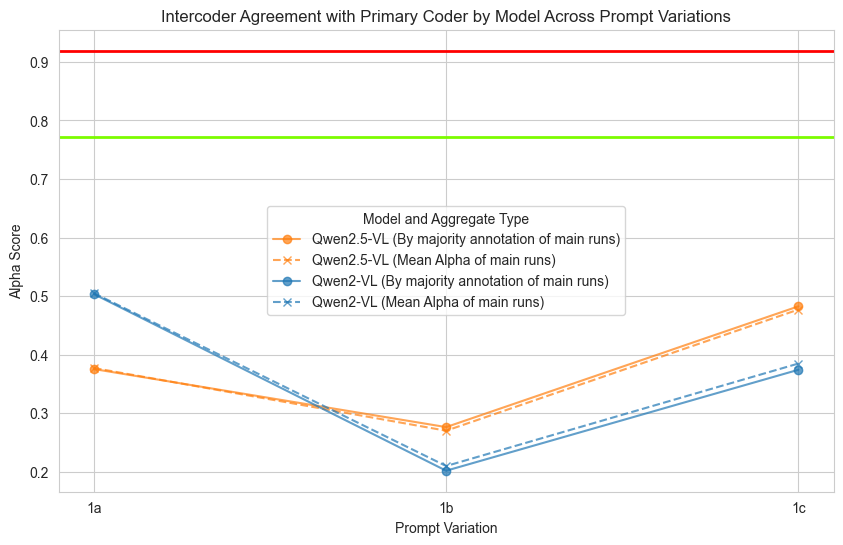

In [233]:
# Visualize Alpha Agreements

# Define colors for each model
model_colors = {
    'Qwen2.5-VL': 'tab:orange',
    'Qwen2-VL': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

# Plot benchmark scores as horizontal lines
benchmark_colors = ['red','lawngreen']
assert len(benchmark_colors) == 2
for i, benchmark in df_benchmark.iterrows():
    plt.axhline(y=benchmark['alpha'], color=benchmark_colors[i], linestyle='-',linewidth=2)
for model in model_colors.keys():
    model_df = df_intercoder_viz[df_intercoder_viz['model_name'] == model]

    # Plot majority
    majority_df = model_df[model_df['aggregate_type'] == 'majority']
    plt.plot(majority_df['prompt'], majority_df['alpha'], marker='o', linestyle='-', color=model_colors[model], label=f'{model} (By majority annotation of main runs)', alpha=0.7)

    # Plot mean
    mean_df = model_df[model_df['aggregate_type'] == 'mean']
    plt.plot(mean_df['prompt'], mean_df['alpha'], marker='x', linestyle='--', color=model_colors[model], label=f'{model} (Mean Alpha of main runs)', alpha=0.7)


plt.xlabel('Prompt Variation')
plt.ylabel('Alpha Score')
plt.title('Intercoder Agreement with Primary Coder by Model Across Prompt Variations')
plt.legend(title='Model and Aggregate Type')
plt.grid(True)
plt.show()



Since the difference between the alpha of the majority annotation and the mean alpha score is extremely negible, only the alpha score of the majority annotation will be presented.

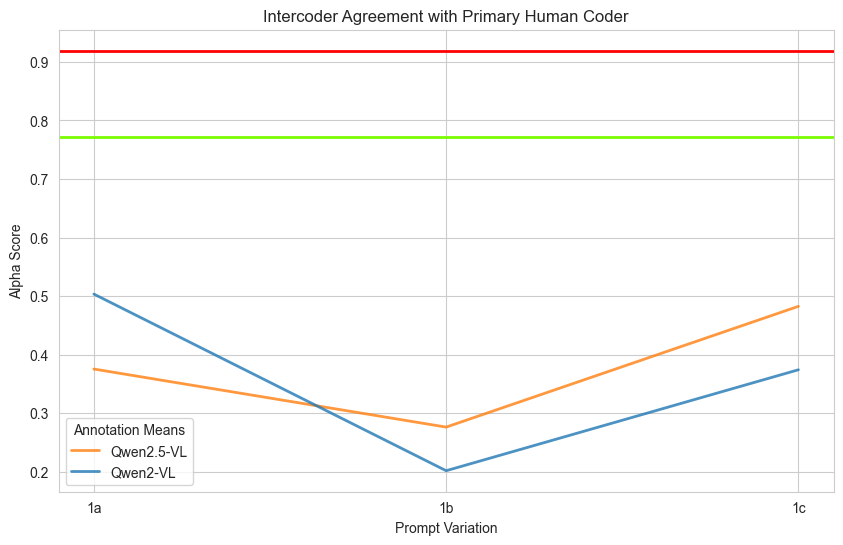

In [251]:
# Visualize Alpha Agreements

# Define colors for each model
model_colors = {
    'Qwen2.5-VL': 'tab:orange',
    'Qwen2-VL': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

# Plot benchmark scores as horizontal lines
benchmark_colors = ['red','lawngreen']
assert len(benchmark_colors) == 2
for i, benchmark in df_benchmark.iterrows():
    plt.axhline(y=benchmark['alpha'], color=benchmark_colors[i], linestyle='-',linewidth=2)
for model in model_colors.keys():
    model_df = df_intercoder_viz[df_intercoder_viz['model_name'] == model]

    # Plot majority
    majority_df = model_df[model_df['aggregate_type'] == 'majority']
    plt.plot(majority_df['prompt'],
             majority_df['alpha'],
             linestyle='-',
             linewidth=2,
             color=model_colors[model],
             label=f'{model}',
             alpha=0.8)

    # # Plot mean
    # mean_df = model_df[model_df['aggregate_type'] == 'mean']
    # plt.plot(mean_df['prompt'], mean_df['alpha'], marker='x', linestyle='--', color=model_colors[model], label=f'{model} (Mean Alpha of main runs)', alpha=0.7)

plt.xlabel('Prompt Variation')
plt.ylabel('Alpha Score')
plt.title('Intercoder Agreement with Primary Human Coder')
plt.legend(title='Annotation Means')
plt.grid(True)
plt.savefig(os.path.join(viz_output, 'intercoder_agr_alpha.svg'),dpi=300)
plt.show()


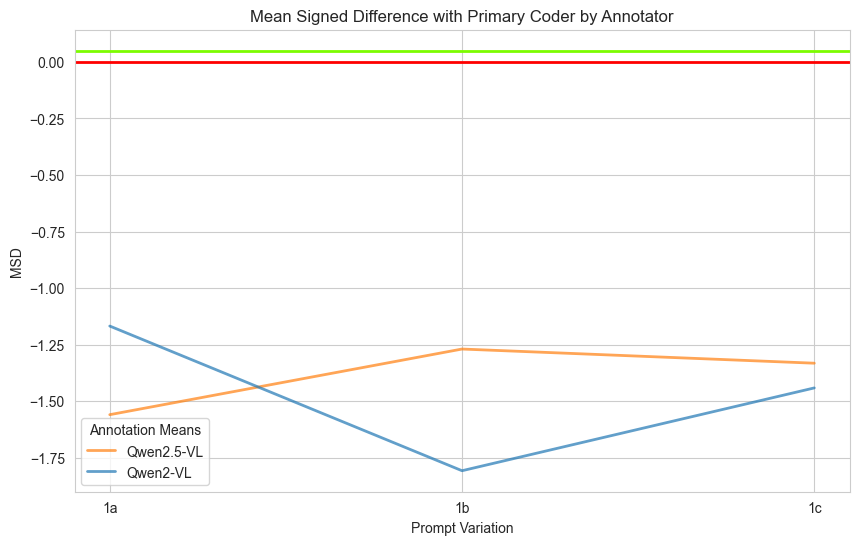

In [246]:
# Repeat for MSD

# Define colors for each model
model_colors = {
    'Qwen2.5-VL': 'tab:orange',
    'Qwen2-VL': 'tab:blue'
}

# Plotting
plt.figure(figsize=(10, 6))

# Plot benchmark scores as horizontal lines
benchmark_colors = ['red','lawngreen']
assert len(benchmark_colors) == 2
for i, benchmark in df_benchmark.iterrows():
    plt.axhline(y=benchmark['msd'], color=benchmark_colors[i], linestyle='-',linewidth=2)
for model in model_colors.keys():
    model_df = df_intercoder_viz[df_intercoder_viz['model_name'] == model]

    # Plot majority aggregate
    majority_df = model_df[model_df['aggregate_type'] == 'majority']
    plt.plot(majority_df['prompt'],
             majority_df['msd'],
             # marker='o',
             linewidth=2,
             linestyle='-',
             color=model_colors[model],
             label=f'{model}', # (By majority annotation of main runs)'
             alpha=0.7)

    # # Plot mean of three main runs
    # mean_df = model_df[model_df['aggregate_type'] == 'mean']
    # plt.plot(mean_df['prompt'], mean_df['msd'], marker='x', linestyle='--', color=model_colors[model], label=f'{model} (Mean Alpha of main runs)', alpha=0.7)


plt.xlabel('Prompt Variation')
plt.ylabel('MSD')
plt.title('Mean Signed Difference with Primary Coder by Annotator')
plt.legend(title='Annotation Means')
plt.grid(True)
plt.savefig(os.path.join(viz_output, 'intercoder_agr_msd.svg'),dpi=300)
plt.show()


Can also review those consistently deemed "Uncertain" - ie majority vote through the VLM.

#### Comparing Implications for the Case Study
Here, we can compare the annotations and apply it to the case study. We split the video/scene datasets into videos that contain only male spokespersons and female spokespersons, and compare the shot scales annotated.
We use the timeline visualization from ViSCAN (Chow and Huang 2025) to provide an overview of the whole video dataset.

In [4]:
# Reload df_final
df_final = pd.read_csv(os.path.join(data_output, '05_idf_data_vlm_evaluation_final.csv'))

In [5]:
# Make sure to convert start_time and end_time to timedelta
df_final['start_time'] = pd.to_timedelta(df_final['start_time'])
df_final['end_time'] = pd.to_timedelta(df_final['end_time'])
df_final['total_video_duration'] = pd.to_timedelta(df_final['total_video_duration'])

In [15]:
test_counts = df_final['spox_gender'].value_counts()
test_counts

spox_gender
no_spox    568
M          531
F          335
mixed        3
Name: count, dtype: int64

In [14]:
test_counts.loc['M']

531

In [127]:
# Load video data
df_video = pd.read_csv(os.path.join(root_folder,'input_data','idf_data_spox_videos.csv'))
df_video

id            thread_id author author_full  \
0    7357772207445134608  7357772207445134608    idf         IDF   
1    7288363457341164801  7288363457341164801    idf         IDF   
2    7422934013553216775  7422934013553216775    idf         IDF   
3    7422680433990569234  7422680433990569234    idf         IDF   
4    7422617346390494471  7422617346390494471    idf         IDF   
..                   ...                  ...    ...         ...   
116  7288863058158472449  7288863058158472449    idf         IDF   
117  7287978692972678402  7287978692972678402    idf         IDF   
118  7287927341144083714  7287927341144083714    idf         IDF   
119  7287823285566426369  7287823285566426369    idf         IDF   
120  7287537715829148930  7287537715829148930    idf         IDF   

     author_followers  author_likes  author_videos  \
0              541300            89            906   
1              541300            89            906   
2              541300            89            906   
3              541300            89            906   
4              541300            89            906   
..                ...           ...            ...   
116            541300            89            906   
117            541300            89            906   
118            541300            89            906   
119            541300            89            906   
120            541300            89            906   

                                         author_avatar  \
0    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
1    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
2    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
3    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
4    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
..                                                 ...   
116  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
117  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
118  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
119  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
120  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   

                                                  body            timestamp  \
0    Iran is not only a regional threat, but a glob...  2024-04-14 17:14:13   
1    WATCH: Exclusive IDF footage from the scene of...  2023-10-10 16:12:42   
2    The Moment SGT Agam’s Life Changed // #october...  2024-10-07 07:35:10   
3    October 7, 2023 // #neverforget #october7 #isr...  2024-10-06 15:11:07   
4    Daniel's Heroic Story After Fighting Hamas // ...  2024-10-06 11:06:18   
..                                                 ...                  ...   
116  This is the tragic aftermath of Kibbutz Be’eri...  2023-10-12 00:31:25   
117  This mother's story is just one of the countle...  2023-10-09 15:19:35   
118  IDF Spokesperson RAdm. Daniel Hagari speaking ...  2023-10-09 12:00:18   
119  An important message from the IDF Spokesperson...  2023-10-09 05:16:34   
120  An operational update from IDF Spokesperson RA...  2023-10-08 10:48:22   

     ...                                    list_shotlength        asl  \
0    ...  [2.033, 0.734, 1.266, 3.334, 0.266, 1.334, 1.8...   2.084324   
1    ...        [8.567, 10.2, 11.4, 7.8, 3.133, 4.133, 7.3]   7.504714   
2    ...  [5.372, 5.739, 5.305, 5.339, 2.302, 11.979, 2....   6.229600   
3    ...  [0.934, 0.968, 0.801, 0.734, 1.001, 7.407, 4.0...   4.452261   
4    ...  [4.333, 2.067, 2.067, 1.533, 2.1, 3.867, 0.866...   2.698059   
..   ...                                                ...        ...   
116  ...  [2.171, 2.906, 9.752, 3.741, 2.004, 19.539, 4....   5.985714   
117  ...                               [22.8, 19.84, 16.96]  19.866667   
118  ...                                            [17.96]  17.960000   
119  ...  [1.9689999999999999, 1.134, 0.901, 1.068, 1.10...   2.696000   
120  ...                                            [24.44]  24.440000   

         msl cuts_per

In [128]:
# Aggregate gender data to classify videos

for vid_index, video in df_video.iterrows():
    video_id = video['id']

    # Filter df_final based on vid id
    df_vid_scenes = df_final[df_final['url'] == video_id]

    # Collect information about the gender composition of video based on annotated genders
    gender_counts = df_vid_scenes['spox_gender'].value_counts()
    # Options: "M", "F", "mixed", "no_spox"

    # If there is mixed in the index, spox_class = mixed immediately
    if "mixed" in gender_counts.index and gender_counts.loc["mixed"] != 0:
        spox_class = "mixed"
    elif "M" not in gender_counts.index and "F" in gender_counts.index and gender_counts.loc["F"] != 0: # Only F in value counts
        spox_class = "f_only"
    elif "M" in gender_counts.index and "F" not in gender_counts.index and gender_counts.loc["M"] != 0: # Only M in value counts
        spox_class = "m_only"
    elif "M" in gender_counts.index and "F" in gender_counts.index: # Both exist in value counts
        # Retrieve count number of genders
        m_count = gender_counts.loc['M']
        f_count = gender_counts.loc['F']
        assert m_count != 0 and f_count != 0, "Unexpected mixed spokesperson count"

        spox_class = "mixed"
    else: # m_count == 0 and f_count == 0
        spox_class = None
        print(f"Error: No spokespersons for video {video_id}?")

    df_video.at[vid_index, 'spox_class'] = spox_class

df_video


id            thread_id author author_full  \
0    7357772207445134608  7357772207445134608    idf         IDF   
1    7288363457341164801  7288363457341164801    idf         IDF   
2    7422934013553216775  7422934013553216775    idf         IDF   
3    7422680433990569234  7422680433990569234    idf         IDF   
4    7422617346390494471  7422617346390494471    idf         IDF   
..                   ...                  ...    ...         ...   
116  7288863058158472449  7288863058158472449    idf         IDF   
117  7287978692972678402  7287978692972678402    idf         IDF   
118  7287927341144083714  7287927341144083714    idf         IDF   
119  7287823285566426369  7287823285566426369    idf         IDF   
120  7287537715829148930  7287537715829148930    idf         IDF   

     author_followers  author_likes  author_videos  \
0              541300            89            906   
1              541300            89            906   
2              541300            89            906   
3              541300            89            906   
4              541300            89            906   
..                ...           ...            ...   
116            541300            89            906   
117            541300            89            906   
118            541300            89            906   
119            541300            89            906   
120            541300            89            906   

                                         author_avatar  \
0    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
1    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
2    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
3    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
4    https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
..                                                 ...   
116  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
117  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
118  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
119  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
120  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   

                                                  body            timestamp  \
0    Iran is not only a regional threat, but a glob...  2024-04-14 17:14:13   
1    WATCH: Exclusive IDF footage from the scene of...  2023-10-10 16:12:42   
2    The Moment SGT Agam’s Life Changed // #october...  2024-10-07 07:35:10   
3    October 7, 2023 // #neverforget #october7 #isr...  2024-10-06 15:11:07   
4    Daniel's Heroic Story After Fighting Hamas // ...  2024-10-06 11:06:18   
..                                                 ...                  ...   
116  This is the tragic aftermath of Kibbutz Be’eri...  2023-10-12 00:31:25   
117  This mother's story is just one of the countle...  2023-10-09 15:19:35   
118  IDF Spokesperson RAdm. Daniel Hagari speaking ...  2023-10-09 12:00:18   
119  An important message from the IDF Spokesperson...  2023-10-09 05:16:34   
120  An operational update from IDF Spokesperson RA...  2023-10-08 10:48:22   

     ...                                    list_shotlength        asl  \
0    ...  [2.033, 0.734, 1.266, 3.334, 0.266, 1.334, 1.8...   2.084324   
1    ...        [8.567, 10.2, 11.4, 7.8, 3.133, 4.133, 7.3]   7.504714   
2    ...  [5.372, 5.739, 5.305, 5.339, 2.302, 11.979, 2....   6.229600   
3    ...  [0.934, 0.968, 0.801, 0.734, 1.001, 7.407, 4.0...   4.452261   
4    ...  [4.333, 2.067, 2.067, 1.533, 2.1, 3.867, 0.866...   2.698059   
..   ...                                                ...        ...   
116  ...  [2.171, 2.906, 9.752, 3.741, 2.004, 19.539, 4....   5.985714   
117  ...                               [22.8, 19.84, 16.96]  19.866667   
118  ...                                            [17.96]  17.960000   
119  ...  [1.9689999999999999, 1.134, 0.901, 1.068, 1.10...   2.696000   
120  ...                                            [24.44]  24.440000   

         msl cuts_per

In [129]:
# Split into male only and female only videos
df_video_m = df_video[df_video['spox_class'] == 'm_only']
df_video_f = df_video[df_video['spox_class'] == 'f_only']


In [130]:
# Filter df_final to videos with only male and female spox respectively
m_vid_list = list(df_video_m['id'].unique())
df_scene_m = df_final[df_final['url'].isin(m_vid_list)]
print(f"Male-only spokesperson videos: {len(m_vid_list)} videos with {len(df_scene_m)} shots")

f_vid_list = list(df_video_f['id'].unique())
df_scene_f = df_final[df_final['url'].isin(f_vid_list)]
print(f"Female-only spokesperson videos: {len(f_vid_list)} videos with {len(df_scene_f)} shots")

Male-only spokesperson videos: 61 videos with 698 shots
Female-only spokesperson videos: 46 videos with 489 shots


In [52]:
# Define function to visualize col

def viz_timeline_stripe_shot_scale(target_column, df_scene, mode="rel", stripe_height=0.05):
    """
    Generate a timeline visualizations for a dataset of videos in thin stripes for the purposes of macro-viewing.

    :param target_column: name of column to be used to color code shots; Can be left blank for random colors
    :type target_column: str
    :param df_scene: Dataframe containing scene metadata
    :param mode: Either "abs" or "rel" to set the timeline visualization either as absolute (displays original duration) or relative (every video will have their timeline normalized)
    :param stripe_height: Modifies the height of the stripes


    """

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    if target_column:
        if not target_column in df_scene.columns:
                raise ValueError("The current version of the dataframe lacks the target column for color coding. Please try again. ")

        # Unique annotations in column
        # annotation_list = df_scene[target_column].unique()

        # Assign colour based on shot scale
        # Initialize color mapping
        label_to_color = {}
        shot_scale_list = ['Empty', 'Wide shot', 'Full shot', 'Medium full shot', 'Medium shot', 'Medium close up', 'Close up']

        for i, label in enumerate(shot_scale_list):
                # Assign a random color from the rainbow colormap for other unique faces
                label_to_color[label] = plt.cm.Blues(i / len(shot_scale_list))

    # Extract unique video IDs from scene_data
    unique_ids = df_scene['url'].unique()

    fig_height = (len(unique_ids) * stripe_height)
    fig, ax = plt.subplots(figsize=(8, fig_height))

    # Loop through every video
    for i, video_id in enumerate(unique_ids):
        y_offset = i * stripe_height
        # Filter scenes from the current video ID
        df_sub_scenes = df_scene[df_scene['url'] == video_id].reset_index(drop=True)
        total_duration = df_sub_scenes.iloc[0]['total_video_duration']

        if not target_column: # Assign random colors to shots for readability if no target_column is defined
            # Create a colourmap with appropriate number of colours based on number of shots
            num_shots = len(df_sub_scenes)
            colourmap = plt.get_cmap('rainbow', num_shots)
        # Loop over all scenes from the current video ID
        for i, scene in df_sub_scenes.iterrows():

            start_time = scene['start_time'].total_seconds()
            end_time = scene['end_time'].total_seconds()
            duration = end_time - start_time

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / total_duration.total_seconds() * 100
                duration = duration / total_duration.total_seconds() * 100

            if target_column: # If there is a desired column for color coding
                annotation = scene[target_column]
                # Assign colors for annotations in target column and draw rect
                if annotation:
                    color = label_to_color.get(annotation, 'black')  # Default to black if no label match somehow

                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='white', facecolor=color, lw=1)
                    ax.add_patch(rect)
                else:
                    # If somehow there's an invalid entry, use light gray as a default color
                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='white', facecolor='lightgray', lw=1)
                    ax.add_patch(rect)
            else: # If there is no target column for color coding
                color = colourmap(i)
                rect = patches.Rectangle((start_time, y_offset), duration, stripe_height, linewidth=1, edgecolor='white', facecolor=color)
                ax.add_patch(rect)

        # print(f'Processed video {video_id}, total duration: {total_duration.total_seconds()}s')

    # Set axis details
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title(f"Overview of dataset color coded by {target_column}")
    elif mode == "abs":
        ax.set_xlim(0,max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel('Time (in seconds)')
        ax.set_title("Video Timelines by Shots")

    ax.set_ylim(0, len(unique_ids) * stripe_height)
    ax.yaxis.set_visible(False) # Turn off y ticks

    # Add legend for the colors if target column is defined
    if target_column:
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=label)
            for label, color in label_to_color.items()
        ]

        # Place the legend (Optional))
        ax.legend(
            handles=legend_handles,
            title='Legend',
            loc='upper right',
            bbox_to_anchor=(1.3, 1.1),
            ncol=1,  # Adjust columns based on labels for better spacing
            frameon=False
        )



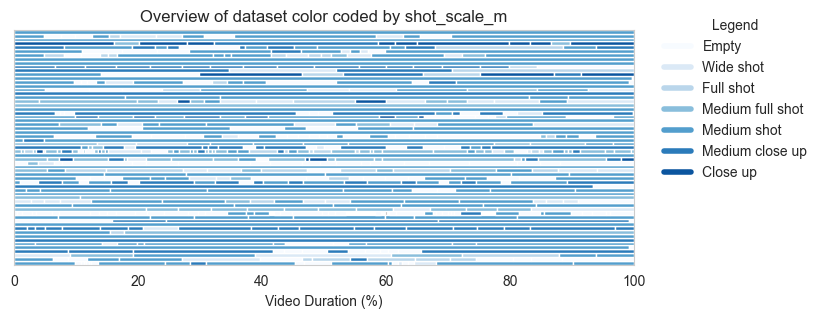

In [53]:
# Male only videos - Primary Coder
viz_timeline_stripe_shot_scale('shot_scale_m',df_scene_m, mode="rel")
plt.savefig(os.path.join(viz_output, "results_m_pri_coder.svg"))
plt.show()

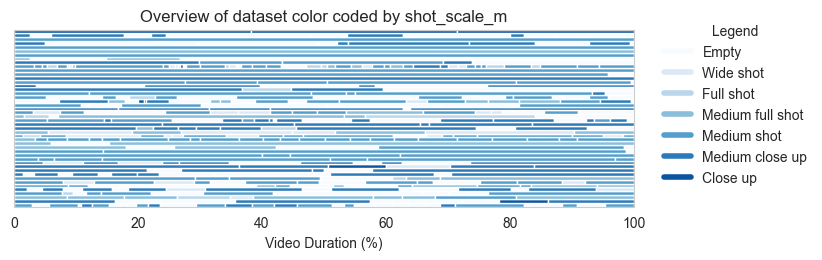

In [54]:
# Male only videos - Primary Coder
viz_timeline_stripe_shot_scale('shot_scale_m',df_scene_f)
plt.savefig(os.path.join(viz_output, "results_f_pri_coder.svg"))
plt.show()

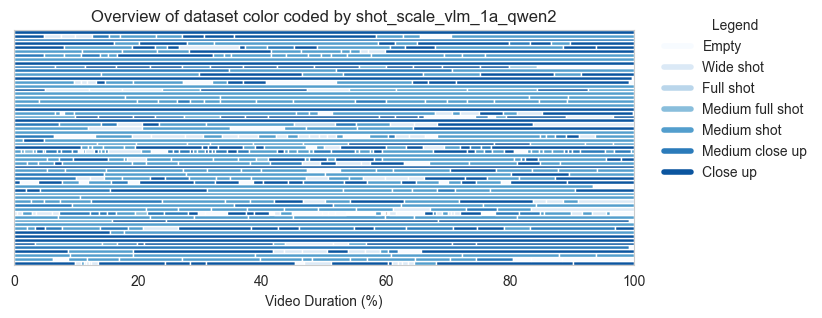

In [55]:
# Male only videos - Qwen2 + Prompt 1A as the model-prompt permutation with the closest agreement

viz_timeline_stripe_shot_scale('shot_scale_vlm_1a_qwen2',df_scene_m, mode="rel")
plt.savefig(os.path.join(viz_output, "results_m_vlm.svg"))
plt.show()

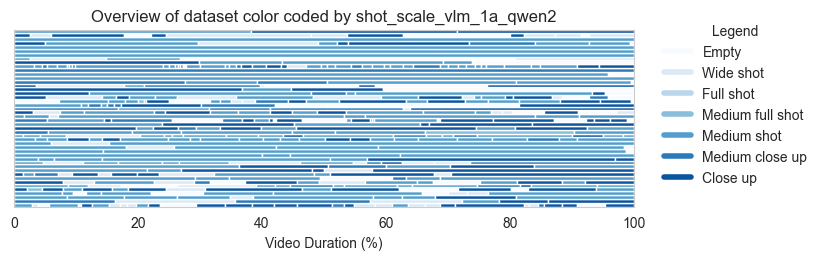

In [56]:
plt.show()
# Male only videos - Qwen2 + Prompt 1A as the model-prompt permutation with the closest agreement

viz_timeline_stripe_shot_scale('shot_scale_vlm_1a_qwen2', df_scene_f, mode="rel")
plt.savefig(os.path.join(viz_output, "results_f_vlm.svg"))
plt.show()

## Speed analysis

Here we will analyze the time taken for each to process 1442 thumbnails.
Time was logged automatically for each VLM run.

Benchmark numbers:
- Primary coding -- ~5hrs 46 mins  (Over 6hr 30 mins)
- Secondary coding -- ~7hrs (over 3 days)
- Distant viewing through pose estimation -- Average of 1hr 56 mins

In [58]:
# Load vlm log
vlm_log

column                   model  \
0          shot_scale_vlm_1b_01  qwen2.5-vl-7b-instruct   
1          shot_scale_vlm_1b_02  qwen2.5-vl-7b-instruct   
2          shot_scale_vlm_1b_03  qwen2.5-vl-7b-instruct   
3          shot_scale_vlm_1b_06    qwen2-vl-7b-instruct   
4          shot_scale_vlm_1b_07    qwen2-vl-7b-instruct   
5          shot_scale_vlm_1b_08    qwen2-vl-7b-instruct   
6          shot_scale_vlm_1a_01  qwen2.5-vl-7b-instruct   
7          shot_scale_vlm_1a_02  qwen2.5-vl-7b-instruct   
8    shot_scale_vlm_1a_04_tuple  qwen2.5-vl-7b-instruct   
9          shot_scale_vlm_1a_03  qwen2.5-vl-7b-instruct   
10         shot_scale_vlm_1a_06    qwen2-vl-7b-instruct   
11   shot_scale_vlm_1a_09_tuple    qwen2-vl-7b-instruct   
12         shot_scale_vlm_1a_07    qwen2-vl-7b-instruct   
13         shot_scale_vlm_1a_08    qwen2-vl-7b-instruct   
14  shot_scale_vlm_1a_10_filler    qwen2-vl-7b-instruct   
15  shot_scale_vlm_1a_05_filler  qwen2.5-vl-7b-instruct   
16   shot_scale_vlm_1b_04_tuple  qwen2.5-vl-7b-instruct   
17   shot_scale_vlm_1b_09_tuple    qwen2-vl-7b-instruct   
18  shot_scale_vlm_1b_05_filler  qwen2.5-vl-7b-instruct   
19  shot_scale_vlm_1b_10_filler    qwen2-vl-7b-instruct   
20         shot_scale_vlm_1c_01  qwen2.5-vl-7b-instruct   
21         shot_scale_vlm_1c_02  qwen2.5-vl-7b-instruct   
22         shot_scale_vlm_1c_03  qwen2.5-vl-7b-instruct   
23         shot_scale_vlm_1c_06    qwen2-vl-7b-instruct   
24         shot_scale_vlm_1c_07    qwen2-vl-7b-instruct   
25         shot_scale_vlm_1c_08    qwen2-vl-7b-instruct   
26   shot_scale_vlm_1c_04_tuple  qwen2.5-vl-7b-instruct   
27   shot_scale_vlm_1c_09_tuple    qwen2-vl-7b-instruct   
28  shot_scale_vlm_1c_10_filler    qwen2-vl-7b-instruct   
29  shot_scale_vlm_1c_05_filler  qwen2.5-vl-7b-instruct   
30       combat_presence_vlm_01  qwen2.5-vl-7b-instruct   
31       combat_presence_vlm_02  qwen2.5-vl-7b-instruct   
32       combat_presence_vlm_03  qwen2.5-vl-7b-instruct   
33              location_vlm_01  qwen2.5-vl-7b-instruct   
34              location_vlm_02  qwen2.5-vl-7b-instruct   
35              location_vlm_03  qwen2.5-vl-7b-instruct   

                                               prompt  \
0   You are an expert annotator with a focus on ci...   
1   You are an expert annotator with a focus on ci...   
2   You are an expert annotator with a focus on ci...   
3   You are an expert annotator with a focus on ci...   
4   You are an expert annotator with a focus on ci...   
5   You are an expert annotator with a focus on ci...   
6   You are an expert annotator with a focus on ci...   
7   You are an expert annotator with a focus on ci...   
8   You are an expert annotator with a focus on ci...   
9   You are an expert annotator with a focus on ci...   
10  You are an expert annotator with a focus on ci...   
11  You are an expert annotator with a focus on ci...   
12  You are an expert annotator with a focus on ci...   
13  You are an expert annotator with a focus on ci...   
14  You are an expert annotator with a focus on ci...   
15  You are an expert annotator with a focus on ci...   
16  You are an expert annotator with a focus on ci...   
17  You are an expert annotator with a focus on ci...   
18  You are an expert annotator with a focus on ci...   
19  You are an expert annotator with a focus on ci...   
20  You are an expert annotator with a focus on ci...   
21  You are an expert annotator with a focus on ci...   
22  You are an expert annotator with a focus on ci...   
23  You are an expert annotator with a focus on ci...   
24  You are an expert annotator with a focus on ci...   
25  You are an expert annotator with a focus on ci...   
26  You are an expert annotator with a focus on ci...   
27  You are an expert annotator with a focus on ci...   
28  You are an expert annotator with a focus on ci...   
29  You are an expert annotator with a focus on ci...   
30  You are an expert annotator of social media vi...   
31  You are an ex

In [59]:
# Convert elapsed_time back to timedelta
vlm_log['elapsed_time'] = pd.to_timedelta(vlm_log['elapsed_time'])

# Convert to hours
vlm_log['elapsed_time_hours'] = vlm_log['elapsed_time'].dt.total_seconds() / 3600
vlm_log

column                   model  \
0          shot_scale_vlm_1b_01  qwen2.5-vl-7b-instruct   
1          shot_scale_vlm_1b_02  qwen2.5-vl-7b-instruct   
2          shot_scale_vlm_1b_03  qwen2.5-vl-7b-instruct   
3          shot_scale_vlm_1b_06    qwen2-vl-7b-instruct   
4          shot_scale_vlm_1b_07    qwen2-vl-7b-instruct   
5          shot_scale_vlm_1b_08    qwen2-vl-7b-instruct   
6          shot_scale_vlm_1a_01  qwen2.5-vl-7b-instruct   
7          shot_scale_vlm_1a_02  qwen2.5-vl-7b-instruct   
8    shot_scale_vlm_1a_04_tuple  qwen2.5-vl-7b-instruct   
9          shot_scale_vlm_1a_03  qwen2.5-vl-7b-instruct   
10         shot_scale_vlm_1a_06    qwen2-vl-7b-instruct   
11   shot_scale_vlm_1a_09_tuple    qwen2-vl-7b-instruct   
12         shot_scale_vlm_1a_07    qwen2-vl-7b-instruct   
13         shot_scale_vlm_1a_08    qwen2-vl-7b-instruct   
14  shot_scale_vlm_1a_10_filler    qwen2-vl-7b-instruct   
15  shot_scale_vlm_1a_05_filler  qwen2.5-vl-7b-instruct   
16   shot_scale_vlm_1b_04_tuple  qwen2.5-vl-7b-instruct   
17   shot_scale_vlm_1b_09_tuple    qwen2-vl-7b-instruct   
18  shot_scale_vlm_1b_05_filler  qwen2.5-vl-7b-instruct   
19  shot_scale_vlm_1b_10_filler    qwen2-vl-7b-instruct   
20         shot_scale_vlm_1c_01  qwen2.5-vl-7b-instruct   
21         shot_scale_vlm_1c_02  qwen2.5-vl-7b-instruct   
22         shot_scale_vlm_1c_03  qwen2.5-vl-7b-instruct   
23         shot_scale_vlm_1c_06    qwen2-vl-7b-instruct   
24         shot_scale_vlm_1c_07    qwen2-vl-7b-instruct   
25         shot_scale_vlm_1c_08    qwen2-vl-7b-instruct   
26   shot_scale_vlm_1c_04_tuple  qwen2.5-vl-7b-instruct   
27   shot_scale_vlm_1c_09_tuple    qwen2-vl-7b-instruct   
28  shot_scale_vlm_1c_10_filler    qwen2-vl-7b-instruct   
29  shot_scale_vlm_1c_05_filler  qwen2.5-vl-7b-instruct   
30       combat_presence_vlm_01  qwen2.5-vl-7b-instruct   
31       combat_presence_vlm_02  qwen2.5-vl-7b-instruct   
32       combat_presence_vlm_03  qwen2.5-vl-7b-instruct   
33              location_vlm_01  qwen2.5-vl-7b-instruct   
34              location_vlm_02  qwen2.5-vl-7b-instruct   
35              location_vlm_03  qwen2.5-vl-7b-instruct   

                                               prompt  \
0   You are an expert annotator with a focus on ci...   
1   You are an expert annotator with a focus on ci...   
2   You are an expert annotator with a focus on ci...   
3   You are an expert annotator with a focus on ci...   
4   You are an expert annotator with a focus on ci...   
5   You are an expert annotator with a focus on ci...   
6   You are an expert annotator with a focus on ci...   
7   You are an expert annotator with a focus on ci...   
8   You are an expert annotator with a focus on ci...   
9   You are an expert annotator with a focus on ci...   
10  You are an expert annotator with a focus on ci...   
11  You are an expert annotator with a focus on ci...   
12  You are an expert annotator with a focus on ci...   
13  You are an expert annotator with a focus on ci...   
14  You are an expert annotator with a focus on ci...   
15  You are an expert annotator with a focus on ci...   
16  You are an expert annotator with a focus on ci...   
17  You are an expert annotator with a focus on ci...   
18  You are an expert annotator with a focus on ci...   
19  You are an expert annotator with a focus on ci...   
20  You are an expert annotator with a focus on ci...   
21  You are an expert annotator with a focus on ci...   
22  You are an expert annotator with a focus on ci...   
23  You are an expert annotator with a focus on ci...   
24  You are an expert annotator with a focus on ci...   
25  You are an expert annotator with a focus on ci...   
26  You are an expert annotator with a focus on ci...   
27  You are an expert annotator with a focus on ci...   
28  You are an expert annotator with a focus on ci...   
29  You are an expert annotator with a focus on ci...   
30  You are an expert annotator of social media vi...   
31  You are an ex

In [60]:
# Load intraprompt stability data to continue adding to aggregate prompt-model data
df_intraprompt = pd.read_csv(os.path.join(data_output,'idf_data_shot_scale_vlm_intraprompt_stability.csv'))

df_intraprompt['col_list'] = df_intraprompt['col_list'].apply(ast.literal_eval)
df_intraprompt

model_name prompt  \
0  qwen2.5-vl-7b-instruct     1a   
1    qwen2-vl-7b-instruct     1a   
2  qwen2.5-vl-7b-instruct     1b   
3    qwen2-vl-7b-instruct     1b   
4  qwen2.5-vl-7b-instruct     1c   
5    qwen2-vl-7b-instruct     1c   

                                            col_list  alpha_ord  \
0  [shot_scale_vlm_1a_01, shot_scale_vlm_1a_02, s...   0.956861   
1  [shot_scale_vlm_1a_06, shot_scale_vlm_1a_07, s...   0.891731   
2  [shot_scale_vlm_1b_01, shot_scale_vlm_1b_02, s...   0.970109   
3  [shot_scale_vlm_1b_06, shot_scale_vlm_1b_07, s...   0.930024   
4  [shot_scale_vlm_1c_01, shot_scale_vlm_1c_02, s...   0.953187   
5  [shot_scale_vlm_1c_06, shot_scale_vlm_1c_07, s...   0.872007   

   rows_with_nan  alpha_nom  
0            114   0.883105  
1             64   0.763551  
2             12   0.940873  
3              7   0.836172  
4            161   0.889119  
5             56   0.743496

In [62]:
# Loop through data and calculate average accordingly

for i, row in df_intraprompt.iterrows():
    model_name = row['model_name']
    col_list = row['col_list']
    assert len(col_list) == 3, f"Unexpected column size ({len(col_list)}). Expected 3 columns only."

    total_hr = 0
    for column_name in col_list:
        # Locate the corresponding column entry in vlm_log
        df_col = vlm_log[vlm_log['column'] == column_name]
        elapsed_hrs = df_col['elapsed_time_hours'].iloc[0]
        total_hr += elapsed_hrs
    avg_hr = total_hr / len(col_list)
    df_intraprompt.at[i, 'avg_time_hr'] = avg_hr

df_intraprompt

model_name prompt  \
0  qwen2.5-vl-7b-instruct     1a   
1    qwen2-vl-7b-instruct     1a   
2  qwen2.5-vl-7b-instruct     1b   
3    qwen2-vl-7b-instruct     1b   
4  qwen2.5-vl-7b-instruct     1c   
5    qwen2-vl-7b-instruct     1c   

                                            col_list  alpha_ord  \
0  [shot_scale_vlm_1a_01, shot_scale_vlm_1a_02, s...   0.956861   
1  [shot_scale_vlm_1a_06, shot_scale_vlm_1a_07, s...   0.891731   
2  [shot_scale_vlm_1b_01, shot_scale_vlm_1b_02, s...   0.970109   
3  [shot_scale_vlm_1b_06, shot_scale_vlm_1b_07, s...   0.930024   
4  [shot_scale_vlm_1c_01, shot_scale_vlm_1c_02, s...   0.953187   
5  [shot_scale_vlm_1c_06, shot_scale_vlm_1c_07, s...   0.872007   

   rows_with_nan  alpha_nom  avg_time_hr  
0            114   0.883105     3.266338  
1             64   0.763551     4.653092  
2             12   0.940873     3.342222  
3              7   0.836172     4.685359  
4            161   0.889119     3.513416  
5             56   0.743496     4.960075

In [63]:
# Export results
df_intraprompt.to_csv(os.path.join(data_output, 'idf_data_shot_scale_vlm_model-prompt.csv'))

In [70]:
# Create new time dataframe for visualization as a bar chart
df_time = df_intraprompt.copy()
df_time = df_time[['model_name','prompt','avg_time_hr']]
df_time['model_name'] = df_time['model_name'].replace('qwen2.5-vl-7b-instruct','Qwen2.5-VL')
df_time['model_name'] = df_time['model_name'].replace('qwen2-vl-7b-instruct','Qwen2-VL')

for i, row in df_time.iterrows():
    prompt = row['prompt'].upper()
    annotator = f"{row['model_name']} ({prompt})"
    df_time.at[i,'annotator'] = annotator

df_time = df_time.rename(columns={"model_name" : "annotator_type"})

# Manually input benchmark data
df_benchmark_time = pd.DataFrame([{'annotator' :'Primary human coder',
                                   'annotator_type' :'Human',
                                   'avg_time_hr' : float(5 + (46/60))},

                                  {'annotator' :'Secondary human coder',
                                   'annotator_type' :'Human',
                                   'avg_time_hr' : float(7)},

                                  {'annotator' :'Pose estimation',
                                   'annotator_type' :'Computer vision',
                                   'avg_time_hr' : float(1 + (56/60))},
                                  ])
df_time = pd.concat([df_time, df_benchmark_time],ignore_index=True)
df_time

annotator_type prompt  avg_time_hr              annotator
0       Qwen2.5-VL     1a     3.266338        Qwen2.5-VL (1A)
1         Qwen2-VL     1a     4.653092          Qwen2-VL (1A)
2       Qwen2.5-VL     1b     3.342222        Qwen2.5-VL (1B)
3         Qwen2-VL     1b     4.685359          Qwen2-VL (1B)
4       Qwen2.5-VL     1c     3.513416        Qwen2.5-VL (1C)
5         Qwen2-VL     1c     4.960075          Qwen2-VL (1C)
6            Human    NaN     5.766667    Primary human coder
7            Human    NaN     7.000000  Secondary human coder
8  Computer vision    NaN     1.933333        Pose estimation

In [72]:
# Manually reorder df_time
new_order = [6,7,8, # Benchmark methods first
             0,2,4, # Qwen2.5
             1,3,5 # Qwen2
             ]
df_time = df_time.reindex(new_order)
df_time

annotator_type prompt  avg_time_hr              annotator
6            Human    NaN     5.766667    Primary human coder
7            Human    NaN     7.000000  Secondary human coder
8  Computer vision    NaN     1.933333        Pose estimation
0       Qwen2.5-VL     1a     3.266338        Qwen2.5-VL (1A)
2       Qwen2.5-VL     1b     3.342222        Qwen2.5-VL (1B)
4       Qwen2.5-VL     1c     3.513416        Qwen2.5-VL (1C)
1         Qwen2-VL     1a     4.653092          Qwen2-VL (1A)
3         Qwen2-VL     1b     4.685359          Qwen2-VL (1B)
5         Qwen2-VL     1c     4.960075          Qwen2-VL (1C)

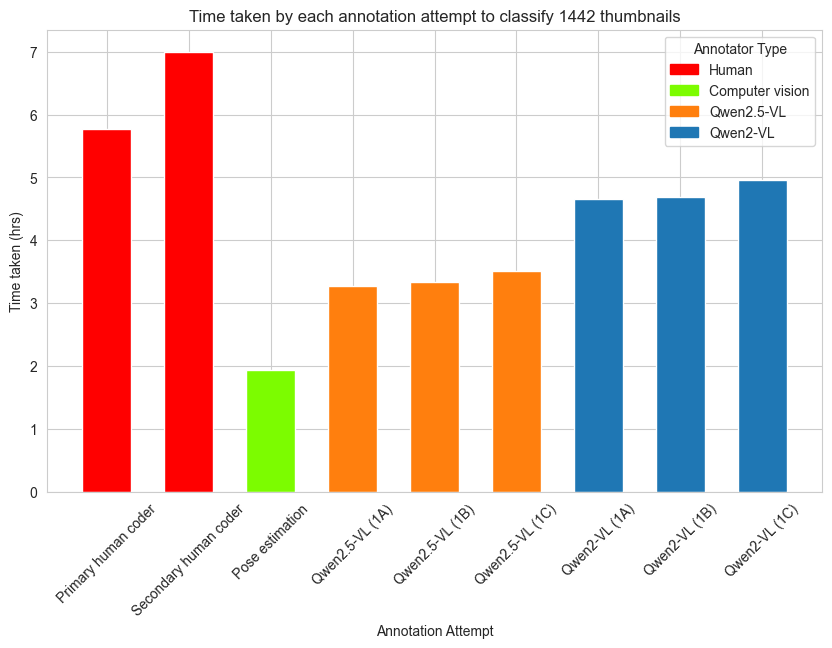

In [88]:
import matplotlib.patches as mpatches

# Visualize along with benchmarks
# Repeat for MSD
df_time_viz = df_time.copy()
# Define colors for each model
annotator_type_color = {
    'Human' : 'red',
    'Computer vision' : 'lawngreen',
    'Qwen2.5-VL': 'tab:orange',
    'Qwen2-VL': 'tab:blue'
}

df_time_viz['color'] = df_time_viz['annotator_type'].map(annotator_type_color)
color_list = df_time_viz['color'].to_list()

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(df_time_viz['annotator'],
        df_time_viz['avg_time_hr'],
        color=color_list,
        width=0.6)

# Create handles for each annotator
handles = [mpatches.Patch(color=color, label=label)
          for label, color in annotator_type_color.items()]

plt.xlabel('Annotation Attempt')
plt.ylabel('Time taken (hrs)')
plt.title('Time taken by each annotation attempt to classify 1442 thumbnails')
plt.legend(handles=handles, title='Annotator Type')
plt.grid(True)
plt.xticks(rotation=45) # Rotate labels for better readability
plt.savefig(os.path.join(viz_output, 'time_taken.svg'),dpi=300)
plt.show()

# Experimental Task 2: Setting annotation (Agreement analysis)



For the code development process that led to the generation of the labels used in this experiment, please review notebooks 3-5
1. `Notebook_3_Experiment_2_VLM_setting_text_analysis.ipynb`
2. `Notebook_4_Experiment_2_TestCoding1.ipynb`
3.

In [101]:
# Load past intercoder data
df_intercoder_exp_2 = pd.read_csv(os.path.join(root_folder,'input_data','test_coding_agr.csv'))
df_intercoder_exp_2

column_1                column_2             type  \
0          location_m              location_c         location   
1          location_m         location_vlm_4a         location   
2          location_c         location_vlm_4a         location   
3   combat_presence_m       combat_presence_c  combat_presence   
4   combat_presence_m  combat_presence_vlm_5a  combat_presence   
5   combat_presence_c  combat_presence_vlm_5a  combat_presence   
6          location_m         location_vlm_4b         location   
7          location_c         location_vlm_4b         location   
8   combat_presence_m  combat_presence_vlm_5b  combat_presence   
9   combat_presence_c  combat_presence_vlm_5b  combat_presence   
10         location_m              location_c         location   
11  combat_presence_m       combat_presence_c  combat_presence   
12         location_m              location_c         location   
13         location_m         location_vlm_3b         location   
14         location_c         location_vlm_3b         location   
15  combat_presence_m       combat_presence_c  combat_presence   
16  combat_presence_m  combat_presence_vlm_3b  combat_presence   
17  combat_presence_c  combat_presence_vlm_3b  combat_presence   

    intercoder_alpha permutation iteration  
0           0.977847     Pri-Sec        2a  
1           0.594787     Pri-VLM        2a  
2           0.615527     Sec-VLM        2a  
3           1.000000     Pri-Sec        2a  
4           0.476709     Pri-VLM        2a  
5           0.476709     Sec-VLM        2a  
6           0.679604     Pri-VLM        2b  
7           0.701170     Sec-VLM        2b  
8           0.596562     Pri-VLM        2b  
9           0.596562     Sec-VLM        2b  
10          0.977847     Pri-Sec        2b  
11          1.000000     Pri-Sec        2b  
12          0.804505     Pri-Sec         1  
13          0.895186     Pri-VLM         1  
14          0.827614     Sec-VLM         1  
15          0.777542     Pri-Sec         1  
16          0.443086     Pri-VLM         1  
17          0.650875     Sec-VLM         1

In [103]:
# Generic K-Alpha Calculator (Nominal)
def calc_k_alpha_nom(df, col_list):
    """
    Calculates Krippendorff's Alpha (for nominal variables) for any two corresponding.

    This function takes a df and a list of column names containing
    shot scale annotations as input and calculates K Alpha.

    Args:
        df (pd.DataFrame): The input DataFrame containing shot scale annotations.
        col_list (list): A list of column names in the DataFrame that contain
                         the shot scale annotations to be compared.

    Returns:
        alpha (float): The calculated Krippendorff's Alpha value.

    """
    df_copy = df[col_list].copy() # Make copy of dataframe for refactoring

    # Define nominal labels for refactoring
    # Ordered from closest to further from the camera
    refactor_dict = {}
    unique_labels = list(df_copy[col_list].stack().unique())
    for i, label in enumerate(unique_labels):
        refactor_dict[label] = i+1

    print(f"Refactor dictionary created: \n{refactor_dict}\n") # Debug print

    # Refactor
    for col in col_list:
        df_copy[col] = df_copy[col].map(refactor_dict)

    # Transpose for krippendorff
    data_array = df_copy[col_list].to_numpy().T

    # Compute alpha
    alpha = krippendorff.alpha(reliability_data=data_array, level_of_measurement='nominal')
    print(f"Krippendorff’s alpha (nominal) for {col_list}: {alpha:.3f}\n")
    return alpha

In [108]:
# Aggregate results of three VLM runs
df_results_location, uncertain_count = majority_annotation(df_final, ['location_vlm_01','location_vlm_02','location_vlm_02'], 'location_vlm')
df_final = pd.merge(df_final,df_results_location, how='left',on='id')
df_results_combat, uncertain_count = majority_annotation(df_final, ['combat_presence_vlm_01','combat_presence_vlm_02','combat_presence_vlm_02'], 'combat_presence_vlm')
df_final = pd.merge(df_final,df_results_combat, how='left',on='id')
df_final

Calculating majority for ['location_vlm_01', 'location_vlm_02', 'location_vlm_02']
Total of rows with no majority in ['location_vlm_01', 'location_vlm_02', 'location_vlm_02']: 0

Calculating majority for ['combat_presence_vlm_01', 'combat_presence_vlm_02', 'combat_presence_vlm_02']
Total of rows with no majority in ['combat_presence_vlm_01', 'combat_presence_vlm_02', 'combat_presence_vlm_02']: 0



Unnamed: 0                                id                  url  \
0              0   7357772207445134608.mp4_scene_1  7357772207445134608   
1              1   7357772207445134608.mp4_scene_2  7357772207445134608   
2              2   7357772207445134608.mp4_scene_3  7357772207445134608   
3              3   7357772207445134608.mp4_scene_4  7357772207445134608   
4              4   7357772207445134608.mp4_scene_5  7357772207445134608   
...          ...                               ...                  ...   
1432        1437  7287823285566426369.mp4_scene_12  7287823285566426369   
1433        1438  7287823285566426369.mp4_scene_13  7287823285566426369   
1434        1439  7287823285566426369.mp4_scene_14  7287823285566426369   
1435        1440  7287823285566426369.mp4_scene_15  7287823285566426369   
1436        1441   7287537715829148930.mp4_scene_1  7287537715829148930   

      start_frame             start_time  end_frame               end_time  \
0               0        0 days 00:00:00         61 0 days 00:00:02.033000   
1              61 0 days 00:00:02.033000         83 0 days 00:00:02.767000   
2              83 0 days 00:00:02.767000        121 0 days 00:00:04.033000   
3             121 0 days 00:00:04.033000        221 0 days 00:00:07.367000   
4             221 0 days 00:00:07.367000        229 0 days 00:00:07.633000   
...           ...                    ...        ...                    ...   
1432          708 0 days 00:00:23.624000        760 0 days 00:00:25.359000   
1433          760 0 days 00:00:25.359000        793 0 days 00:00:26.460000   
1434          793 0 days 00:00:26.460000        854 0 days 00:00:28.495000   
1435          854 0 days 00:00:28.495000       1212 0 days 00:00:40.440000   
1436            0        0 days 00:00:00        611 0 days 00:00:24.440000   

      end_fps  scene_num  num_scenes_detected  ...  shot_scale_vlm_1c_09  \
0       30.00          1                   34  ...       Medium close up   
1       30.00          2                   34  ...             Uncertain   
2       30.00          3                   34  ...                 Empty   
3       30.00          4                   34  ...       Medium close up   
4       30.00          5                   34  ...                 Empty   
...       ...        ...                  ...  ...                   ...   
1432    29.97         12                   15  ...       Medium close up   
1433    29.97         13                   15  ...       Medium close up   
1434    29.97         14                   15  ...             Uncertain   
1435    29.97         15                   15  ...       Medium close up   
1436    25.00          1                    1  ...              Close up   

                        shot_scale_vlm_1c_09_motivation  \
0     The subject is framed from the head up and tak...   
1     The image appears to be a wide shot with a red...   
2     The image is completely black with no discerni...   
3     The subject is framed from the head up and tak...   
4     The image is completely black with no discerni...   
...                                                 ...   
1432  The subject is framed from the head up and tak...   
1433  The subject is framed from the head up and tak...   
1434  The image appears to be an extreme close-up or...   
1435  The subject is framed from the head up and tak...   
1436  The subject occupies most of the frame from he...   

     shot_scale_vlm_1a_qwen2.5  shot_scale_vlm_1a_qwen2  \
0              Medium close up              Medium shot   
1                        Empty                Wide shot   
2                        Empty                    Empty   
3                     Close up              Medium shot   
4                        Empty                    Empty   
...                        ...                      ...   
1432               Medium shot              Medium shot   
1433               Medium shot              Medium shot   
1434           

In [109]:
# Update df_final
df_final.to_csv(os.path.join(data_output, '05_idf_data_vlm_evaluation_final.csv'),index=False)

In [110]:
# Calculate agreements for location and combat_presence

# Define list of comparison permutations
comparison_list = [['location_m', 'location_c'],
                   ['location_m', 'location_vlm'],
                   ['location_c', 'location_vlm'],

                   ['combat_presence_m', 'combat_presence_c'],
                   ['combat_presence_m', 'combat_presence_vlm'],
                   ['combat_presence_c', 'combat_presence_vlm']
                   ]

for comparison in comparison_list:
    column_1 = comparison[0]
    column_2 = comparison[1]
    alpha = calc_k_alpha_nom(df_final, comparison)

    # Determine type
    if "location" in column_1:
        type = "location"
    elif "combat_presence" in column_1:
        type = "combat_presence"
    else:
        type = None

    # Determine permutation
    if column_1[-1:] == 'm' and column_2[-1:] == 'c':
        # Means both human coders
        permutation = 'Pri-Sec'
    elif column_1[-1:] == 'm' and 'vlm' in column_2:
        permutation = 'Pri-VLM'
    elif column_1[-1:] == 'c' and 'vlm' in column_2:
        permutation = 'Sec-VLM'
    else:
        permutation = None

    df_results = pd.DataFrame([{'column_1': column_1,
                                'column_2': column_2,
                                'type': type,
                                'intercoder_alpha': alpha,
                                'permutation': permutation,
                                'iteration': 'Final'},])

    # Add
    df_intercoder_exp_2 = pd.concat([df_intercoder_exp_2,df_results],ignore_index=True)
df_intercoder_exp_2


Refactor dictionary created: 
{'Indoor': 1, 'Outdoor': 2, 'Graphics': 3}

Krippendorff’s alpha (nominal) for ['location_m', 'location_c']: 0.903

Refactor dictionary created: 
{'Indoor': 1, 'Outdoor': 2, 'Graphics': 3}

Krippendorff’s alpha (nominal) for ['location_m', 'location_vlm']: 0.709

Refactor dictionary created: 
{'Indoor': 1, 'Outdoor': 2, 'Graphics': 3}

Krippendorff’s alpha (nominal) for ['location_c', 'location_vlm']: 0.669

Refactor dictionary created: 
{'Non-combat': 1, 'Combat': 2, 'Graphics': 3}

Krippendorff’s alpha (nominal) for ['combat_presence_m', 'combat_presence_c']: 0.708

Refactor dictionary created: 
{'Non-combat': 1, 'Combat': 2, 'Graphics': 3}

Krippendorff’s alpha (nominal) for ['combat_presence_m', 'combat_presence_vlm']: 0.280

Refactor dictionary created: 
{'Non-combat': 1, 'Graphics': 2, 'Combat': 3}

Krippendorff’s alpha (nominal) for ['combat_presence_c', 'combat_presence_vlm']: 0.178



column_1                column_2             type  \
0          location_m              location_c         location   
1          location_m         location_vlm_4a         location   
2          location_c         location_vlm_4a         location   
3   combat_presence_m       combat_presence_c  combat_presence   
4   combat_presence_m  combat_presence_vlm_5a  combat_presence   
5   combat_presence_c  combat_presence_vlm_5a  combat_presence   
6          location_m         location_vlm_4b         location   
7          location_c         location_vlm_4b         location   
8   combat_presence_m  combat_presence_vlm_5b  combat_presence   
9   combat_presence_c  combat_presence_vlm_5b  combat_presence   
10         location_m              location_c         location   
11  combat_presence_m       combat_presence_c  combat_presence   
12         location_m              location_c         location   
13         location_m         location_vlm_3b         location   
14         location_c         location_vlm_3b         location   
15  combat_presence_m       combat_presence_c  combat_presence   
16  combat_presence_m  combat_presence_vlm_3b  combat_presence   
17  combat_presence_c  combat_presence_vlm_3b  combat_presence   
18         location_m              location_c         location   
19         location_m            location_vlm         location   
20         location_c            location_vlm         location   
21  combat_presence_m       combat_presence_c  combat_presence   
22  combat_presence_m     combat_presence_vlm  combat_presence   
23  combat_presence_c     combat_presence_vlm  combat_presence   

    intercoder_alpha permutation iteration  
0           0.977847     Pri-Sec        2a  
1           0.594787     Pri-VLM        2a  
2           0.615527     Sec-VLM        2a  
3           1.000000     Pri-Sec        2a  
4           0.476709     Pri-VLM        2a  
5           0.476709     Sec-VLM        2a  
6           0.679604     Pri-VLM        2b  
7           0.701170     Sec-VLM        2b  
8           0.596562     Pri-VLM        2b  
9           0.596562     Sec-VLM        2b  
10          0.977847     Pri-Sec        2b  
11          1.000000     Pri-Sec        2b  
12          0.804505     Pri-Sec         1  
13          0.895186     Pri-VLM         1  
14          0.827614     Sec-VLM         1  
15          0.777542     Pri-Sec         1  
16          0.443086     Pri-VLM         1  
17          0.650875     Sec-VLM         1  
18          0.903499     Pri-Sec     Final  
19          0.709388     Pri-VLM     Final  
20          0.669042     Sec-VLM     Final  
21          0.708110     Pri-Sec     Final  
22          0.280301     Pri-VLM     Final  
23          0.177570     Sec-VLM     Final

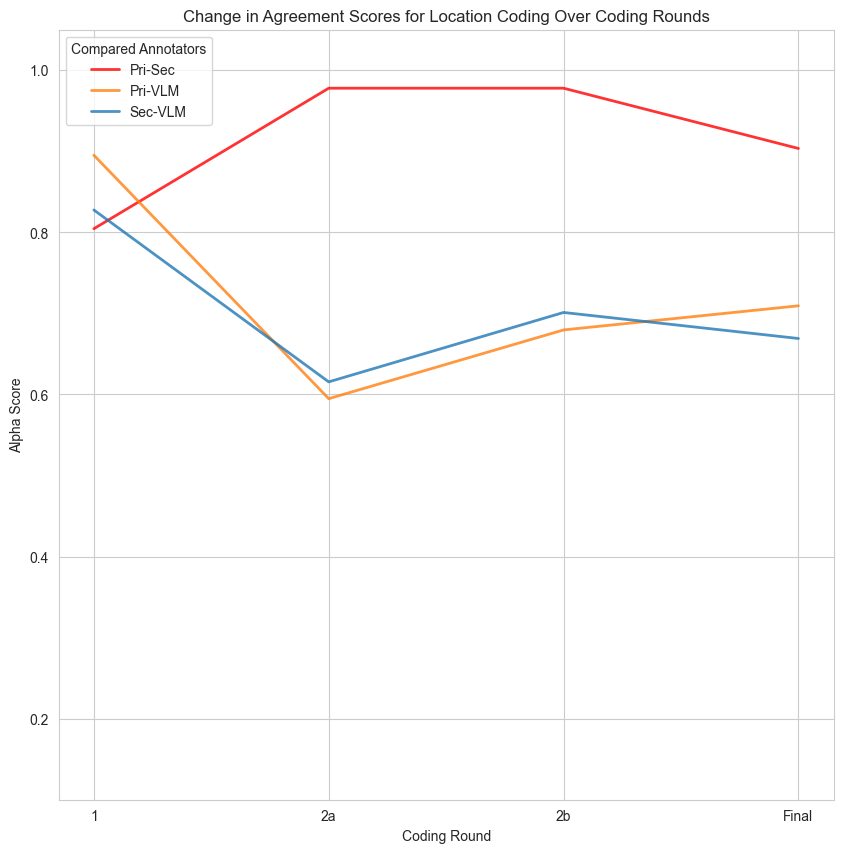

In [116]:
# Visualize

# Plot change for location
plt.figure(figsize=(10, 10))
df_intercoder_change = df_intercoder_exp_2[df_intercoder_exp_2['type'] == 'location']

# Color dictionary for permutation
perm_color = {'Pri-Sec': 'red',
              'Pri-VLM': 'tab:orange',
              'Sec-VLM': 'tab:blue',}

for i, permutation in enumerate(perm_color.keys()):
    df_perm = df_intercoder_change[df_intercoder_change['permutation'] == permutation]
    # Sort by iteration
    df_perm = df_perm.sort_values(by='iteration')
    # Plot change in agreement
    plt.plot(df_perm['iteration'],
             df_perm['intercoder_alpha'],
             # marker='o',
             linewidth=2,
             linestyle='-',
             color=perm_color[permutation],
             label=f'{permutation}',
             alpha=0.8)

plt.xlabel('Coding Round')
plt.ylabel('Alpha Score')
plt.ylim(0.1,1.05)
plt.title('Change in Agreement Scores for Location Coding Over Coding Rounds')
plt.legend(title='Compared Annotators')
plt.grid(True)
plt.savefig(os.path.join(viz_output,'location_agreement_change.svg'),dpi=300)
plt.show()

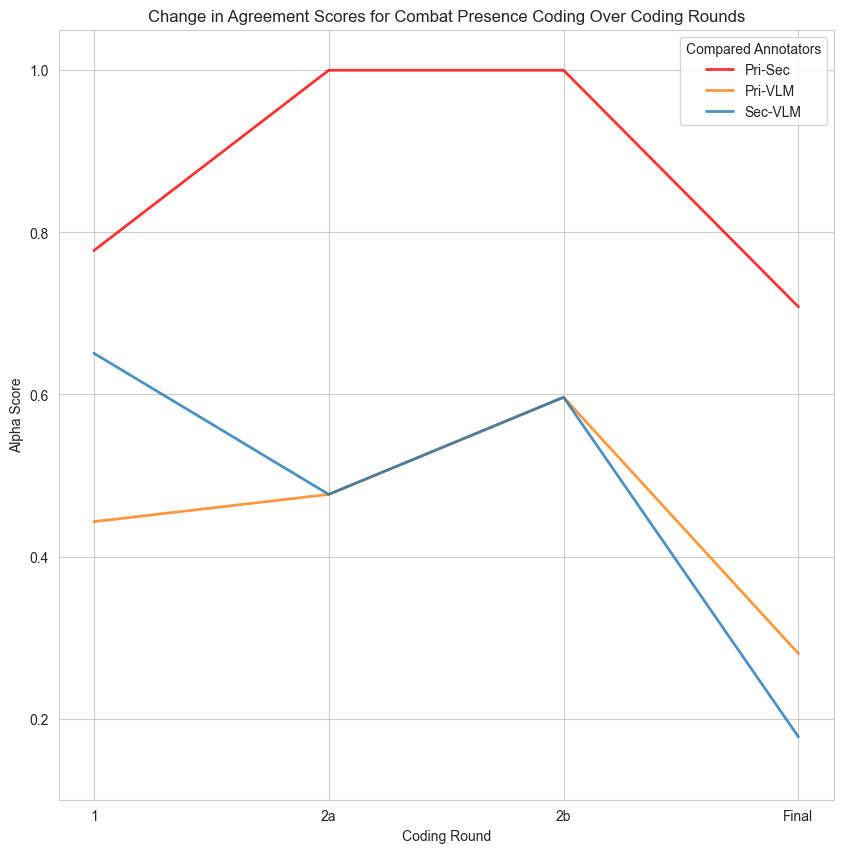

In [117]:
# Visualize

# Plot change for location
plt.figure(figsize=(10, 10))
df_intercoder_change = df_intercoder_exp_2[df_intercoder_exp_2['type'] == 'combat_presence']

# Color dictionary for permutation
perm_color = {'Pri-Sec': 'red',
              'Pri-VLM': 'tab:orange',
              'Sec-VLM': 'tab:blue',}

for i, permutation in enumerate(perm_color.keys()):
    df_perm = df_intercoder_change[df_intercoder_change['permutation'] == permutation]
    # Sort by iteration
    df_perm = df_perm.sort_values(by='iteration')
    # Plot change in agreement
    plt.plot(df_perm['iteration'],
             df_perm['intercoder_alpha'],
             # marker='o',
             linewidth=2,
             linestyle='-',
             color=perm_color[permutation],
             label=f'{permutation}',
             alpha=0.8)

plt.xlabel('Coding Round')
plt.ylabel('Alpha Score')
plt.ylim(0.1,1.05)
plt.title('Change in Agreement Scores for Combat Presence Coding Over Coding Rounds')
plt.legend(title='Compared Annotators')
plt.grid(True)
plt.savefig(os.path.join(viz_output,'combat_presence_agreement_change.svg'),dpi=300)
plt.show()

In [120]:
# Visualize location since that is accurate

# Define function to visualize col

def viz_timeline_stripe_location(target_column, df_scene, mode="rel", stripe_height=0.05):
    """
    Generate a timeline visualizations for a dataset of videos in thin stripes for the purposes of macro-viewing.

    :param target_column: name of column to be used to color code shots; Can be left blank for random colors
    :type target_column: str
    :param df_scene: Dataframe containing scene metadata
    :param mode: Either "abs" or "rel" to set the timeline visualization either as absolute (displays original duration) or relative (every video will have their timeline normalized)
    :param stripe_height: Modifies the height of the stripes


    """

    # Validate the mode parameter
    if mode not in ["abs", "rel"]:
        print(f"Invalid mode '{mode}' provided. Defaulting to 'abs' (Absolute time visualization).")
        mode = "abs"

    if target_column:
        if not target_column in df_scene.columns:
                raise ValueError("The current version of the dataframe lacks the target column for color coding. Please try again. ")

        # Unique annotations in column
        # annotation_list = df_scene[target_column].unique()

        # Assign colour based on shot scale
        # Initialize color mapping
        label_to_color = {'Graphics':'darkgrey',
                          'Indoor':'dodgerblue',
                          'Outdoor':'lightsalmon'}

    # Extract unique video IDs from scene_data
    unique_ids = df_scene['url'].unique()

    fig_height = (len(unique_ids) * stripe_height)
    fig, ax = plt.subplots(figsize=(8, fig_height))

    # Loop through every video
    for i, video_id in enumerate(unique_ids):
        y_offset = i * stripe_height
        # Filter scenes from the current video ID
        df_sub_scenes = df_scene[df_scene['url'] == video_id].reset_index(drop=True)
        total_duration = df_sub_scenes.iloc[0]['total_video_duration']

        if not target_column: # Assign random colors to shots for readability if no target_column is defined
            # Create a colourmap with appropriate number of colours based on number of shots
            num_shots = len(df_sub_scenes)
            colourmap = plt.get_cmap('rainbow', num_shots)
        # Loop over all scenes from the current video ID
        for i, scene in df_sub_scenes.iterrows():

            start_time = scene['start_time'].total_seconds()
            end_time = scene['end_time'].total_seconds()
            duration = end_time - start_time

            # If mode set to relative, normalize the durations
            if mode == "rel":
                start_time = start_time / total_duration.total_seconds() * 100
                duration = duration / total_duration.total_seconds() * 100

            if target_column: # If there is a desired column for color coding
                annotation = scene[target_column]
                # Assign colors for annotations in target column and draw rect
                if annotation:
                    color = label_to_color.get(annotation, 'black')  # Default to black if no label match somehow

                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='white', facecolor=color, lw=1)
                    ax.add_patch(rect)
                else:
                    # If somehow there's an invalid entry, use light gray as a default color
                    rect = plt.Rectangle((start_time, y_offset), duration, stripe_height, edgecolor='white', facecolor='lightgray', lw=1)
                    ax.add_patch(rect)
            else: # If there is no target column for color coding
                color = colourmap(i)
                rect = patches.Rectangle((start_time, y_offset), duration, stripe_height, linewidth=1, edgecolor='white', facecolor=color)
                ax.add_patch(rect)

        # print(f'Processed video {video_id}, total duration: {total_duration.total_seconds()}s')

    # Set axis details
    if mode == "rel":
        ax.set_xlim(0, 100)
        ax.set_xlabel("Video Duration (%)")
        ax.set_title(f"Overview of dataset color coded by {target_column}")
    elif mode == "abs":
        ax.set_xlim(0,max(df_scene['total_video_duration'].dt.total_seconds()))
        ax.set_xlabel('Time (in seconds)')
        ax.set_title("Video Timelines by Shots")

    ax.set_ylim(0, len(unique_ids) * stripe_height)
    ax.yaxis.set_visible(False) # Turn off y ticks

    # Add legend for the colors if target column is defined
    if target_column:
        legend_handles = [
            plt.Line2D([0], [0], color=color, lw=4, label=label)
            for label, color in label_to_color.items()
        ]

        # Place the legend (Optional))
        ax.legend(
            handles=legend_handles,
            title='Legend',
            loc='upper right',
            bbox_to_anchor=(1.3, 1.1),
            ncol=1,  # Adjust columns based on labels for better spacing
            frameon=False
        )


Given that the location data is validated, we can apply it to our case study.

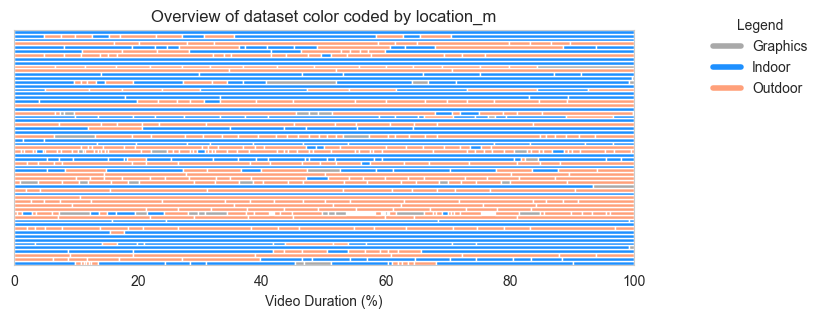

In [121]:
viz_timeline_stripe_location('location_m',df_scene_m)
plt.savefig(os.path.join(viz_output, "results_m_location_pri_coder.svg"))
plt.show()

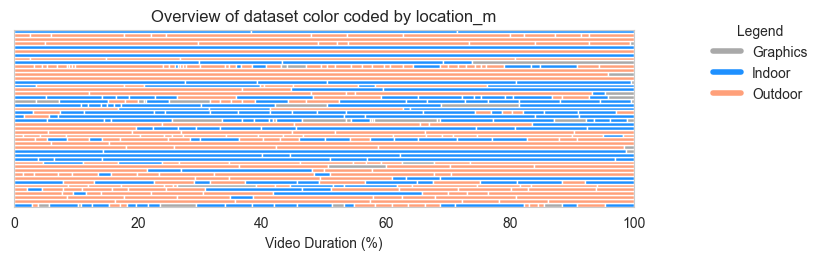

In [122]:
viz_timeline_stripe_location('location_m',df_scene_f)
plt.savefig(os.path.join(viz_output, "results_f_location_pri_coder.svg"))
plt.show()

## Aggregating Location Data
This can then be aggregated into video level data, where the annotated features are calculated as a percentage of the video

In [123]:
def shot2vid_feature(target_column, df_scene):
    '''
    Translates scene level-annotations for a feature column into video-level annotations as a proportion (0.0-1.0) of how much a feature category occupies the video

    :param target_column: The name of the desired column where its features will be translated into
    :type target_column: str
    :param df_scene: The main scene metadata
    :return: df_video_out: The translated dataframe ready to be merged with df_video
    '''
    # Check if target_column is in df_scene
    if not target_column in df_scene.columns:
            raise ValueError("The dataframe lacks the desired target column. Please check again.")

    # Main calculation theory: Calculate the % a particular style feature occupies the video
    # Annotated to df_video: (sum of shot durations with style feature) / total duration of video

    # Obtain list of unique features
    feature_list = df_scene[target_column].unique()
    # Obtain list of videos
    video_list = df_scene['url'].unique()

    # Create an output dataframe for video-level data
    df_video_out = pd.DataFrame({'id': video_list})

    # Create shot duration column
    df_scene_copy = df_scene.copy()
    df_scene_copy['duration'] = df_scene_copy['end_time'].dt.total_seconds() - df_scene_copy['start_time'].dt.total_seconds()
    # Loop through each feature and calculate its percentage of total video duration
    for feature in feature_list:
        feature_durations = []

        for video in video_list:
            # Filter the dataframe for the current video
            df_video_shots = df_scene_copy[df_scene['url'] == video]

            # Filter shots that contain the current feature
            df_feature_shots = df_video_shots[df_video_shots[target_column] == feature]

            # Calculate total duration of shots with the feature
            feature_duration = df_feature_shots['duration'].sum()  # Sum shot-level durations

            # Calculate total video duration
            total_video_duration = df_video_shots.iloc[0]['total_video_duration'].total_seconds()

            # Calculate the percentage of the feature's duration in the video
            feature_percentage = (
                feature_duration / total_video_duration
                if total_video_duration > 0 else 0
            )

            # Append to the list for the current video
            feature_durations.append(feature_percentage)

        # Add the calculated feature percentages as a new column in the video-level dataframe
        # format name
        formatted_feature = feature.strip().lower().replace(" ", "_")
        df_video_out[f'{formatted_feature}_percentage'] = feature_durations

    return df_video_out

In [131]:
df_video_out_f = shot2vid_feature('location_m',df_scene_f)
df_video_f = pd.merge(df_video_f,df_video_out_f,how='left',on='id')
df_video_f

id            thread_id author author_full  \
0   7357772207445134608  7357772207445134608    idf         IDF   
1   7288363457341164801  7288363457341164801    idf         IDF   
2   7422934013553216775  7422934013553216775    idf         IDF   
3   7421923208376405266  7421923208376405266    idf         IDF   
4   7414538490660048135  7414538490660048135    idf         IDF   
5   7405981980120075540  7405981980120075540    idf         IDF   
6   7397447925460241671  7397447925460241671    idf         IDF   
7   7390029779774229781  7390029779774229781    idf         IDF   
8   7388968754849369361  7388968754849369361    idf         IDF   
9   7386685007823162642  7386685007823162642    idf         IDF   
10  7378235135549902081  7378235135549902081    idf         IDF   
11  7377052376907189521  7377052376907189521    idf         IDF   
12  7367791048719961345  7367791048719961345    idf         IDF   
13  7367295492042001681  7367295492042001681    idf         IDF   
14  7367077964921572625  7367077964921572625    idf         IDF   
15  7360386332880948481  7360386332880948481    idf         IDF   
16  7358551328412486928  7358551328412486928    idf         IDF   
17  7343946884572105985  7343946884572105985    idf         IDF   
18  7340346344940358913  7340346344940358913    idf         IDF   
19  7332905549010308354  7332905549010308354    idf         IDF   
20  7332849312847727874  7332849312847727874    idf         IDF   
21  7329565276624719105  7329565276624719105    idf         IDF   
22  7317601260947918082  7317601260947918082    idf         IDF   
23  7317201174090779905  7317201174090779905    idf         IDF   
24  7314608725224967425  7314608725224967425    idf         IDF   
25  7313921434873629953  7313921434873629953    idf         IDF   
26  7312113109848575234  7312113109848575234    idf         IDF   
27  7309917666364493057  7309917666364493057    idf         IDF   
28  7304841271166766337  7304841271166766337    idf         IDF   
29  7305410057498348801  7305410057498348801    idf         IDF   
30  7304352246119025922  7304352246119025922    idf         IDF   
31  7303238806273068290  7303238806273068290    idf         IDF   
32  7302839195809189121  7302839195809189121    idf         IDF   
33  7301002769069001986  7301002769069001986    idf         IDF   
34  7300023022516178177  7300023022516178177    idf         IDF   
35  7299438479254015234  7299438479254015234    idf         IDF   
36  7299238025198898434  7299238025198898434    idf         IDF   
37  7297610637457231105  7297610637457231105    idf         IDF   
38  7295793486308101378  7295793486308101378    idf         IDF   
39  7293175145424751873  7293175145424751873    idf         IDF   
40  7291324555233103106  7291324555233103106    idf         IDF   
41  7290759066526207233  7290759066526207233    idf         IDF   
42  7289300995413249282  7289300995413249282    idf         IDF   
43  7289130085691493633  7289130085691493633    idf         IDF   
44  7288863058158472449  7288863058158472449    idf         IDF   
45  7287978692972678402  7287978692972678402    idf         IDF   

    author_followers  author_likes  author_videos  \
0             541300            89            906   
1             541300            89            906   
2             541300            89            906   
3             541300            89            906   
4             541300            89            906   
5             541300            89            906   
6             541300            89            906   
7             541300            89            906   
8             541300            89            906   
9             541300            89            906   
10            541300            89            906   
11            541300            89            906   
12            541300            89            906   
13            541300            89            906   
14            541300            89            906   
15            541300   

In [132]:
df_video_out_m = shot2vid_feature('location_m',df_scene_m)
df_video_m = pd.merge(df_video_m,df_video_out_m,how='left',on='id')
df_video_m

id            thread_id author author_full  \
0   7417541679802060050  7417541679802060050    idf         IDF   
1   7413374980831874312  7413374980831874312    idf         IDF   
2   7404838712183508231  7404838712183508231    idf         IDF   
3   7400840806661197077  7400840806661197077    idf         IDF   
4   7396409314396687632  7396409314396687632    idf         IDF   
..                  ...                  ...    ...         ...   
56  7290500266414132481  7290500266414132481    idf         IDF   
57  7289287958908144897  7289287958908144897    idf         IDF   
58  7287927341144083714  7287927341144083714    idf         IDF   
59  7287823285566426369  7287823285566426369    idf         IDF   
60  7287537715829148930  7287537715829148930    idf         IDF   

    author_followers  author_likes  author_videos  \
0             541300            89            906   
1             541300            89            906   
2             541300            89            906   
3             541300            89            906   
4             541300            89            906   
..               ...           ...            ...   
56            541300            89            906   
57            541300            89            906   
58            541300            89            906   
59            541300            89            906   
60            541300            89            906   

                                        author_avatar  \
0   https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
1   https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
2   https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
3   https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
4   https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
..                                                ...   
56  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
57  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
58  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
59  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   
60  https://p16-sign-sg.tiktokcdn.com/tos-alisg-av...   

                                                 body            timestamp  \
0   Why Are We Conducting Preemptive Strikes in th...  2024-09-22 18:50:10   
1   EXCLUSIVE FOOTAGE: IDF Spokesperson, RAdm. Dan...  2024-09-11 13:21:13   
2   Don’t Trust Everything You See // #photography...  2024-08-19 13:16:09   
3   For the past 10 months, you’ve been hearing ab...  2024-08-08 18:42:16   
4   “This attack shows the true face of Hezbollah—...  2024-07-27 20:05:54   
..                                                ...                  ...   
56  LISTEN to Nova Festival Survivor ⛑️ // #idf #i...  2023-10-16 10:24:36   
57  This is the agonizing pain Israeli parents are...  2023-10-13 04:00:12   
58  IDF Spokesperson RAdm. Daniel Hagari speaking ...  2023-10-09 12:00:18   
59  An important message from the IDF Spokesperson...  2023-10-09 05:16:34   
60  An operational update from IDF Spokesperson RA...  2023-10-08 10:48:22   

    ...  cuts_per_min spox_count               spox_list spox_gender_list  \
0   ...     11.530437        1.0  ['LTC Nadav Shoshani']            ['M']   
1   ...      4.906972        1.0  ['RAdm Daniel Hagari']            ['M']   
2   ...     14.808547        1.0             ['face_39']            ['M']   
3   ...     11.079991        1.0  ['LTC Nadav Shoshani']            ['M']   
4   ...      0.426946        1.0  ['RAdm Daniel Hagari']            ['M']   
..  ...           ...        ...                     ...              ...   
56  ...     10.048344        1.0            ['face_399']            ['M']   
57  ...      6.998717        1.0            ['face_402']            ['M']   
58  ...      0.000000        1.0  ['RAdm Daniel Hagari']            ['M']   
59  ...     20.771513        1.0  ['RAdm Daniel Hagari']            ['M']   
60  ...      0.000000        1.0  ['RAdm Daniel Hagari']            ['M']   

   spox_class m_spox f_spox  ind

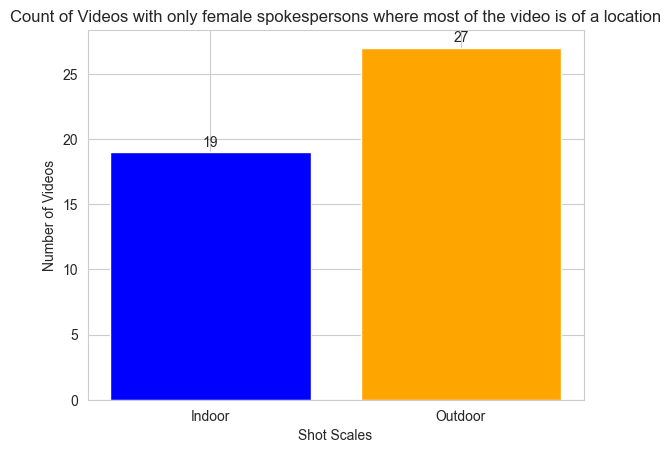

In [137]:
# We can now calculate the number of videos that have majority outdoor or indoor
# Count the number of videos where their proportion of a shot exceeds 0.7 to find the number of videos that have such shot dominance

threshold = 0.5
# Count videos where proportion > threshold for each shot scale
counts = {
    'Indoor': (df_video_f['indoor_percentage'] > threshold).sum(),
    'Outdoor': (df_video_f['outdoor_percentage'] > threshold).sum(),
    # 'Graphics': (df_video_f['graphics_percentage'] > threshold).sum()
}

# Plot the counts as a bar chart
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green'])
# Add annotations
for index, (key, value) in enumerate(counts.items()):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Shot Scales')
plt.ylabel('Number of Videos')
plt.title(f'Count of Videos with only female spokespersons where most of the video is of a location')
plt.show()

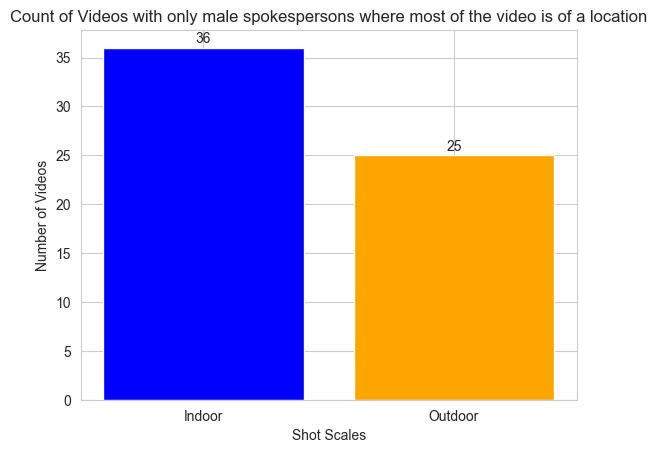

In [138]:
# We can now calculate the number of videos that have majority outdoor or indoor
# Count the number of videos where their proportion of a shot exceeds 0.7 to find the number of videos that have such shot dominance

threshold = 0.5
# Count videos where proportion > threshold for each shot scale
counts = {
    'Indoor': (df_video_m['indoor_percentage'] > threshold).sum(),
    'Outdoor': (df_video_m['outdoor_percentage'] > threshold).sum(),
    # 'Graphics': (df_video_m['graphics_percentage'] > threshold).sum()
}

# Plot the counts as a bar chart
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange', 'green'])
# Add annotations
for index, (key, value) in enumerate(counts.items()):
    plt.text(index, value + 0.2, str(value), ha='center', va='bottom', fontsize=10)

plt.xlabel('Shot Scales')
plt.ylabel('Number of Videos')
plt.title(f'Count of Videos with only male spokespersons where most of the video is of a location')
plt.show()

We can thus observe that videos with only female spokespersons indeed do have proportionally more videos which mostly takes place outdoors.